In [1]:
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# 한글폰트 설정 (실행 후 런타임 다시 시작하고 다시 실행하면 한글폰트 적용 가능) -> colab 기준, jupyter 사용시 문의바람
!apt-get update -qq
!apt-get install fonts-nanum* -qq

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
import warnings
warnings.filterwarnings(action='ignore') 

path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
font_name = fm.FontProperties(fname=path, size=10).get_name()
plt.rc('font', family=font_name)
fm._rebuild()

In [33]:
total_df = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/raw_data/W_total.csv')
cars_final = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/cars_final.csv')
total_df
cars_final

Unnamed: 0        name  model maker prefix postfix           kind
0              0        E클래스  E-클래스    벤츠      0       0          Sedan
1              1          넥소     넥쏘    현대      0       0  Mid-Large suv
2              2         봉고3    NaN    기아      0       0            NaN
3              3         포터2    NaN    현대      0       0            NaN
4              4        E220  E-클래스    벤츠      0       0          Sedan
...          ...         ...    ...   ...    ...     ...            ...
3387        3387         봉고   1열 봉고    기아      0       0  One row truck
3388        3388         K7      K7    기아      0       0          Sedan
3389        3389        모하비     모하비    기아      0       0  Mid-Large suv
3390        3390  HALEYCAR    Haley    볼보      0       0            NaN
3391        3391      E-클래스   E-클래스    벤츠      0       0          Sedan

[3392 rows x 7 columns]

In [34]:
# 차 이름 - 모델 매칭 테이블 불러오기
name = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/cars_final.csv')
name.head()

Unnamed: 0  name  model maker prefix postfix           kind
0           0  E클래스  E-클래스    벤츠      0       0          Sedan
1           1    넥소     넥쏘    현대      0       0  Mid-Large suv
2           2   봉고3    NaN    기아      0       0            NaN
3           3   포터2    NaN    현대      0       0            NaN
4           4  E220  E-클래스    벤츠      0       0          Sedan

In [35]:
# 차 이름 - 모델 매칭 테이블과 조인
total_df = total_df.merge(name[['name', 'model', 'maker','kind']], left_on = 'car', right_on = 'name', how = 'left')
total_df.head()

Unnamed: 0       regist_dt             car  ... model maker           kind
0           0  20201231165209             렉스턴  ...   렉스턴    쌍용  Mid-Large suv
1           1  20201231164930              K7  ...    K7    기아          Sedan
2           2  20201231164557              투싼  ...    투싼    현대  Mid-Large suv
3           3  20201231154431  기아 4세대 카니발 KA4  ...   카니발    기아            van
4           4  20201231145042             QM6  ...   QM6  르노삼성  Mid-Large suv

[5 rows x 18 columns]

In [36]:
# 상품번호 - 상품명 매칭 테이블 가져오기 및 조인
product = pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/raw_data/product.csv')
product = product.rename(columns = {'name' : 'product_name'})
total_df_item = total_df.copy()
for i in range(1, 7):
  total_df_item = total_df_item.merge(product[['product', 'product_name']], left_on = 'product_%d'%i, right_on = 'product', how = 'left')
  total_df_item = total_df_item.rename(columns = {'product_name' : 'product_%d_name' % i})
  total_df_item = total_df_item.drop(columns = ['product'])
total_df_item.head()

Unnamed: 0       regist_dt  ... product_5_name product_6_name
0           0  20201231165209  ...       Pinnacle       Pinnacle
1           1  20201231164930  ...           Star            NaN
2           2  20201231164557  ...          Super            NaN
3           3  20201231154431  ...           Star            NaN
4           4  20201231145042  ...          Super            NaN

[5 rows x 24 columns]

In [52]:
#스토어 위도경도 정보 머지
total_df_item_store = pd.merge(total_df_item,pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/store_latlng.csv').drop('Unnamed: 0', axis=1),on = 'store_addr')
import ast
def str_to_tuple(latlng):
  return float(ast.literal_eval(latlng)[0]),float(ast.literal_eval(latlng)[1])
total_df_item_store.latlng = total_df_item_store.latlng.map(lambda x: str_to_tuple(x))

In [91]:
stores = pd.merge(total_df_item[['store','store_addr']],pd.read_csv('/content/drive/Shareddrives/[GH x RiderDash]/Data/Preprocessing/store_latlng.csv').drop('Unnamed: 0', axis=1),on = 'store_addr').drop_duplicates().reset_index(drop=True)

In [55]:
import math
foreign = {'쌍용':0, 'BMW':1, '르노':1, '현대':0, '미니':1, '기아':0, '르노삼성':0, '0':np.nan, '벤츠':1, '혼다':1,
       '렉서스':1, '제네시스':0, '폭스바겐':1, '테슬라':1, '쉐보레/한국GM':0, '푸조':1, '랜드로버':1, '아우디':1,
       '쉐보레':1, '포르쉐':1, '닛산':1, '지프':1, '재규어':1, '포드':1, '아큐라':1, '토요타':1, '벤틀리':1,
       '홀덴':1, '볼보':1, '링컨':1, '인피니티':1, '마세라티':1, '크라이슬러':1, '미쓰비시':1, '스마트':1, '캐딜락':1,
       '시트로엥':1, '페라리':1, '닷지':1, '다이하쓰':1, '스바루':1, '스즈키':1, '롤스로이스':1, 'GMC':1, '동풍소콘':1,
       '람보르기니':1, '마쯔다':1, '로터스':1, '비이스만':1, '머큐리':1, '올즈모빌':1, '허머':1, '애스턴마틴':1,
       '알파로메오':1, '피아트':1, '이스즈':1, '뷰익':1, '어울림모터스':0, '맥라렌':1}
country = {'쌍용':'한국', 'BMW':'독일', '르노':'프랑스', '현대':'한국', '미니':'독일', '기아':'한국', '르노삼성':'한국', '0':np.nan, '벤츠':'독일', '혼다':'일본',
       '렉서스':'일본', '제네시스':'한국', '폭스바겐':'독일', '테슬라':'미국', '쉐보레/한국GM':'한국', '푸조':'프랑스', '랜드로버':'영국', '아우디':'독일',
       '쉐보레':'미국', '포르쉐':'독일', '닛산':'일본', '지프':'미국', '재규어':'영국', '포드':'미국', '아큐라':'일본', '토요타':'일본', '벤틀리':'영국',
       '홀덴':'호주', '볼보':'스웨덴', '링컨':'미국', '인피니티':'일본', '마세라티':'이탈리아', '크라이슬러':'미국', '미쓰비시':'일본', '스마트':'독일', '캐딜락':'미국',
       '시트로엥':'프랑스', '페라리':'이탈리아', '닷지':'미국', '다이하쓰':'일본', '스바루':'일본', '스즈키':'일본', '롤스로이스':'영국', 'GMC':'미국', '동풍소콘':'중국',
       '람보르기니':'이탈리아', '마쯔다':'일본', '로터스':'영국', '비이스만':'독일', '머큐리':'미국', '올즈모빌':'미국', '허머':'미국', '애스턴마틴':'영국',
       '알파로메오':'이탈리아', '피아트':'이탈리아', '이스즈':'일본', '뷰익':'미국', '어울림모터스':'한국', '맥라렌':'영국'}

total_df_item_store['foreign'] = total_df_item_store.maker.map(lambda x: foreign[x] if type(x)==str and x in foreign.keys() else np.nan)
total_df_item_store['country'] = total_df_item_store.maker.map(lambda x: country[x] if type(x)==str and x in country.keys() else np.nan)

store
eabb79c85a0e83fb5efc7c7b992dc01c    0.004040
3c063035d25be531cdcaa97ce168553d    0.005338
f93b6802defdb40c90ac377ab0025de5    0.007634
9350d99198676f7def676af955ad5fd0    0.019890
ac2aec5fecce163e43efa0ed502da2f4    0.021552
faf6556521007e1f71509689bb426b1e    0.022454
1148020ac71d64c20dd74e3908771b72    0.029851
635fe6a1a1682e388d85aac48fec0cce    0.030124
0d13369bf930d44063e9f7968e08cb28    0.033505
4b662724fcec9daedb68917760aa5e15    0.048780
8e5bb016e2cc17facfe4288d45c25917    0.104677
fd98cb0a5975ad7d2dc23534ed73eb21    0.109244
ee9e2f46ae9d01e3f86b3fce9e3d2c02    0.161491
d39fa2f90dd3263e168d728211086116    0.175258
de6535b79eeaf0fbee24a3409635de60    0.182482
5bb60bdee333ee82ccbee3437366adee    0.243697
9e374dfa94b137609ef41015e88ad7f9    0.254296
461fa55291e22de831a424f6877b5a94    0.261993
9143d451f70cc69da226f3fc152bd279    0.305455
470924011e7337833d28a8c8bba49ad5    0.306163
70b9851a499fe76de792ddd4a88b612c    0.310112
602e7722acea1e16c10f31f1c25b6c45    0.323821
9de7

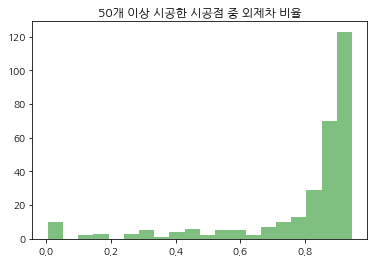

In [56]:
#50개 이상 시공한 시공점 중 외제차 비율
over_50_stores = total_df_item_store.groupby(['store'])['regist_dt'].count()[total_df_item_store.groupby(['store'])['regist_dt'].count()>50].index
over_50 = total_df_item_store[total_df_item_store['store'].isin( over_50_stores)]

foreign_df = over_50.groupby(['store','foreign'])['regist_dt'].count().reset_index()
foreign_stores = (foreign_df[foreign_df['foreign']==0].groupby(['store'])['regist_dt'].sum()/foreign_df.groupby(['store'])['regist_dt'].sum()).sort_values(ascending=True)
plt.title('50개 이상 시공한 시공점 중 외제차 비율')
plt.hist(foreign_stores.head(300),bins=20,color ='green',alpha=.5)
foreign_stores.head(34)


In [57]:
total_df_item_store[total_df_item_store['store']=='eabb79c85a0e83fb5efc7c7b992dc01c']

Unnamed: 0       regist_dt  ... foreign country
126805      241173  20191205161708  ...     1.0      미국
126854      257815  20191004160751  ...     1.0      일본
126855      257817  20191004160554  ...     1.0      일본
126861      259352  20190928085937  ...     1.0      일본
126863      259638  20190927121951  ...     1.0      일본
...            ...             ...  ...     ...     ...
127852      393630  20180117112940  ...     1.0      일본
127853      393654  20180117090250  ...     1.0      일본
127854      394318  20180110125348  ...     1.0      일본
127855      394479  20180109144652  ...     1.0      일본
127856      395066  20180105130736  ...     1.0      일본

[990 rows x 28 columns]

In [103]:
maker_count = over_50.groupby(['store','maker'])['regist_dt'].count().reset_index()
(maker_count[maker_count['maker']=='현대'].groupby(['store'])['regist_dt'].sum()/maker_count.groupby(['store'])['regist_dt'].sum()).sort_values(ascending=False).head(30)
def makerXstore(brand):
  ser =  ((maker_count[maker_count['maker']==brand].groupby(['store'])['regist_dt'].sum()/maker_count.groupby(['store'])['regist_dt'].sum()).sort_values(ascending=False).head(30))
  df = stores[stores['store'].isin(ser.index)]
  df['percentage'] = df.store.map(lambda x: ser[x])
  df = df.drop('latlng',axis = 1)
  return df.sort_values(by = 'percentage', ascending = False)

## 현대

In [104]:
makerXstore('현대')

store  ... percentage
173   871fe8c038a14e349318ea71d2375c14  ...   0.884058
493   22ca954b609b612346611dbcd6931679  ...   0.873563
264   dd87f3c295bd7aa41eaaa9496da2365b  ...   0.829596
140   46d026058e7bd48032dd256d7449222d  ...   0.825843
324   b9290d4a321e1d012e379c1c3f989a0e  ...   0.816867
357   76c477f02bd8d97fa2440819155c209a  ...   0.813333
328   4ac16abb9f702421c99f979184c71099  ...   0.813043
2     f87010f9e1357101908204837a9f05fd  ...   0.805556
71    684e2165feace1a8db5964b78493f333  ...   0.798535
1137  efc0ad6c389dc069d05bcf667322a8d2  ...   0.786746
362   b37f79ca4ce4c687e62a82c008e92561  ...   0.782609
34    ed7e4484a1044a3996feb6a7823fa7cd  ...   0.778656
244   1f5ce8055dcaa33bc57b2e548de5c1c6  ...   0.763819
153   adb37f7d6c291c1fac89f9af0defb0a9  ...   0.763158
161   5f93c67d9b0fec545dbae40764193bbf  ...   0.762500
51    1d75cecf4839fe56479a4b784df01480  ...   0.754167
787   3e4230ca2efd762ebc352ec3c0c3bd35  ...   0.748344
127   58785463e8a6a59d1f55473d69fd9f8d  ...   0.742515
86    f50fc6cca5b66a313f80886dbc5873c9  ...   0.740566
318   d00c6dfe2ca692d167924c81d4e487cf  ...   0.735294
762   73035a30acaab974b8dbb5da81070e6b  ...   0.733333
28    a53e8b874550a332200856563340f304  ...   0.732143
745   715161d80576c714f0b6775809141298  ...   0.729323
377   a28205b90db5b35be2876ee3a6a26fc7  ...   0.728507
838   59bef703f71de89191562e3ea3aba967  ...   0.727273
560   d082449286c471971c02c79056e1c817  ...   0.726002
157   6ff8ad204e8fdf3c7d986350ee6b6d6f  ...   0.725564
510   8bd9bdc335ef314235a82060984fa576  ...   0.721457
79    8b7c8781ee0e3745afc30dc29286c3a0  ...   0.719008
55    b8e445735195092f3ac682d85150aae0  ...   0.715909

[30 rows x 4 columns]

In [107]:
def store_df(code):
  return total_df_item_store[(total_df_item_store['store']==code)]
store_df('fdf03abd6b6550637798e7ec9cb527fe')

Unnamed: 0       regist_dt        car  ... predicted_name foreign  country
332          32  20201229172710       E클래스  ...        Unknown     1.0       독일
333          34  20201229170326       E클래스  ...        Unknown     1.0       독일
350         878  20201117170708   new E클래스  ...        Unknown     1.0       독일
353        1013  20201111170903        GLA  ...        Unknown     1.0       독일
358        1108  20201109085722       S클래스  ...        Unknown     1.0       독일
..          ...             ...        ...  ...            ...     ...      ...
696       31660  20190327091124        GLC  ...        Unknown     1.0       독일
700       32015  20190322124116       C220  ...        Unknown     1.0       독일
710       33388  20190307152648  E200카브리올레  ...        Unknown     1.0       독일
716       33945  20190228115504       E220  ...        Unknown     1.0       독일
780       44403  20181011101500       A클래스  ...        Unknown     1.0       독일

[134 rows x 28 columns]

maker
현대      0.884058
제네시스    0.086957
기아      0.028986
Name: regist_dt, dtype: float64
total: 69


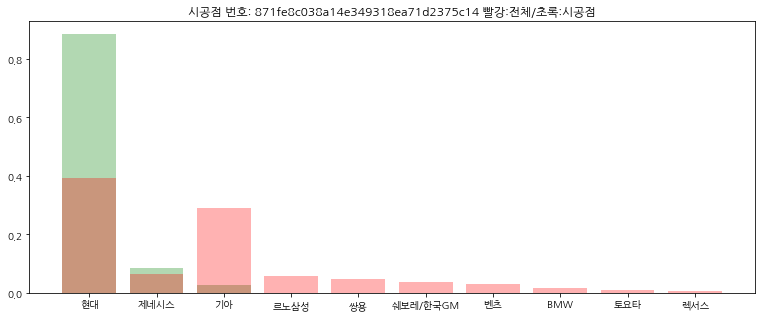

maker
현대      0.873563
기아      0.080460
제네시스    0.045977
Name: regist_dt, dtype: float64
total: 87


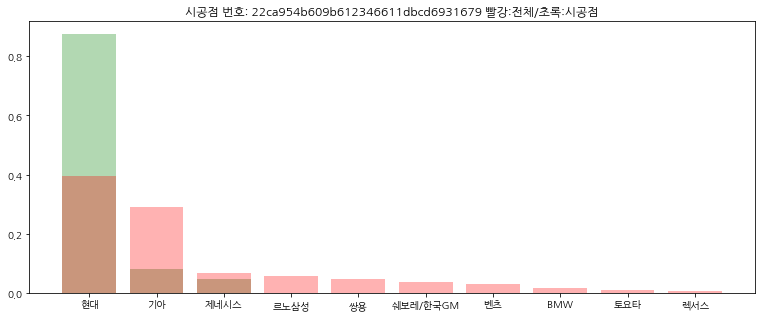

maker
현대          0.829596
기아          0.103139
제네시스        0.031390
쉐보레/한국GM    0.013453
쌍용          0.008969
쉐보레         0.008969
르노삼성        0.004484
Name: regist_dt, dtype: float64
total: 223


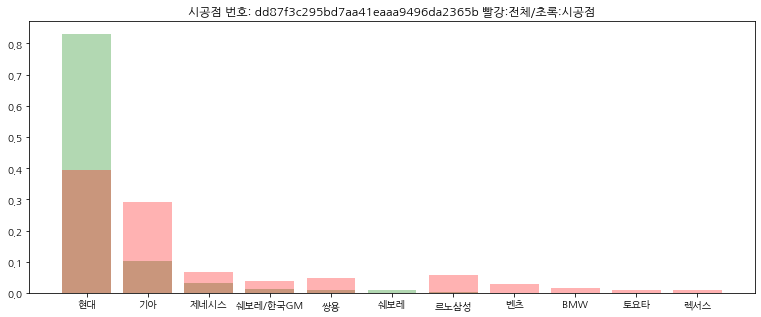

maker
현대          0.825843
제네시스        0.122472
기아          0.033708
쌍용          0.011236
아큐라         0.002247
쉐보레/한국GM    0.002247
포드          0.000562
시트로엥        0.000562
르노삼성        0.000562
BMW         0.000562
Name: regist_dt, dtype: float64
total: 1780


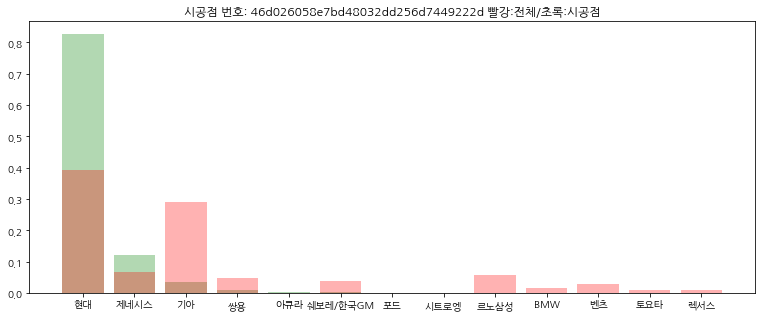

maker
현대          0.816867
제네시스        0.096386
기아          0.055422
아우디         0.014458
쉐보레/한국GM    0.004819
쌍용          0.002410
시트로엥        0.002410
벤츠          0.002410
닛산          0.002410
BMW         0.002410
Name: regist_dt, dtype: float64
total: 415


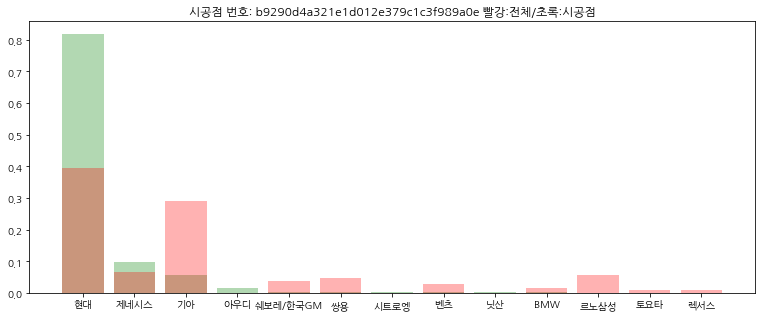

maker
현대      0.813333
기아      0.120000
제네시스    0.040000
쉐보레     0.013333
르노삼성    0.013333
Name: regist_dt, dtype: float64
total: 75


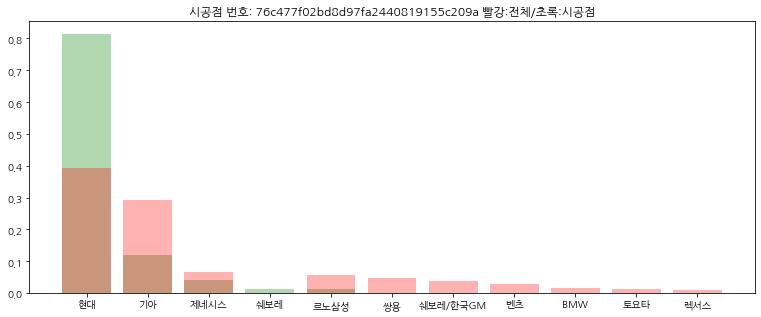

maker
현대          0.813043
기아          0.104348
제네시스        0.065217
쉐보레/한국GM    0.013043
르노삼성        0.004348
Name: regist_dt, dtype: float64
total: 230


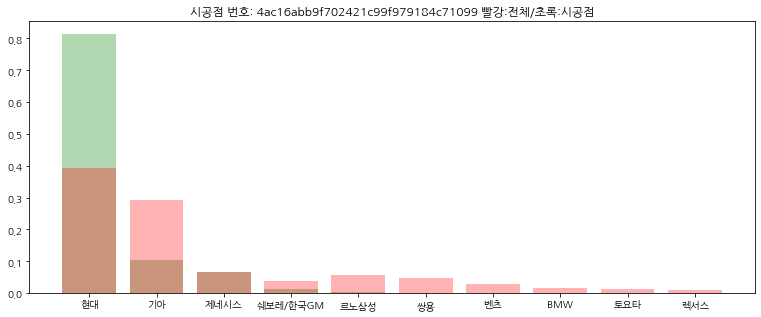

maker
현대      0.805556
제네시스    0.088889
기아      0.066667
아큐라     0.027778
쌍용      0.005556
르노삼성    0.005556
Name: regist_dt, dtype: float64
total: 180


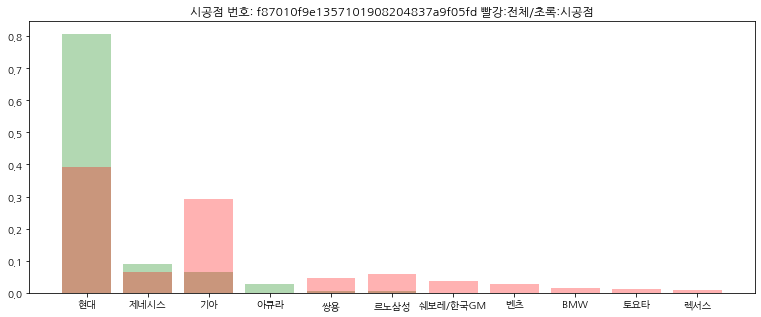

maker
현대          0.798535
기아          0.135531
제네시스        0.054945
쌍용          0.005495
르노삼성        0.003663
쉐보레/한국GM    0.001832
Name: regist_dt, dtype: float64
total: 546


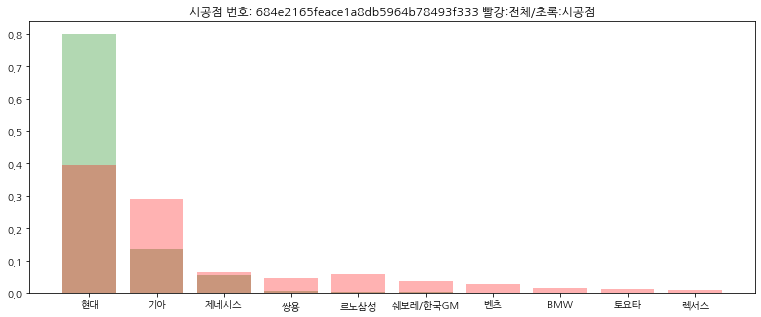

maker
현대          0.786746
제네시스        0.137638
기아          0.046729
아큐라         0.010195
쉐보레/한국GM    0.006797
쌍용          0.002549
벤츠          0.002549
혼다          0.000850
폭스바겐        0.000850
포르쉐         0.000850
Name: regist_dt, dtype: float64
total: 1177


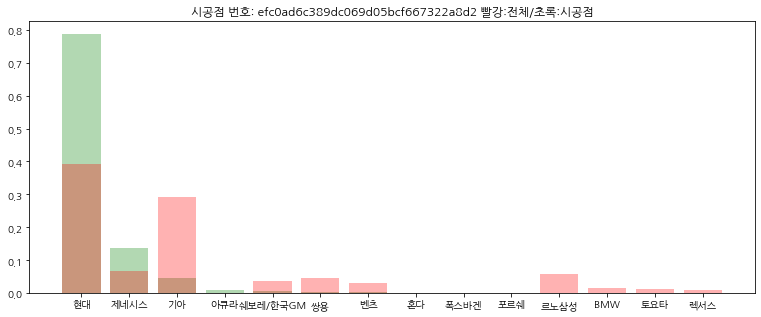

In [131]:
#브랜드별 비율 많은 시공점 살펴보기
total_counts = total_df_item_store.groupby(['maker'])['regist_dt'].count()/len(total_df_item_store)

def vis_counts(code):
  counts = total_df_item_store[total_df_item_store['store'] == code].groupby(['maker'])['regist_dt'].count().sort_values(ascending=False)[0:10]/len(total_df_item_store[total_df_item_store['store'] == i])
  print(counts)
  print(f'total: {len(store_df(code))}')
  plt.figure(figsize = (13,5))
  plt.title(f'시공점 번호: '+i+' 빨강:전체/초록:시공점')
  plt.bar(x = counts.index, height = counts, color='green', alpha=.3)
  plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10], color='red', alpha=.3)
  plt.show()


for i in makerXstore('현대')[:10].store:
  vis_counts(i)

## 르노삼성

In [119]:
makerXstore('르노삼성')

store  ... percentage
13    5fb9e60a3686436567a032d93539f07c  ...   0.991150
100   0234ca9d57975ee8cc3658c7eca201f5  ...   0.929825
130   349eac7646ea48469a72d2d80ed01c36  ...   0.846154
24    afd4390f0443216b0bb495605451e947  ...   0.838235
623   ba08267d657ae6a3c1b4645df3c4749e  ...   0.838235
946   aa8dd0c2225c0e70fc7445bd8c5556db  ...   0.785311
774   052b9501673cb07862918b46c4263e5c  ...   0.779775
226   2ff8b3c668b6b9245ca9e761d2b5b6fe  ...   0.685000
621   8aa19dbe05fdc55b36c724e258c8ce57  ...   0.627397
804   f45afb5a356aaaada9407b37f1b0fbce  ...   0.553571
95    b992e1f42270a40b3dd0d99d757a2c44  ...   0.537634
957   fe77c1689c42534b4126fd59be673a3f  ...   0.515337
387   94ee70074484bf0cb951138a54edfc5c  ...   0.513043
627   2dd8c112d290ad96b39cbf1d9b115d6a  ...   0.508880
5     031f6479e496957d9c48f1c563c66f7c  ...   0.505843
674   287b33978bda40ad8e7aee9adf445f99  ...   0.495564
115   d12f87eb216363e055666536c0b834a4  ...   0.494505
1251  cf2a9ebe3f72689681f82840f145f339  ...   0.491228
258   e2fe01c90d0ed5b4c81f8515fc6e4f82  ...   0.479821
1260  b4ab0410b11f105310f8f015aa411d3d  ...   0.477477
35    6cd122387680f57e383b624eb35272d2  ...   0.471591
306   4381f22715eae6e2284f0971eeaa05d0  ...   0.466948
65    08281c648c0b30258834699eb531396e  ...   0.441860
347   9f5b4ef4b13cea64ecf1beccc75ea64f  ...   0.422078
379   f5a26665e9d1d9fdd4fe6f486b94597c  ...   0.401372
982   b1cc476baf8058981d40e31994c00a11  ...   0.387365
842   69b045312e6a7ba95d3db545e9681e48  ...   0.383107
731   2df0a83110c3d8bb2383dfd9be65ad05  ...   0.365169
1248  a689f5ebd3b5539b727e4bca0a8ada68  ...   0.338558
1213  2b257c9832adc6c0b67011ca593efceb  ...   0.325203

[30 rows x 4 columns]

maker
르노삼성    0.99115
르노      0.00885
Name: regist_dt, dtype: float64
total: 226


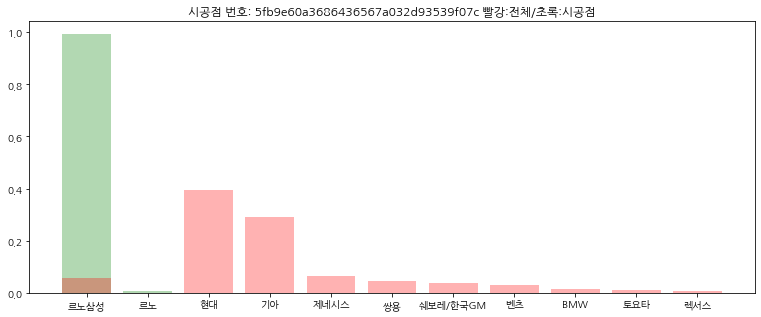

maker
르노삼성        0.929825
현대          0.017544
쉐보레/한국GM    0.017544
르노          0.017544
기아          0.017544
Name: regist_dt, dtype: float64
total: 57


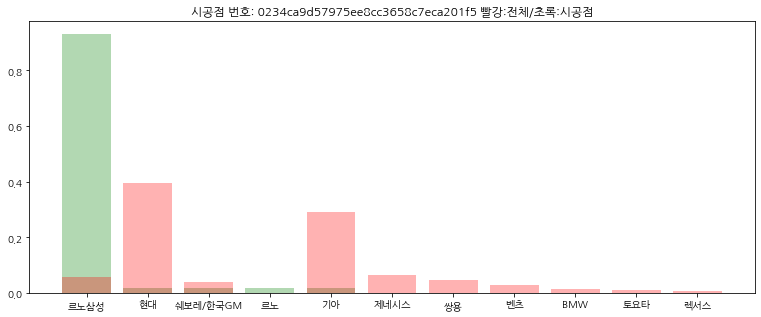

maker
르노삼성    0.846154
현대      0.076923
기아      0.038462
폭스바겐    0.012821
쌍용      0.012821
쉐보레     0.012821
Name: regist_dt, dtype: float64
total: 78


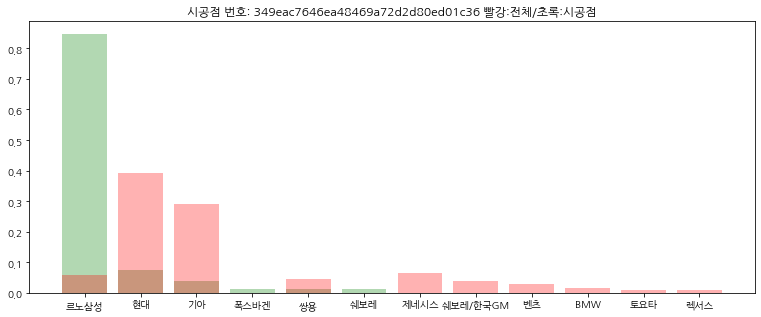

maker
르노삼성    0.838235
기아      0.102941
현대      0.029412
제네시스    0.029412
Name: regist_dt, dtype: float64
total: 68


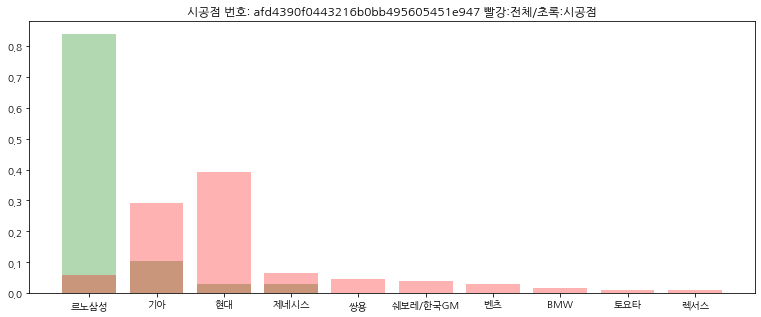

maker
르노삼성        0.838235
기아          0.058824
현대          0.051471
르노          0.036765
제네시스        0.007353
쉐보레/한국GM    0.007353
Name: regist_dt, dtype: float64
total: 136


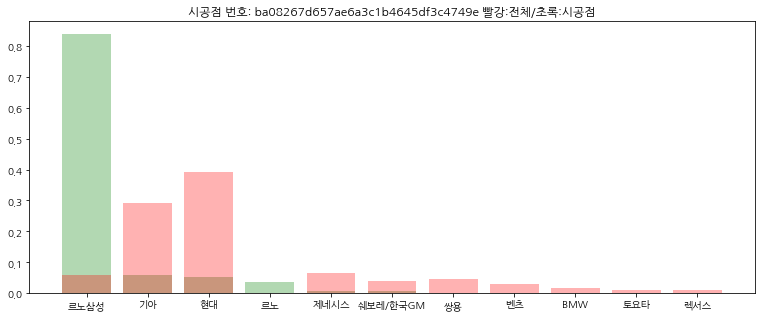

maker
르노삼성        0.785311
현대          0.135593
제네시스        0.033898
기아          0.033898
토요타         0.002825
쉐보레/한국GM    0.002825
벤츠          0.002825
렉서스         0.002825
Name: regist_dt, dtype: float64
total: 354


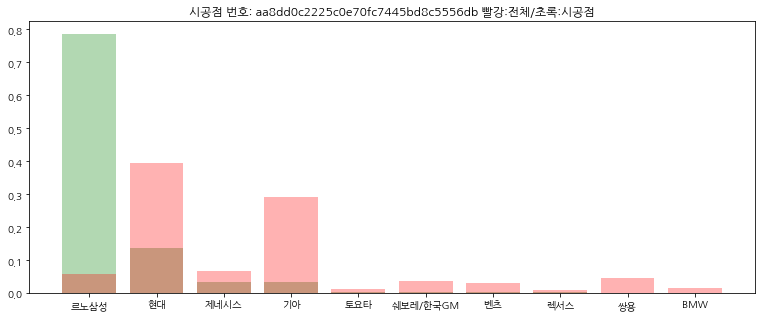

maker
르노삼성        0.779337
현대          0.095452
기아          0.070747
제네시스        0.016283
쌍용          0.011230
쉐보레/한국GM    0.008422
르노          0.006176
아우디         0.003369
폭스바겐        0.001684
지프          0.001684
Name: regist_dt, dtype: float64
total: 1781


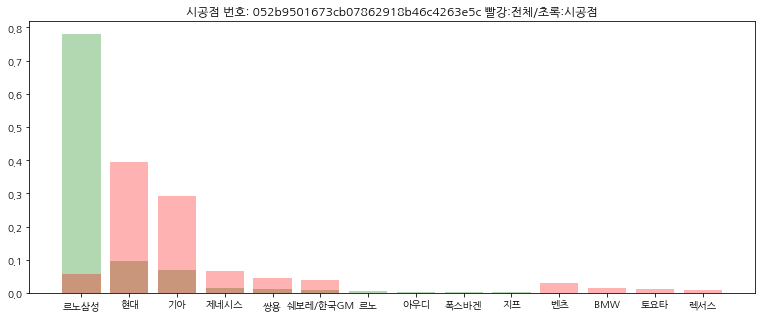

maker
르노삼성    0.685
현대      0.185
기아      0.065
제네시스    0.030
아우디     0.015
폭스바겐    0.010
벤츠      0.005
BMW     0.005
Name: regist_dt, dtype: float64
total: 200


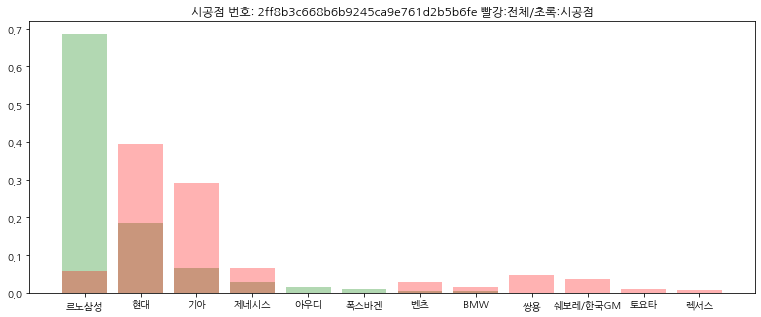

maker
르노삼성        0.622283
기아          0.149457
현대          0.100543
제네시스        0.032609
르노          0.027174
쌍용          0.019022
쉐보레/한국GM    0.008152
벤츠          0.008152
쉐보레         0.005435
볼보          0.005435
Name: regist_dt, dtype: float64
total: 368


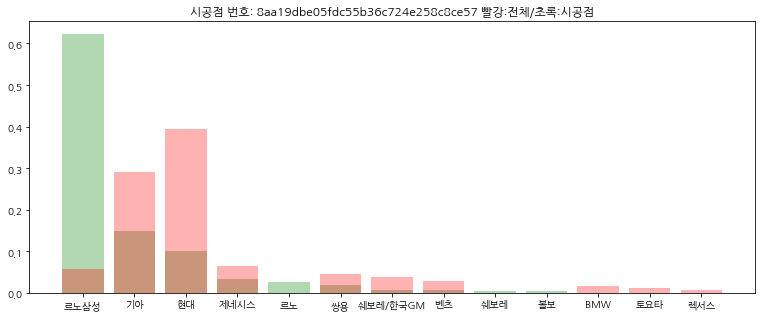

maker
르노삼성        0.553571
현대          0.267857
기아          0.142857
쉐보레/한국GM    0.035714
Name: regist_dt, dtype: float64
total: 56


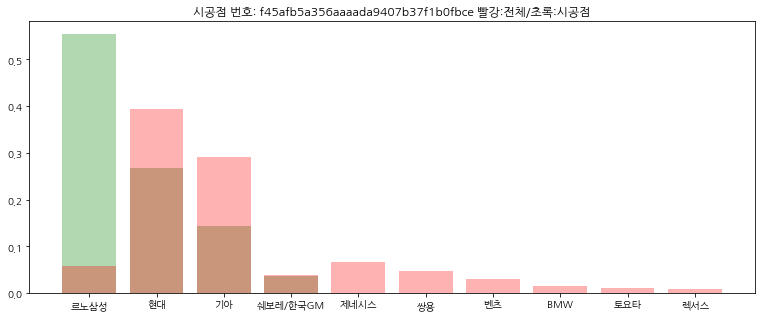

In [126]:
for i in makerXstore('르노삼성')[:10].store:
  vis_counts(i)

## 쉐보레/한국GM

In [121]:
makerXstore('쉐보레/한국GM')

store  ... percentage
586   bcb8329a4c125a0776f2e04613453980  ...   0.780822
501   6d4e4e4d96eab2eabc49f52b87ca7334  ...   0.657143
1084  4accb2bce65a7667ab4eff62bfe58a1f  ...   0.586111
426   c1f877035f69663f7cd608fad054ff98  ...   0.423913
302   224ca711c6bd237a12f4e84783b8cb7c  ...   0.373563
8     9fb77ddff7d00f98645bade4af4b4b7f  ...   0.367816
66    cbfe0e09c3d5f1450c51b9a66e5444c7  ...   0.361290
819   2e06a7eb6130e2c7c7bfda225d552a5e  ...   0.359206
150   a7a8b2584ca9b149968039bdbefdea62  ...   0.345455
445   d512b094429c46d3767066548496d8f4  ...   0.324841
50    8457c6a50658ae82bf6fa47b0e432794  ...   0.311448
149   2e2ae0294ec042b3832d5f3b76d27385  ...   0.309735
723   fbf5ebbc190f40d73da6c0270b76e2a8  ...   0.303983
190   bd938d6a7207e33131043bbcb39065d1  ...   0.285714
1209  c8b84d7ad6581da26ec05da1bf358630  ...   0.280992
428   3c2d055e2380e3d800a84918b4f9820b  ...   0.278505
820   1eda440235d47633f28a45c4c6c4dab6  ...   0.261484
374   ef0daa6325282504d273bc32eb880a66  ...   0.252101
299   83d20031dfda4467cfa1a96f8414c8a3  ...   0.235178
533   f177412a58d8eddd4c2e918673766601  ...   0.228587
195   23cb44202ad8ff5e0310f76562dacbc1  ...   0.218783
387   94ee70074484bf0cb951138a54edfc5c  ...   0.217391
224   3af6b1eb7037f5694cbe6e0ac54586b3  ...   0.214592
68    1c8f9a1aafa4ee921f8847ab0dee3e41  ...   0.212435
916   14b45f13afc562669f7149eb141afe29  ...   0.211679
48    1f998ca2e18d0821581b178e89c708e6  ...   0.206897
92    ce10c22006e4b081b5a011593a61f335  ...   0.191388
353   3b45110752dd1c4592d0255c233bcda7  ...   0.184510
111   183b31ed7a81c98b698182f0e4111319  ...   0.178295
1123  2592cd221e614af08bfa730aa09fba0c  ...   0.177370

[30 rows x 4 columns]

maker
쉐보레/한국GM    0.780822
쉐보레         0.178082
현대          0.027397
기아          0.013699
Name: regist_dt, dtype: float64
total: 73


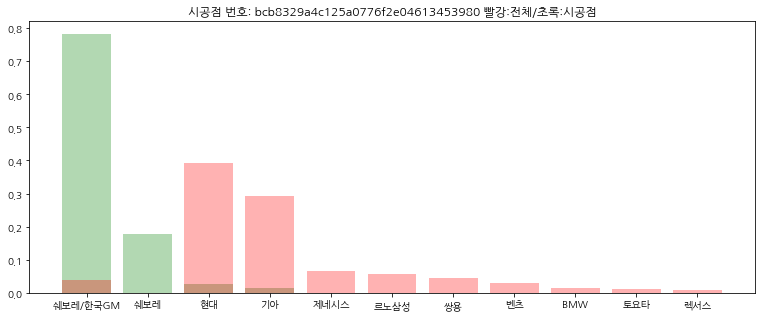

maker
쉐보레/한국GM    0.647887
기아          0.126761
현대          0.098592
쉐보레         0.070423
홀덴          0.014085
제네시스        0.014085
쌍용          0.014085
Name: regist_dt, dtype: float64
total: 71


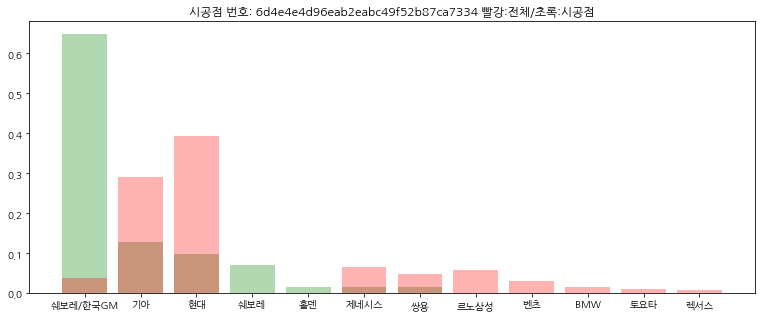

maker
쉐보레/한국GM    0.586111
현대          0.197222
기아          0.141667
제네시스        0.022222
쌍용          0.016667
BMW         0.011111
르노삼성        0.008333
쉐보레         0.005556
폭스바겐        0.002778
벤츠          0.002778
Name: regist_dt, dtype: float64
total: 360


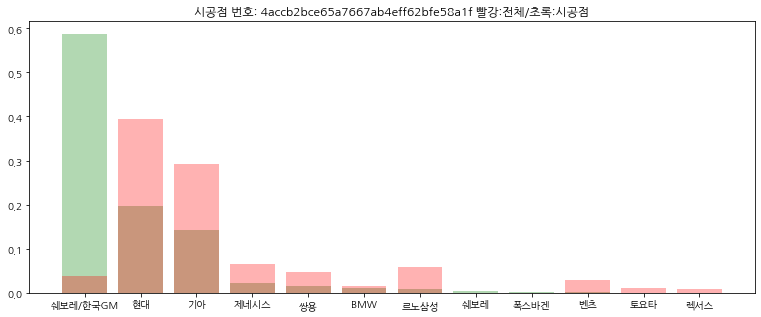

maker
쉐보레/한국GM    0.423913
기아          0.358696
현대          0.135870
르노삼성        0.048913
제네시스        0.032609
Name: regist_dt, dtype: float64
total: 184


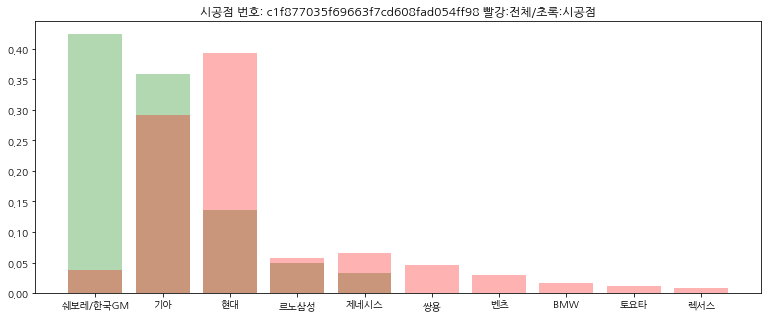

maker
쉐보레/한국GM    0.373563
현대          0.333333
기아          0.160920
쉐보레         0.057471
르노삼성        0.040230
쌍용          0.017241
포드          0.005747
제네시스        0.005747
벤츠          0.005747
Name: regist_dt, dtype: float64
total: 174


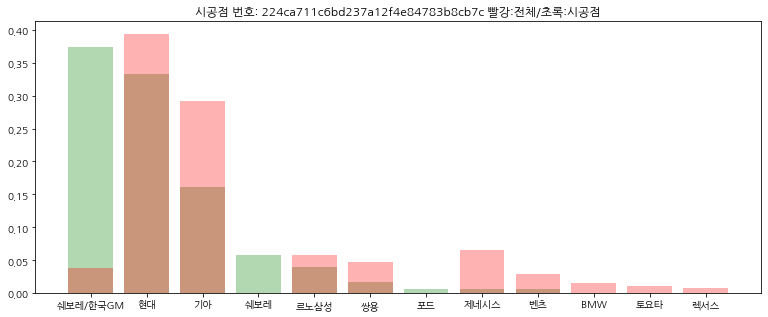

maker
쉐보레/한국GM    0.363636
현대          0.295455
기아          0.090909
벤츠          0.068182
르노삼성        0.068182
BMW         0.068182
쉐보레         0.022727
아우디         0.011364
Name: regist_dt, dtype: float64
total: 88


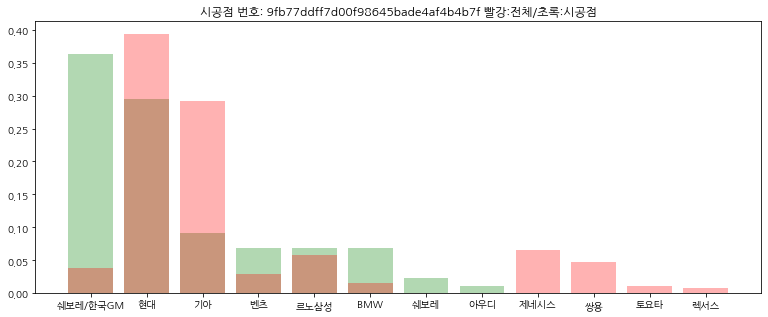

maker
쉐보레/한국GM    0.358974
현대          0.333333
쉐보레         0.141026
기아          0.121795
제네시스        0.032051
BMW         0.006410
Name: regist_dt, dtype: float64
total: 156


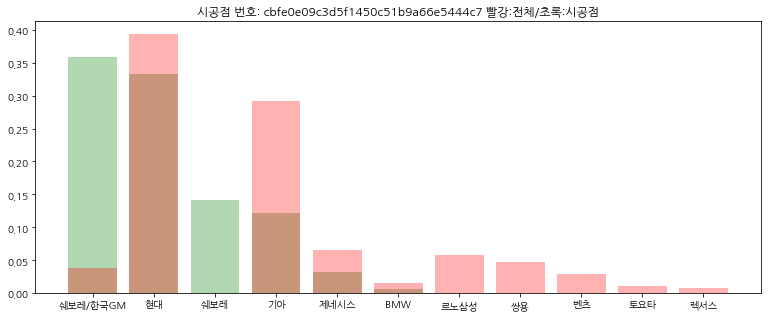

maker
쉐보레/한국GM    0.355993
현대          0.352415
기아          0.159213
제네시스        0.032200
쌍용          0.025045
르노삼성        0.025045
쉐보레         0.012522
BMW         0.010733
폭스바겐        0.005367
홀덴          0.003578
Name: regist_dt, dtype: float64
total: 559


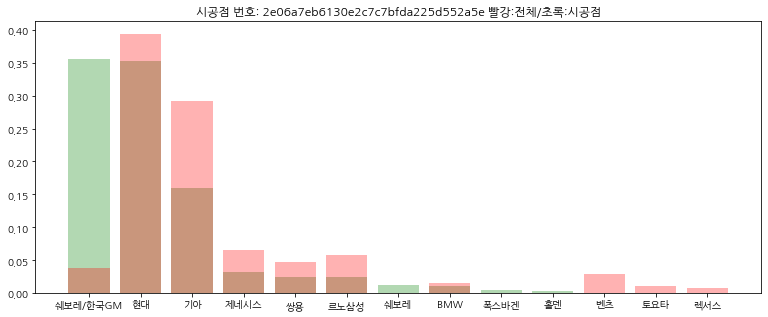

maker
쉐보레/한국GM    0.343373
기아          0.271084
현대          0.234940
쉐보레         0.084337
쌍용          0.036145
르노삼성        0.012048
제네시스        0.006024
0           0.006024
Name: regist_dt, dtype: float64
total: 166


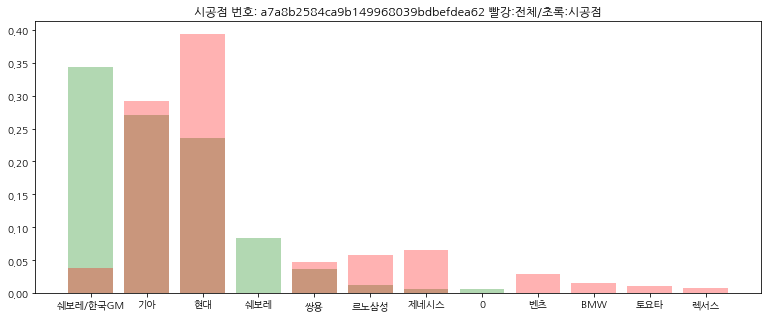

maker
쉐보레/한국GM    0.324841
현대          0.261146
기아          0.159236
제네시스        0.095541
캐딜락         0.057325
테슬라         0.019108
르노삼성        0.019108
BMW         0.019108
푸조          0.012739
폭스바겐        0.006369
Name: regist_dt, dtype: float64
total: 157


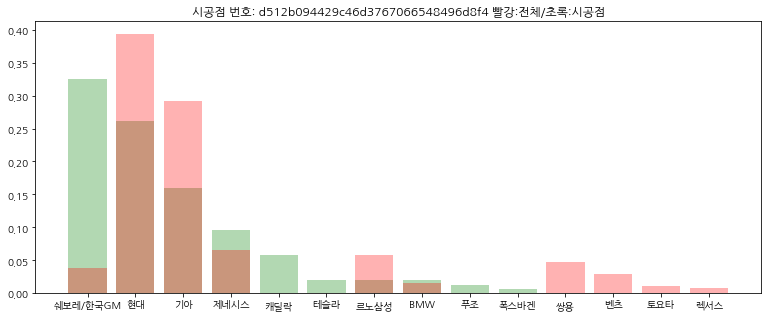

In [127]:
for i in makerXstore('쉐보레/한국GM')[:10].store:
  vis_counts(i)

In [124]:
makerXstore('쌍용')

store  ... percentage
1222  50ab3bd175edfc2d0e59011dab231002  ...   0.990099
284   7bc21dc31abad212a420c1dbb03f19ca  ...   0.977099
317   cca10159fb577eb1c1a366b576476e83  ...   0.953846
147   e3752ae55c6844e28c31444a78a8954e  ...   0.952381
307   43f96563e967baf731f2e32b22d6dbdf  ...   0.924000
703   b476913f5d0e38d6c5c1023679f2f0f2  ...   0.900000
97    024c1b40c1df9c1ceaeff810baf98cd9  ...   0.898305
1057  a6891bd8adffe3c6f223336175c6c663  ...   0.878298
52    b31ce1d32ba8d6e1dd0a30fd5198a695  ...   0.872727
82    a876afd6e9012c373dc96d2c1eb99f90  ...   0.747423
435   7640854020a7260a6393f40c7df1982f  ...   0.746424
199   40efbe45b31ee942a5ef3b52c3aa2eb7  ...   0.741071
912   e472c5ad433b06d202f176f4bf271771  ...   0.633803
190   bd938d6a7207e33131043bbcb39065d1  ...   0.600000
48    1f998ca2e18d0821581b178e89c708e6  ...   0.573276
378   07e736ec40fab02c724626ddd0b5445b  ...   0.564240
447   7850593f0c48d2345cc1dd3b591b740c  ...   0.564103
714   ad727733aa896c1b6af03d1c55291016  ...   0.454545
276   2ec3f7326a04fbc24c3c93d5c099426d  ...   0.414894
817   55fbb6fe479a545d7b764be94c844f9c  ...   0.400000
312   5c5eac04b68d8a9a2afdb760cad6b45d  ...   0.397959
556   519bc458e4ca5b463b3d9a2314696df7  ...   0.388952
824   ea7388c5c0bff2e05b7643565a87c904  ...   0.381910
65    08281c648c0b30258834699eb531396e  ...   0.377907
115   d12f87eb216363e055666536c0b834a4  ...   0.373626
111   183b31ed7a81c98b698182f0e4111319  ...   0.372093
197   33f9b701711995a2b9cdcc672891ede2  ...   0.366337
96    30ca1e0f305a6e91fb14e21b47e13a89  ...   0.357143
494   9c70ca1b1041ff3fcb1cec104919aed4  ...   0.333333
23    b249e44ab3250cec9c01dc87f37aac38  ...   0.320513

[30 rows x 4 columns]

maker
쌍용    0.990099
현대    0.004950
기아    0.004950
Name: regist_dt, dtype: float64
total: 202


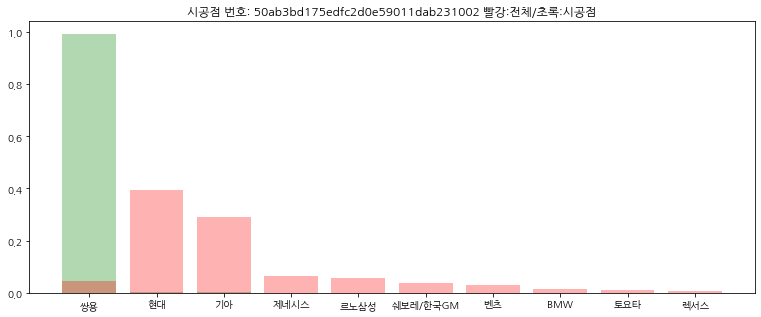

maker
쌍용    0.977099
르노    0.015267
현대    0.007634
Name: regist_dt, dtype: float64
total: 131


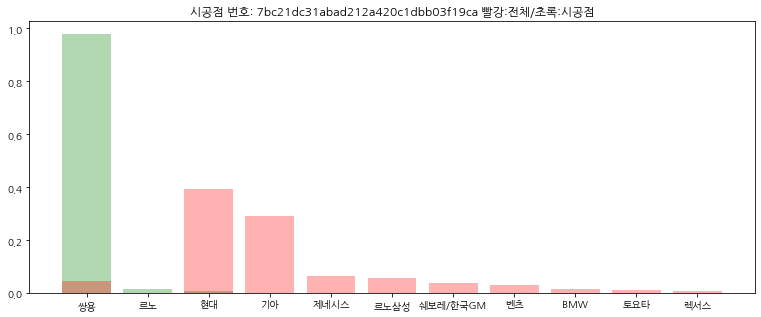

maker
쌍용    0.953846
기아    0.030769
르노    0.015385
Name: regist_dt, dtype: float64
total: 65


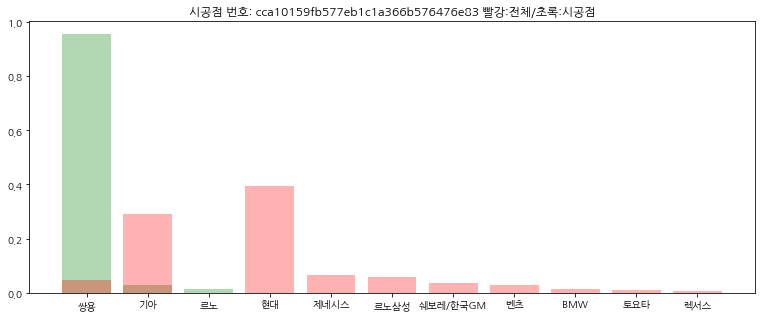

maker
쌍용    0.952381
기아    0.031746
현대    0.015873
Name: regist_dt, dtype: float64
total: 189


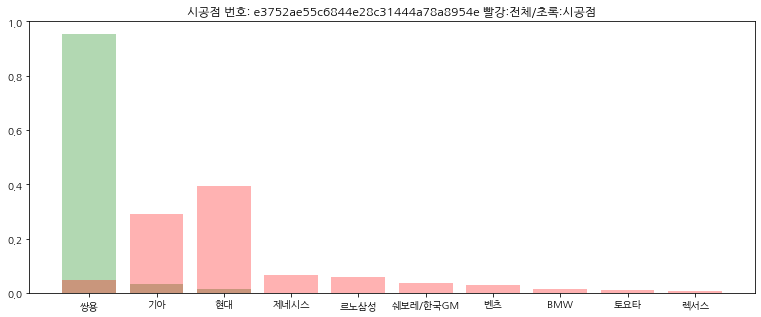

maker
쌍용      0.924
기아      0.056
현대      0.012
제네시스    0.004
르노      0.004
Name: regist_dt, dtype: float64
total: 250


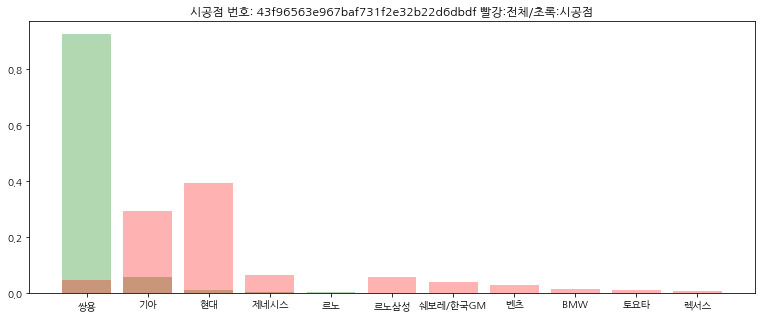

maker
쌍용      0.900000
기아      0.050000
현대      0.033333
제네시스    0.016667
Name: regist_dt, dtype: float64
total: 60


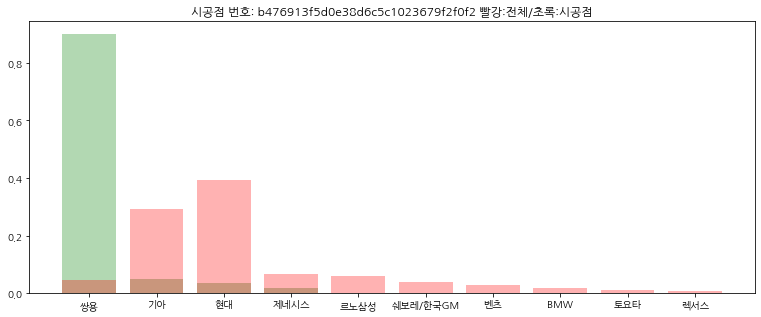

maker
쌍용    0.898305
르노    0.093220
기아    0.008475
Name: regist_dt, dtype: float64
total: 118


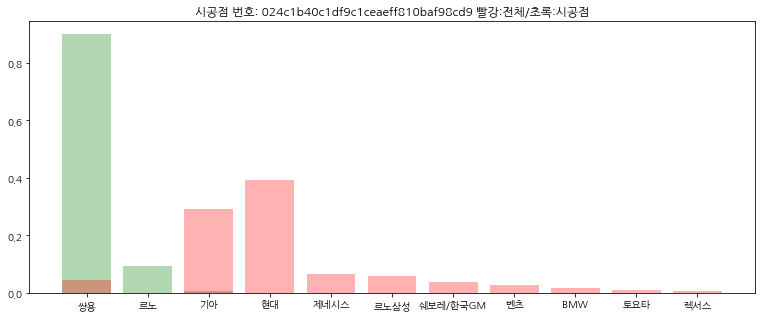

maker
쌍용          0.878298
기아          0.043404
현대          0.041702
르노삼성        0.011915
제네시스        0.007660
벤츠          0.005106
BMW         0.004255
쉐보레/한국GM    0.003404
아우디         0.001702
포드          0.000851
Name: regist_dt, dtype: float64
total: 1175


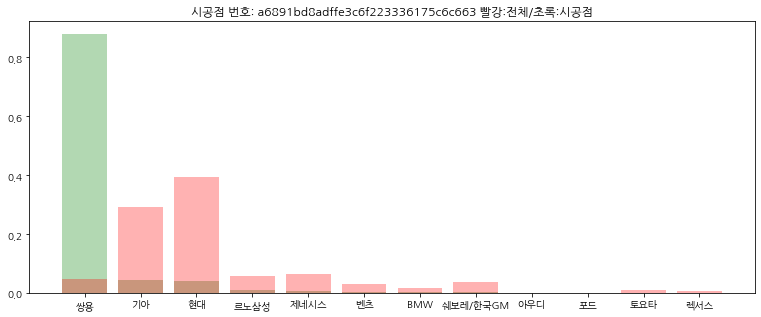

maker
쌍용      0.872727
르노      0.050000
현대      0.031818
기아      0.031818
르노삼성    0.009091
제네시스    0.004545
Name: regist_dt, dtype: float64
total: 220


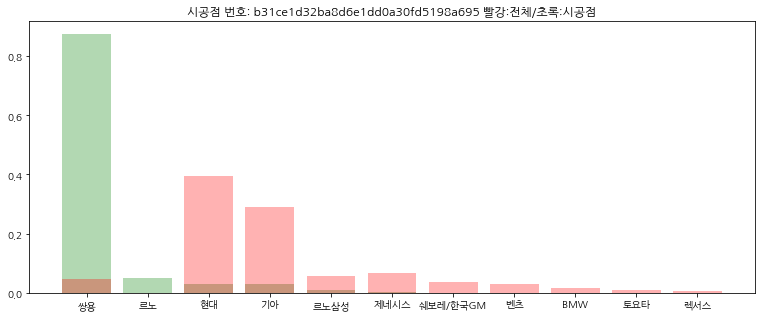

maker
쌍용          0.746781
기아          0.132189
현대          0.077253
제네시스        0.018026
르노삼성        0.010300
쉐보레/한국GM    0.004292
폭스바겐        0.002575
벤츠          0.001717
BMW         0.001717
포르쉐         0.000858
Name: regist_dt, dtype: float64
total: 1165


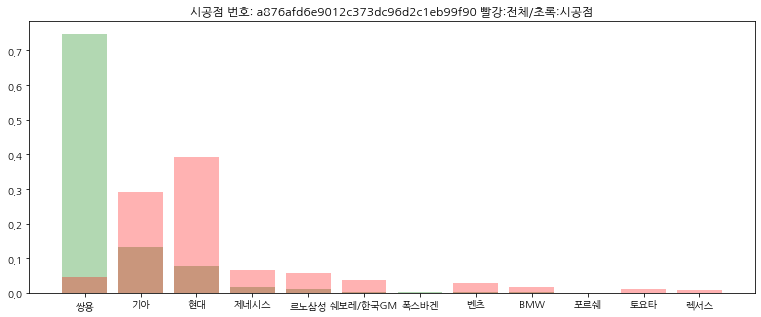

maker
쌍용          0.746424
기아          0.131339
현대          0.098830
제네시스        0.014304
폭스바겐        0.003901
쉐보레/한국GM    0.002601
르노삼성        0.002601
Name: regist_dt, dtype: float64
total: 769


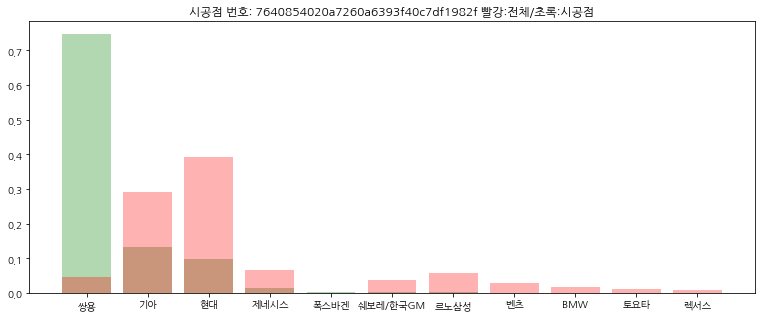

maker
쌍용          0.741071
현대          0.142857
기아          0.071429
르노          0.026786
제네시스        0.008929
쉐보레/한국GM    0.008929
Name: regist_dt, dtype: float64
total: 112


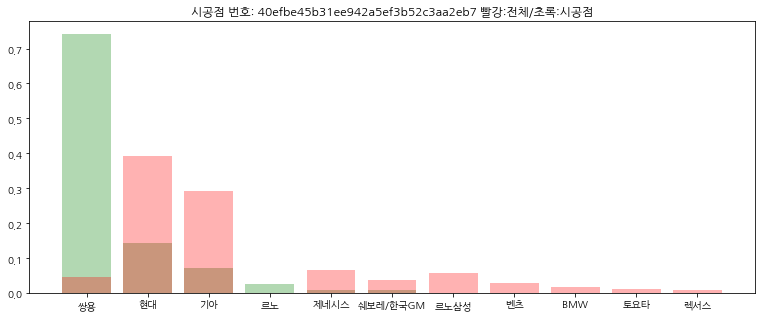

maker
쌍용      0.633803
현대      0.225352
기아      0.098592
제네시스    0.042254
Name: regist_dt, dtype: float64
total: 71


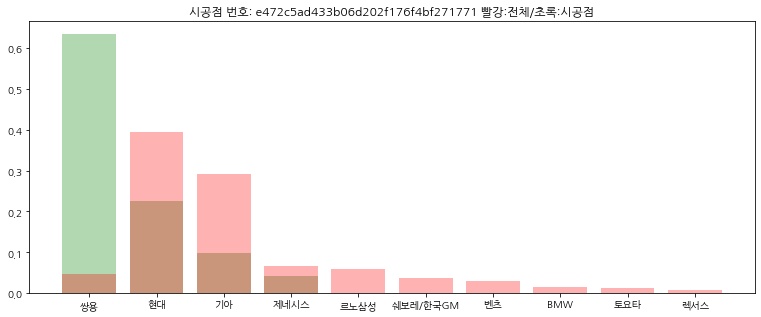

maker
쌍용          0.591549
쉐보레/한국GM    0.281690
현대          0.056338
제네시스        0.014085
아큐라         0.014085
쉐보레         0.014085
기아          0.014085
Name: regist_dt, dtype: float64
total: 71


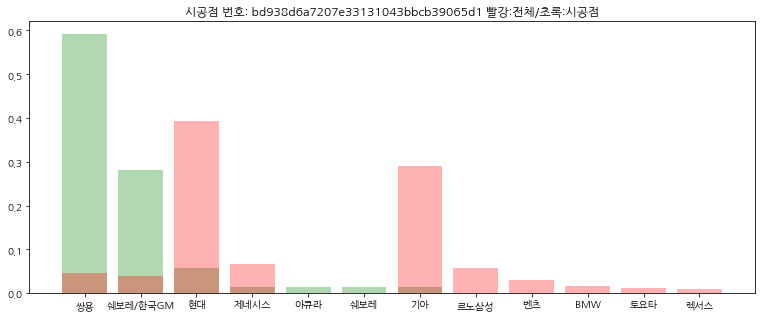

maker
쌍용          0.568376
쉐보레/한국GM    0.205128
쉐보레         0.136752
현대          0.038462
기아          0.021368
르노삼성        0.008547
폭스바겐        0.004274
포드          0.004274
르노          0.004274
Name: regist_dt, dtype: float64
total: 234


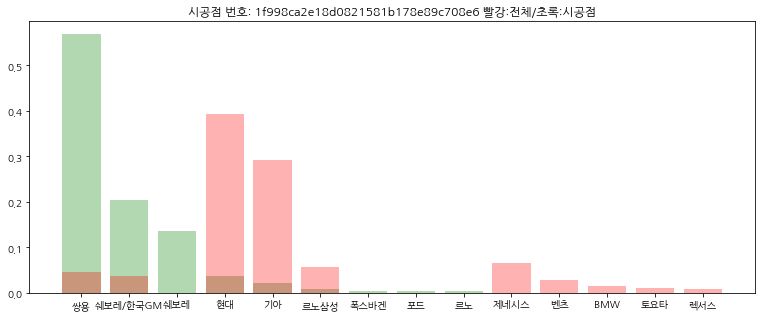

maker
쌍용          0.564240
현대          0.260171
기아          0.097430
제네시스        0.068522
쉐보레/한국GM    0.004283
아큐라         0.002141
벤츠          0.002141
르노삼성        0.001071
Name: regist_dt, dtype: float64
total: 934


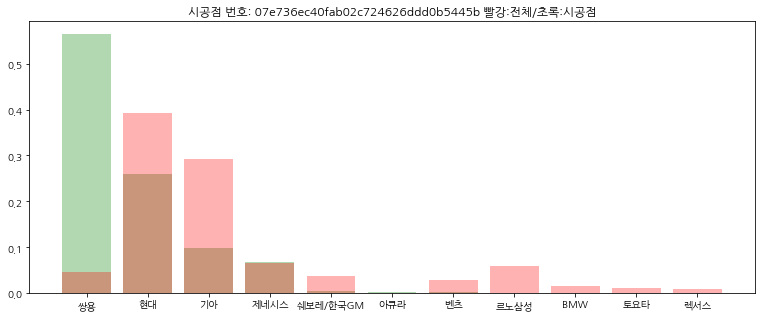

maker
쌍용      0.564103
현대      0.262821
기아      0.089744
제네시스    0.051282
르노삼성    0.025641
링컨      0.006410
Name: regist_dt, dtype: float64
total: 156


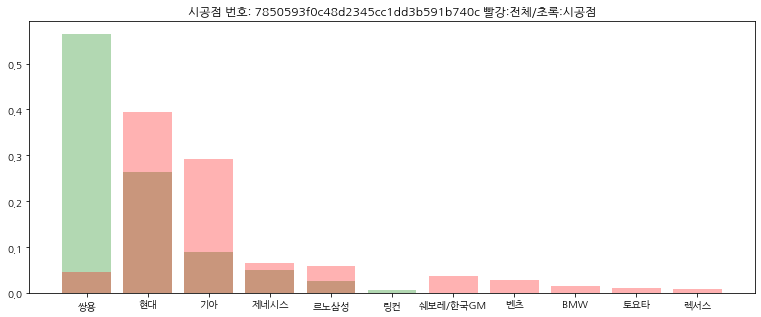

maker
쌍용      0.454545
현대      0.415584
기아      0.103896
제네시스    0.012987
BMW     0.012987
Name: regist_dt, dtype: float64
total: 77


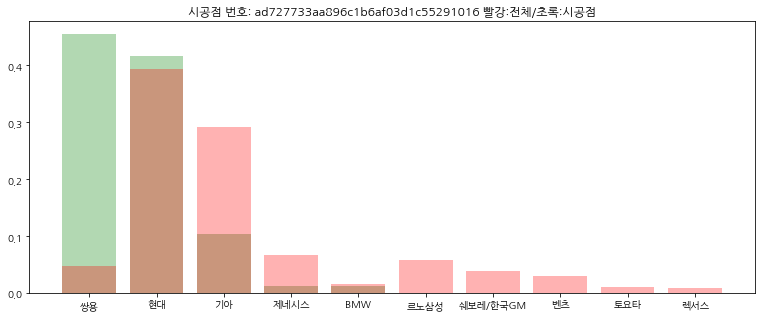

maker
쌍용          0.414894
현대          0.313830
기아          0.132979
쉐보레/한국GM    0.042553
제네시스        0.037234
르노삼성        0.021277
0           0.010638
아우디         0.005319
쉐보레         0.005319
미니          0.005319
Name: regist_dt, dtype: float64
total: 188


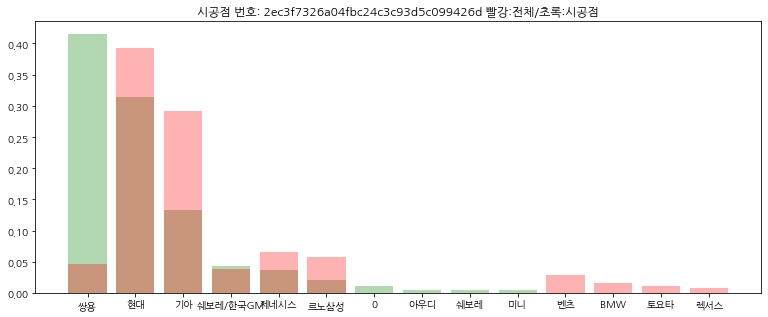

maker
쌍용          0.400000
현대          0.192857
기아          0.150000
쉐보레/한국GM    0.114286
르노삼성        0.042857
제네시스        0.035714
푸조          0.021429
토요타         0.014286
캐딜락         0.007143
벤츠          0.007143
Name: regist_dt, dtype: float64
total: 140


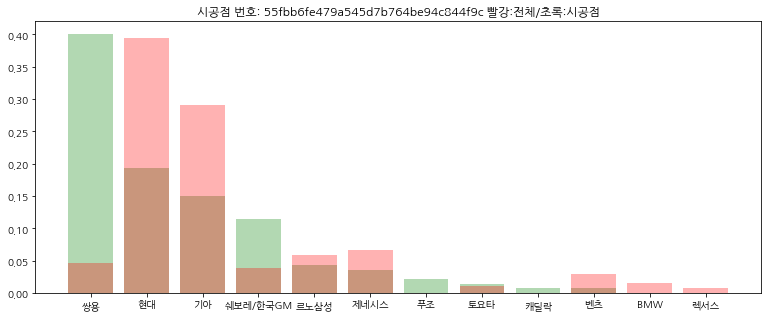

maker
쌍용      0.397959
기아      0.306122
현대      0.244898
제네시스    0.040816
르노삼성    0.010204
Name: regist_dt, dtype: float64
total: 98


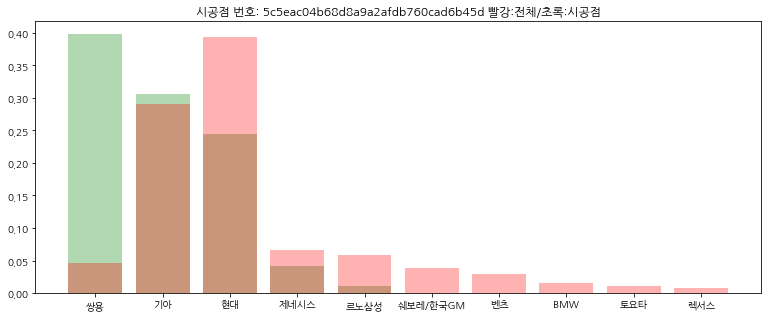

maker
현대          0.405862
쌍용          0.388952
기아          0.116122
제네시스        0.038331
르노삼성        0.019166
아우디         0.005637
벤츠          0.003382
쉐보레/한국GM    0.003382
닛산          0.002255
BMW         0.002255
Name: regist_dt, dtype: float64
total: 887


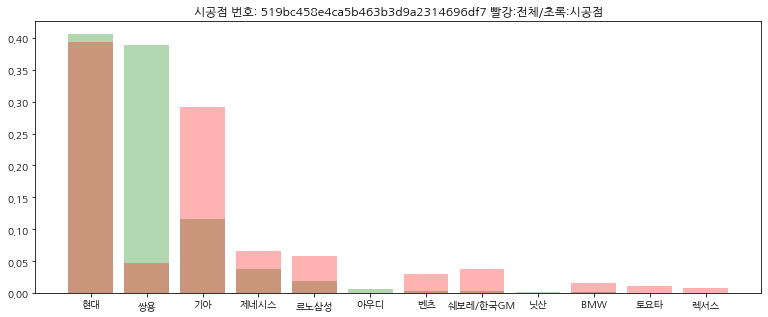

maker
쌍용          0.381910
기아          0.266332
현대          0.263819
제네시스        0.032663
쉐보레/한국GM    0.020101
르노삼성        0.015075
벤츠          0.007538
BMW         0.005025
폭스바겐        0.002513
아우디         0.002513
Name: regist_dt, dtype: float64
total: 398


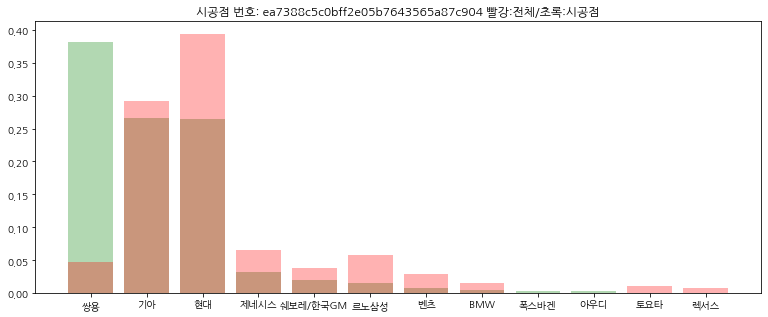

maker
르노삼성    0.441860
쌍용      0.377907
기아      0.087209
현대      0.081395
르노      0.011628
Name: regist_dt, dtype: float64
total: 172


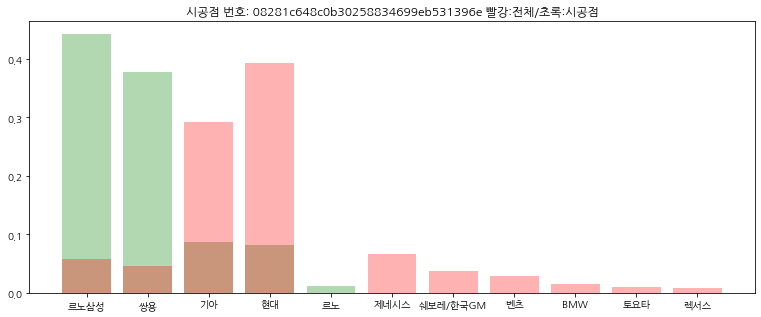

maker
르노삼성    0.494505
쌍용      0.373626
현대      0.054945
기아      0.043956
르노      0.021978
제네시스    0.010989
Name: regist_dt, dtype: float64
total: 182


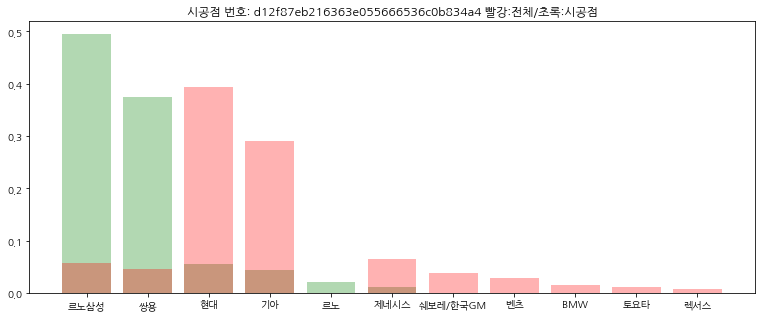

maker
쌍용          0.372093
기아          0.317829
쉐보레/한국GM    0.178295
현대          0.093023
제네시스        0.023256
쉐보레         0.007752
르노삼성        0.007752
Name: regist_dt, dtype: float64
total: 129


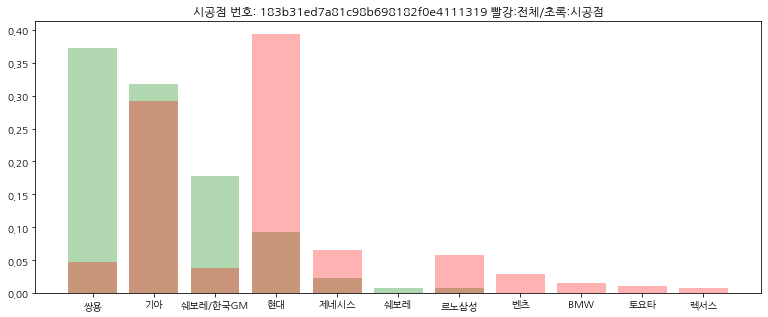

maker
기아    0.405941
쌍용    0.366337
현대    0.227723
Name: regist_dt, dtype: float64
total: 101


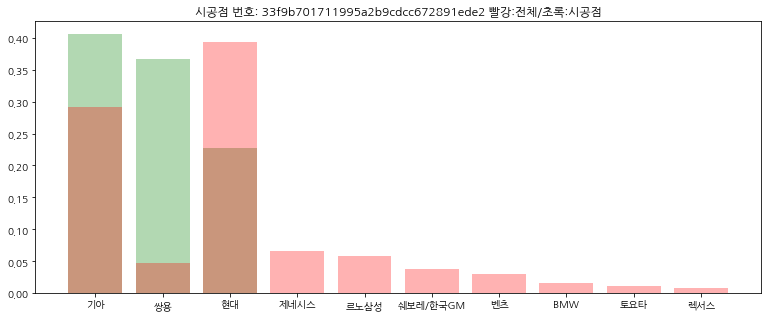

maker
쌍용          0.357143
현대          0.303571
기아          0.303571
혼다          0.017857
쉐보레/한국GM    0.017857
Name: regist_dt, dtype: float64
total: 56


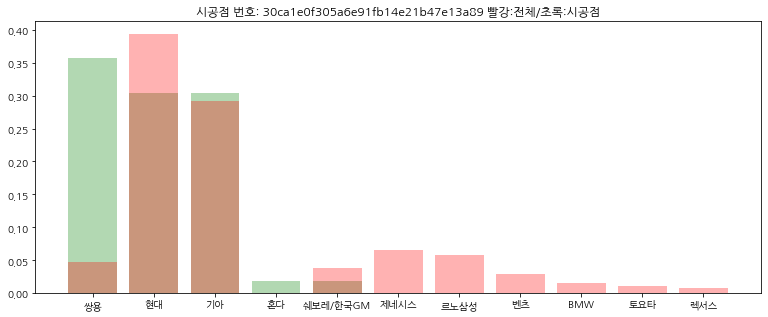

maker
현대          0.351852
쌍용          0.333333
기아          0.111111
쉐보레/한국GM    0.074074
제네시스        0.055556
BMW         0.037037
홀덴          0.018519
닛산          0.018519
Name: regist_dt, dtype: float64
total: 54


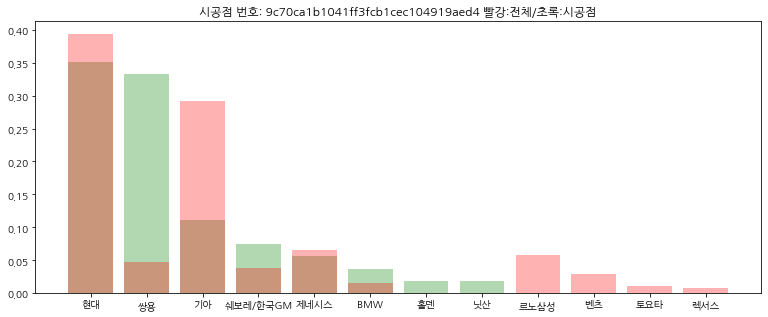

maker
기아          0.339744
쌍용          0.320513
현대          0.288462
제네시스        0.032051
쉐보레/한국GM    0.006410
르노삼성        0.006410
르노          0.006410
Name: regist_dt, dtype: float64
total: 156


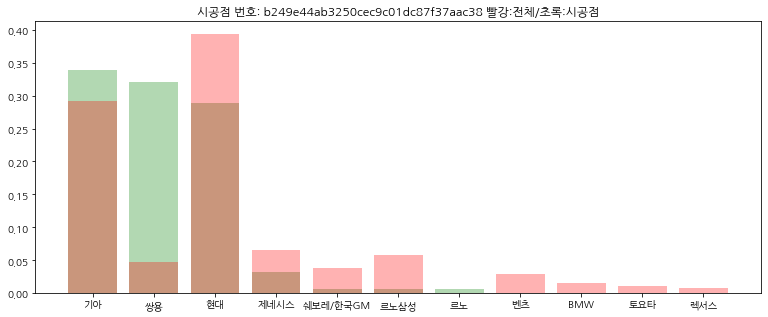

In [129]:
for i in makerXstore('쌍용').store:
  vis_counts(i)

## 벤츠

In [133]:
makerXstore('벤츠')

store  ... percentage
3     fdf03abd6b6550637798e7ec9cb527fe  ...   1.000000
597   d400b029f0bdf83012d65f4f598fd8f7  ...   0.988764
132   9350d99198676f7def676af955ad5fd0  ...   0.972565
521   ac2aec5fecce163e43efa0ed502da2f4  ...   0.971552
215   f93b6802defdb40c90ac377ab0025de5  ...   0.962121
821   635fe6a1a1682e388d85aac48fec0cce  ...   0.824194
1263  fd98cb0a5975ad7d2dc23534ed73eb21  ...   0.726891
154   5d69bf87c3109f378801b30f63e110c0  ...   0.684211
335   06c11979837de24f912f932e60219eef  ...   0.505155
191   8e5bb016e2cc17facfe4288d45c25917  ...   0.381879
1001  4b662724fcec9daedb68917760aa5e15  ...   0.312690
488   470924011e7337833d28a8c8bba49ad5  ...   0.312127
690   a9abe3dec687616780e7a1bf28f961c9  ...   0.291300
663   d8d33b6bcddd03ef8b7758654c971af1  ...   0.283784
699   461fa55291e22de831a424f6877b5a94  ...   0.265683
1030  317b59cfa206a293cc1612e235f911ca  ...   0.207742
576   94e50b82687350e05e5d8b4dc8a88f9e  ...   0.195402
408   012ab097e97e103b1e6f8c196da7a875  ...   0.191832
677   272d837ab3b0f5dbaaa85f21ec6de1ae  ...   0.183036
972   32ab906cb9e2e7886a576e58eefe451f  ...   0.151596
184   70b9851a499fe76de792ddd4a88b612c  ...   0.141593
568   d8239b75ed2a3ad8f8f0da59e28577c5  ...   0.139303
909   460c01c006892a34767077557efa73eb  ...   0.126984
1113  872c833988b6117cf7569c3a73da4b62  ...   0.125000
639   3c52ee815c1ec3e1f125af27fa1bbea6  ...   0.113402
134   cb9cd66ba7f5fc870352f07ee4bf59ee  ...   0.105012
365   686866bf22425f1832e1d1984eda5fb6  ...   0.100623
1268  2b63d707b834f0c0d9a7359fffe2df9f  ...   0.097222
1029  730a24f76cb9b3fff977ea0ffa3ca865  ...   0.093468
782   6deef0b5f1d3ec43328149ff73f6f677  ...   0.090909

[30 rows x 4 columns]

maker
벤츠    0.992537
Name: regist_dt, dtype: float64
total: 134


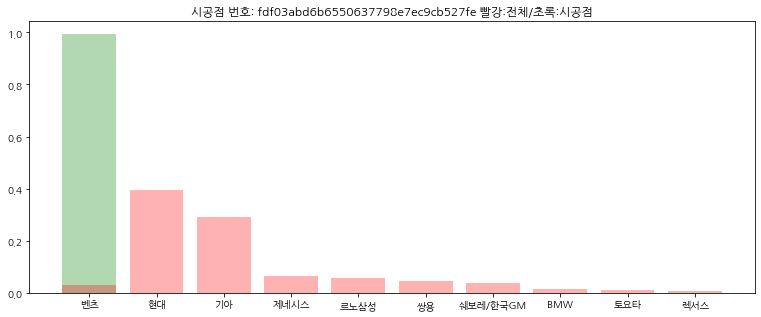

maker
벤츠     0.988764
BMW    0.011236
Name: regist_dt, dtype: float64
total: 89


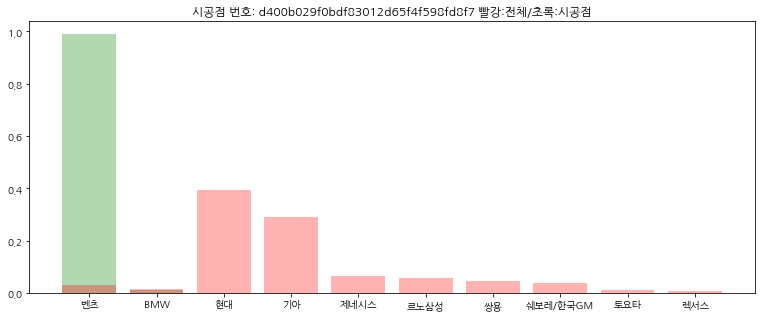

maker
벤츠      0.971233
현대      0.010959
기아      0.008219
폭스바겐    0.002055
링컨      0.001370
포드      0.000685
테슬라     0.000685
지프      0.000685
르노삼성    0.000685
렉서스     0.000685
Name: regist_dt, dtype: float64
total: 1460


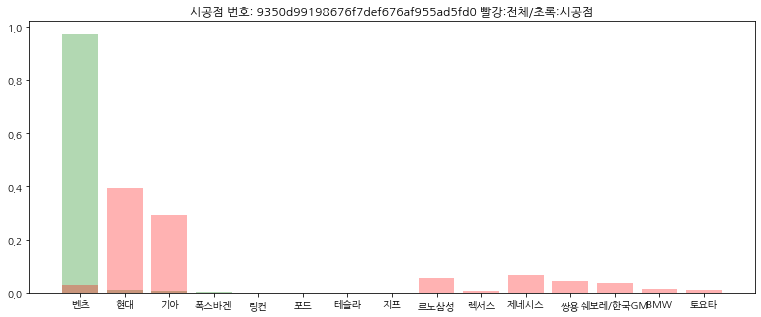

maker
벤츠          0.971552
기아          0.009483
현대          0.006897
BMW         0.003448
제네시스        0.001724
쌍용          0.001724
쉐보레/한국GM    0.001724
랜드로버        0.001724
포드          0.000862
볼보          0.000862
Name: regist_dt, dtype: float64
total: 1160


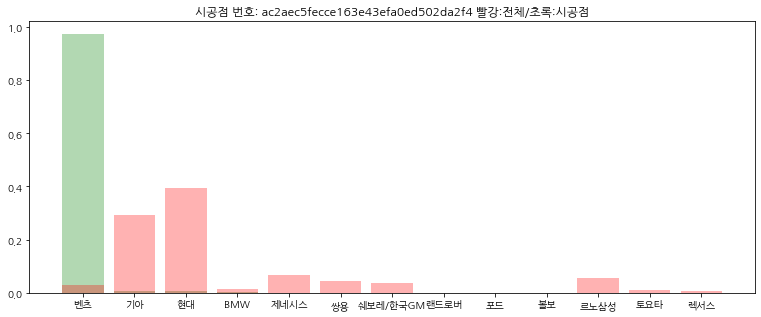

maker
벤츠      0.947761
폭스바겐    0.014925
기아      0.007463
BMW     0.007463
0       0.007463
Name: regist_dt, dtype: float64
total: 134


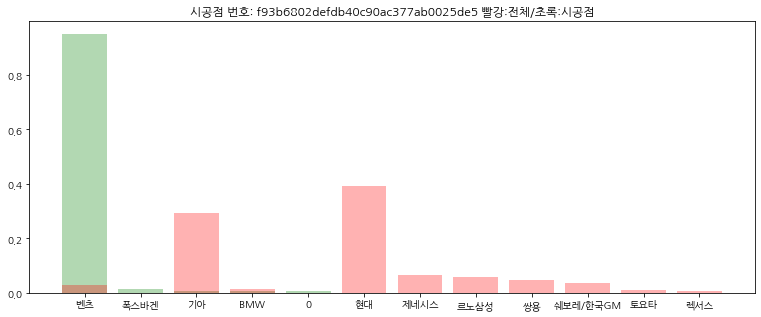

maker
벤츠          0.823751
BMW         0.074154
렉서스         0.057496
현대          0.011822
기아          0.009135
쉐보레/한국GM    0.003224
제네시스        0.002687
미니          0.002687
랜드로버        0.002687
재규어         0.001612
Name: regist_dt, dtype: float64
total: 1861


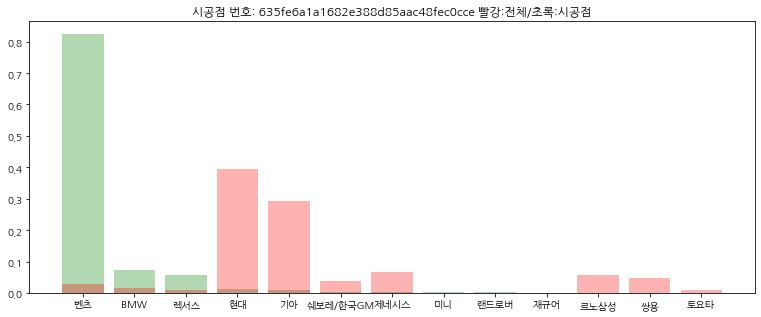

maker
벤츠      0.723849
아우디     0.087866
현대      0.054393
기아      0.033473
제네시스    0.016736
폭스바겐    0.012552
렉서스     0.012552
BMW     0.012552
볼보      0.008368
랜드로버    0.008368
Name: regist_dt, dtype: float64
total: 239


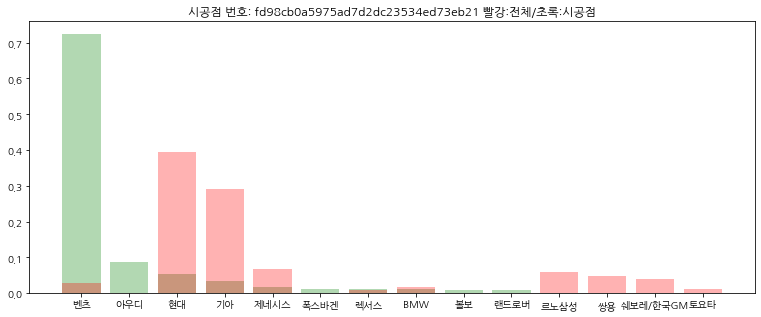

maker
벤츠     0.675325
아우디    0.142857
캐딜락    0.090909
포르쉐    0.064935
렉서스    0.012987
Name: regist_dt, dtype: float64
total: 77


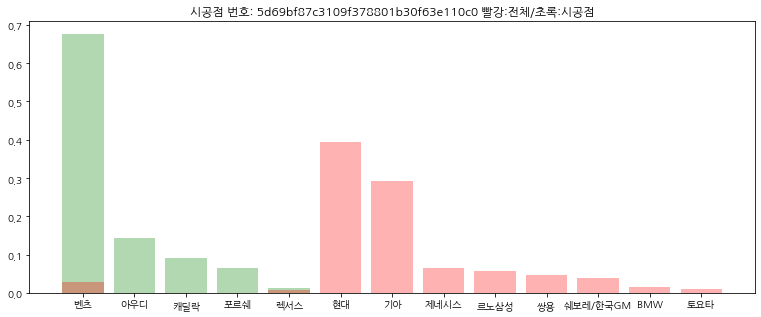

maker
벤츠          0.500000
현대          0.193878
기아          0.173469
르노삼성        0.051020
제네시스        0.020408
쉐보레/한국GM    0.020408
쌍용          0.010204
렉서스         0.010204
BMW         0.010204
Name: regist_dt, dtype: float64
total: 98


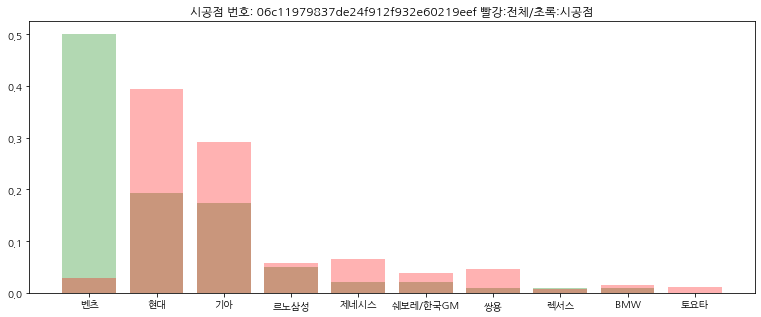

maker
벤츠      0.381879
볼보      0.206226
렉서스     0.185659
현대      0.045581
기아      0.035019
BMW     0.022790
랜드로버    0.020011
제네시스    0.018344
미니      0.017232
링컨      0.011117
Name: regist_dt, dtype: float64
total: 1799


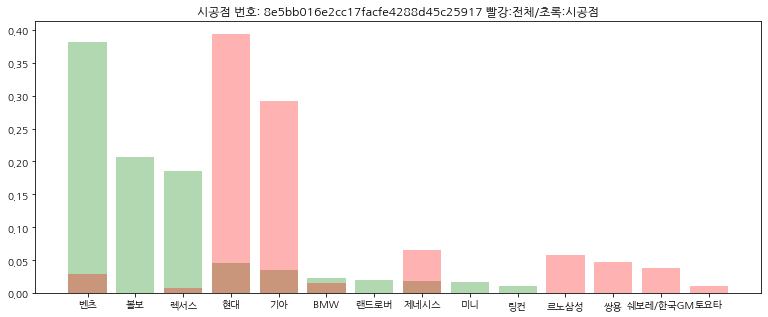

maker
BMW     0.425101
벤츠      0.311741
볼보      0.076923
포르쉐     0.027328
렉서스     0.026316
미니      0.024291
아우디     0.017206
제네시스    0.016194
현대      0.015182
지프      0.014170
Name: regist_dt, dtype: float64
total: 988


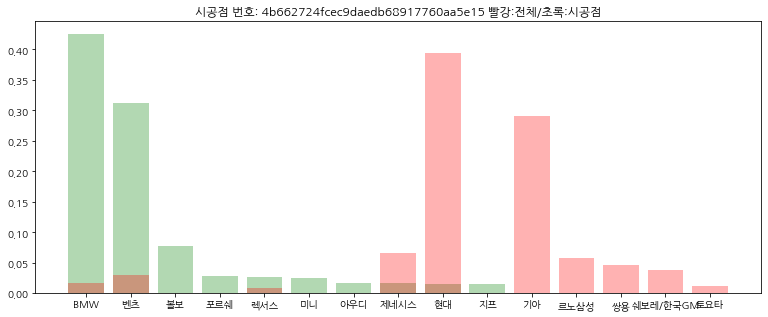

maker
벤츠      0.311508
토요타     0.174603
현대      0.130952
기아      0.091270
제네시스    0.065476
BMW     0.043651
볼보      0.029762
렉서스     0.023810
아우디     0.019841
미니      0.015873
Name: regist_dt, dtype: float64
total: 504


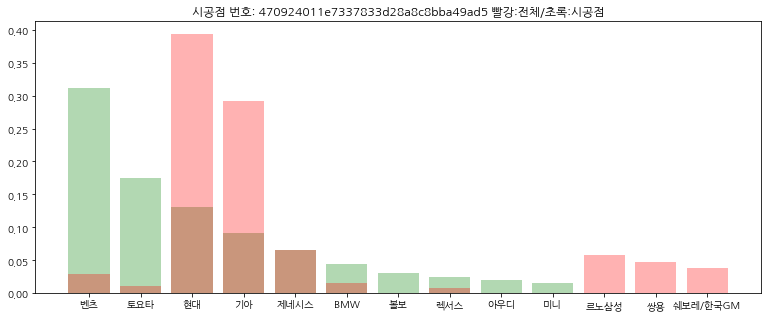

maker
벤츠          0.290732
기아          0.213659
현대          0.151220
쌍용          0.063415
제네시스        0.040000
BMW         0.037073
쉐보레/한국GM    0.035122
렉서스         0.033171
아우디         0.021463
르노삼성        0.015610
Name: regist_dt, dtype: float64
total: 1025


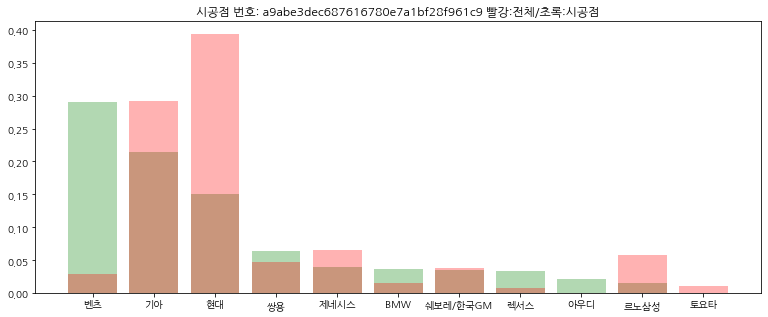

maker
벤츠          0.283358
기아          0.274363
현대          0.208396
포드          0.041229
제네시스        0.035982
르노삼성        0.032984
BMW         0.030735
쌍용          0.017241
링컨          0.017241
쉐보레/한국GM    0.016492
Name: regist_dt, dtype: float64
total: 1334


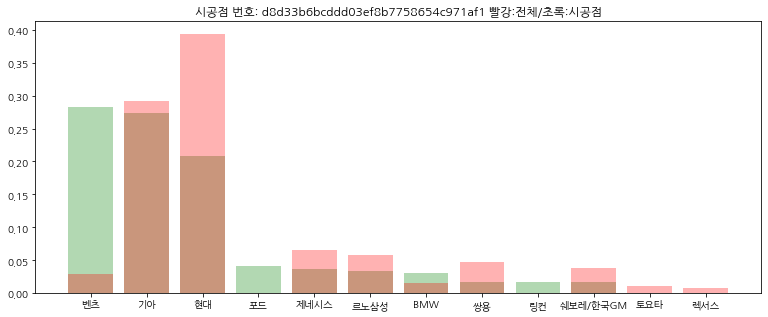

maker
벤츠      0.265683
현대      0.147601
폭스바겐    0.099631
푸조      0.081181
토요타     0.081181
기아      0.070111
BMW     0.051661
렉서스     0.033210
아우디     0.018450
볼보      0.014760
Name: regist_dt, dtype: float64
total: 271


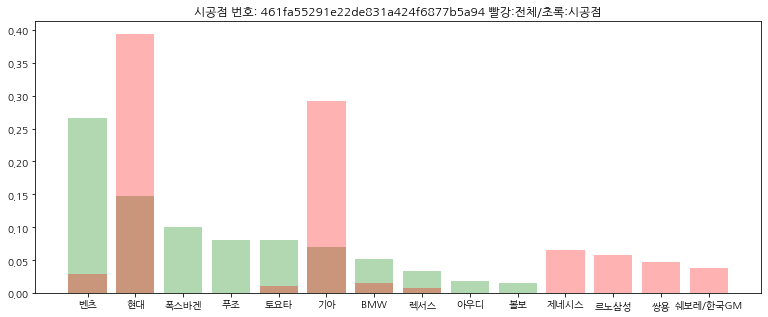

maker
현대          0.210425
벤츠          0.207207
기아          0.115830
제네시스        0.090090
BMW         0.081725
테슬라         0.050193
포르쉐         0.034749
아우디         0.026384
볼보          0.024453
쉐보레/한국GM    0.018018
Name: regist_dt, dtype: float64
total: 1554


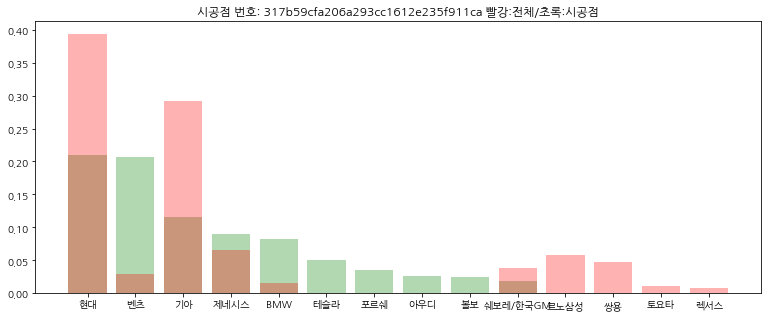

maker
현대      0.206304
벤츠      0.194842
기아      0.100287
제네시스    0.100287
BMW     0.091691
렉서스     0.065903
아우디     0.028653
랜드로버    0.022923
토요타     0.022923
르노삼성    0.017192
Name: regist_dt, dtype: float64
total: 349


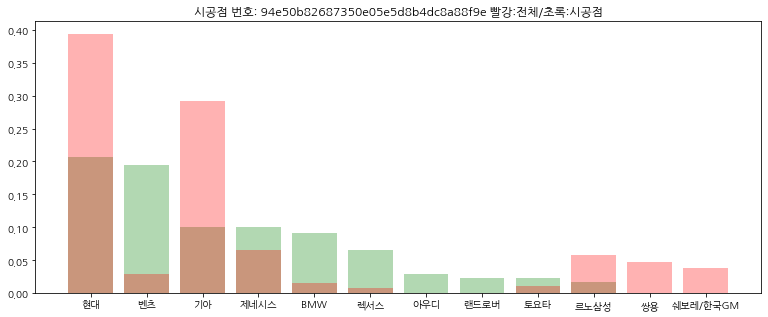

maker
현대      0.241038
벤츠      0.191595
기아      0.106304
제네시스    0.096415
볼보      0.066749
BMW     0.050680
포르쉐     0.027194
아우디     0.027194
렉서스     0.022250
르노삼성    0.022250
Name: regist_dt, dtype: float64
total: 809


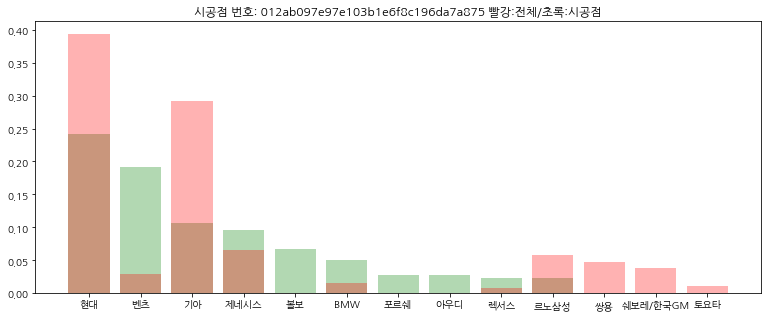

maker
BMW         0.232143
현대          0.191964
벤츠          0.183036
기아          0.098214
폭스바겐        0.075893
제네시스        0.031250
볼보          0.031250
쉐보레/한국GM    0.026786
포르쉐         0.022321
아우디         0.022321
Name: regist_dt, dtype: float64
total: 224


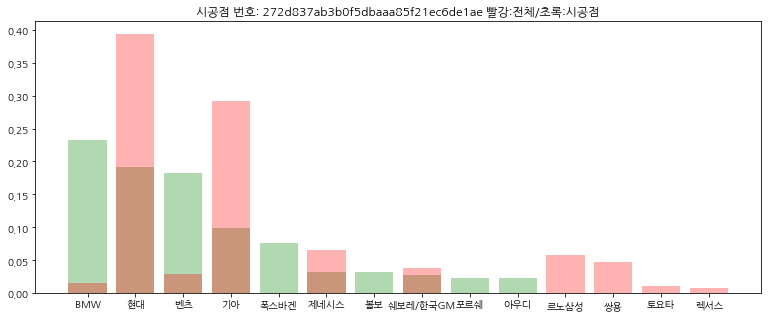

maker
현대          0.486702
기아          0.186170
벤츠          0.151596
제네시스        0.042553
르노삼성        0.042553
BMW         0.018617
아우디         0.013298
쌍용          0.013298
스마트         0.013298
쉐보레/한국GM    0.013298
Name: regist_dt, dtype: float64
total: 376


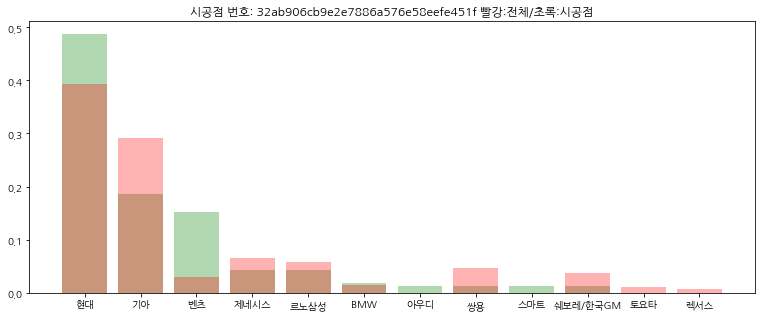

maker
현대      0.153348
벤츠      0.138229
BMW     0.084233
비이스만    0.066955
제네시스    0.060475
GMC     0.049676
기아      0.047516
링컨      0.045356
볼보      0.034557
닷지      0.030238
Name: regist_dt, dtype: float64
total: 463


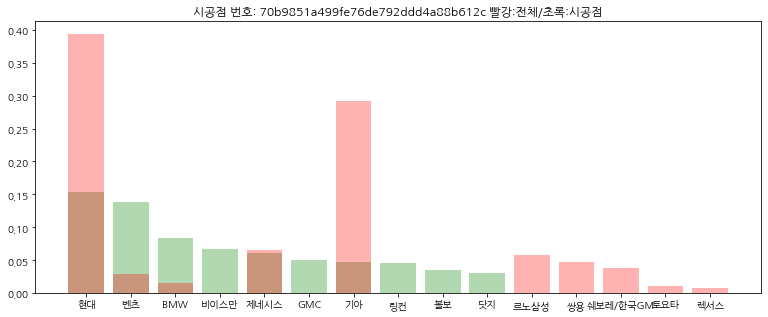

maker
현대          0.331683
쌍용          0.222772
기아          0.148515
벤츠          0.138614
제네시스        0.044554
랜드로버        0.024752
르노삼성        0.019802
폭스바겐        0.014851
쉐보레/한국GM    0.014851
렉서스         0.009901
Name: regist_dt, dtype: float64
total: 202


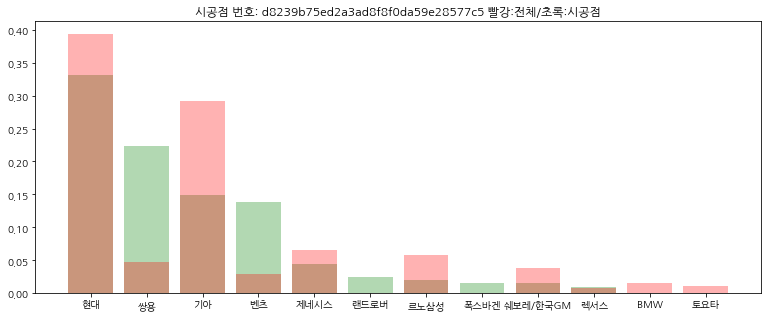

maker
기아          0.406250
현대          0.296875
벤츠          0.125000
쉐보레/한국GM    0.046875
르노삼성        0.046875
폭스바겐        0.015625
제네시스        0.015625
쌍용          0.015625
랜드로버        0.015625
Name: regist_dt, dtype: float64
total: 64


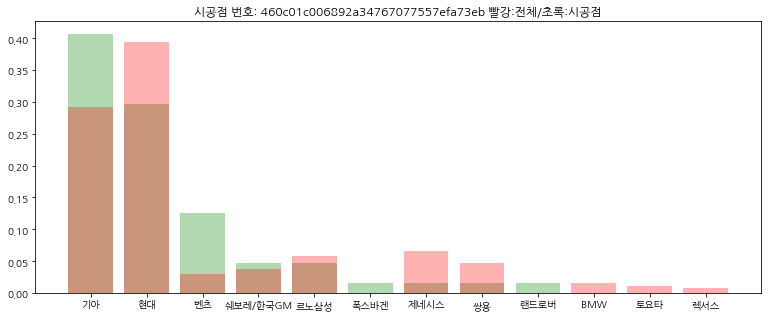

maker
현대          0.214286
기아          0.202381
BMW         0.154762
벤츠          0.125000
아우디         0.071429
쌍용          0.053571
르노삼성        0.035714
제네시스        0.029762
쉐보레/한국GM    0.029762
랜드로버        0.017857
Name: regist_dt, dtype: float64
total: 168


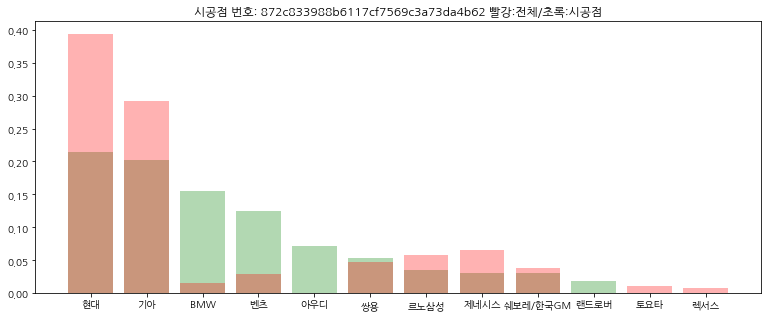

maker
기아          0.340206
현대          0.175258
BMW         0.113402
벤츠          0.113402
폭스바겐        0.051546
제네시스        0.030928
쉐보레/한국GM    0.030928
르노삼성        0.020619
포르쉐         0.020619
아우디         0.020619
Name: regist_dt, dtype: float64
total: 97


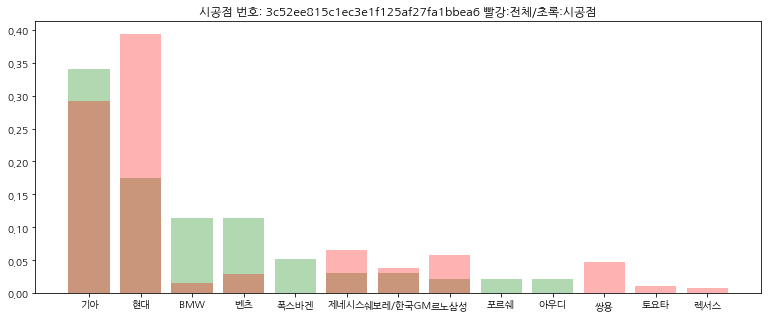

maker
현대          0.255924
기아          0.146919
BMW         0.113744
벤츠          0.104265
제네시스        0.068720
볼보          0.037915
르노삼성        0.035545
쌍용          0.028436
테슬라         0.023697
쉐보레/한국GM    0.023697
Name: regist_dt, dtype: float64
total: 422


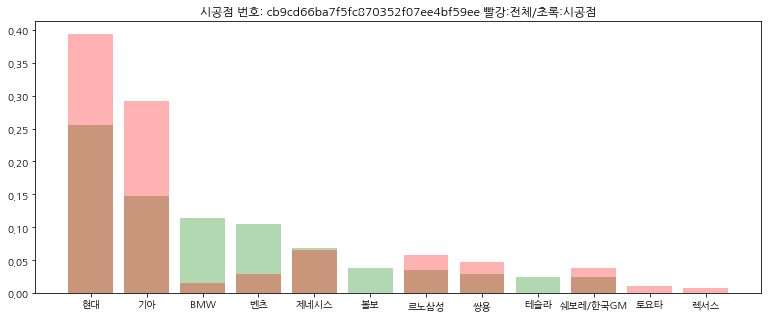

maker
현대          0.466607
쉐보레/한국GM    0.121104
벤츠          0.100623
기아          0.081923
제네시스        0.069457
쌍용          0.066785
르노삼성        0.053428
렉서스         0.007124
아큐라         0.007124
BMW         0.006233
Name: regist_dt, dtype: float64
total: 1123


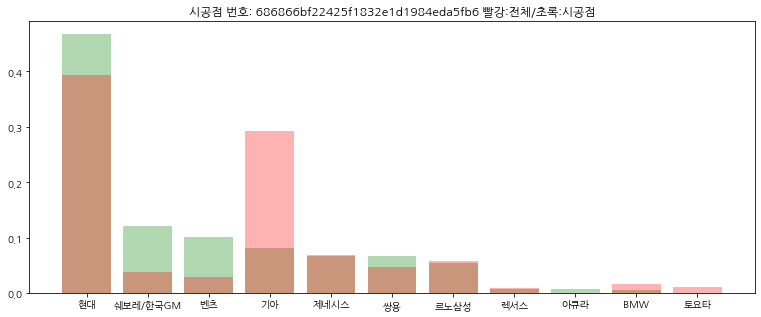

maker
현대      0.232877
테슬라     0.136986
제네시스    0.109589
벤츠      0.095890
기아      0.095890
르노삼성    0.068493
렉서스     0.041096
BMW     0.041096
토요타     0.027397
아우디     0.027397
Name: regist_dt, dtype: float64
total: 73


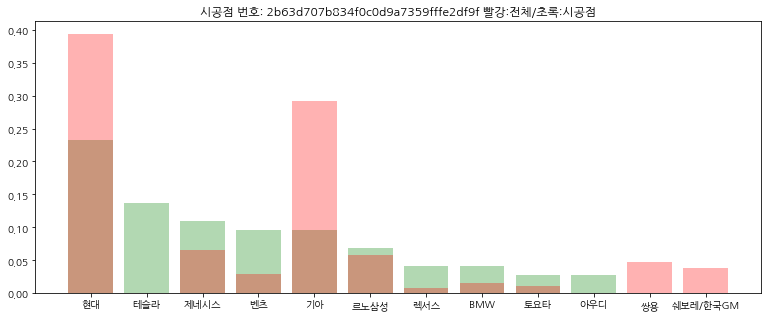

maker
현대          0.273850
기아          0.173962
BMW         0.114478
벤츠          0.093154
제네시스        0.067340
르노삼성        0.044893
볼보          0.044893
쉐보레/한국GM    0.031425
폭스바겐        0.023569
포르쉐         0.023569
Name: regist_dt, dtype: float64
total: 891


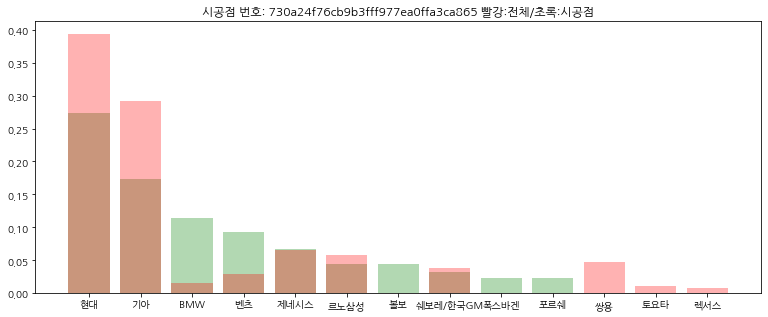

maker
현대      0.188873
BMW     0.185944
기아      0.130307
벤츠      0.090776
르노삼성    0.086384
렉서스     0.062958
아우디     0.045388
혼다      0.042460
푸조      0.039531
제네시스    0.030747
Name: regist_dt, dtype: float64
total: 683


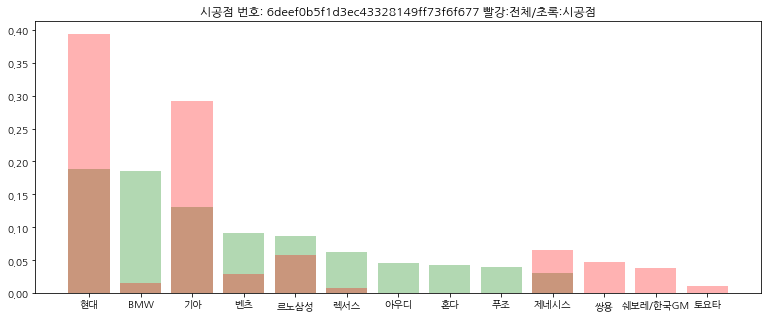

In [134]:
for i in makerXstore('벤츠').store:
  vis_counts(i)

## BMW

In [135]:
makerXstore('BMW')

store  ... percentage
1246  d39fa2f90dd3263e168d728211086116  ...   0.726804
1001  4b662724fcec9daedb68917760aa5e15  ...   0.426396
1196  ee9e2f46ae9d01e3f86b3fce9e3d2c02  ...   0.341615
429   602e7722acea1e16c10f31f1c25b6c45  ...   0.339950
888   4d9e72cb00ddffcf6b93d2824df49743  ...   0.253896
677   272d837ab3b0f5dbaaa85f21ec6de1ae  ...   0.232143
261   4520c72319bff204692da0e2150be64c  ...   0.211538
782   6deef0b5f1d3ec43328149ff73f6f677  ...   0.186217
577   6b2eeb9efcb2b4cbbf8891b921cf5f7b  ...   0.175549
1077  9de7eb8f69d3b787d450055644cef86f  ...   0.160000
1113  872c833988b6117cf7569c3a73da4b62  ...   0.154762
979   3c64792a156c69569e447611eb3f3ecb  ...   0.152542
410   febd7bdfd043d57e26008099c6b58b1a  ...   0.136752
1029  730a24f76cb9b3fff977ea0ffa3ca865  ...   0.114865
134   cb9cd66ba7f5fc870352f07ee4bf59ee  ...   0.114558
639   3c52ee815c1ec3e1f125af27fa1bbea6  ...   0.113402
1017  1aacad79e70da27ee3d94b215a6c3515  ...   0.105455
1153  259451cb86939f83a15ce6aa7d5fb150  ...   0.097800
1018  a24a8e16d3e119a23aec7807308b37a3  ...   0.092593
232   d2d295c40ee874f6c3f409f0ad543090  ...   0.092308
576   94e50b82687350e05e5d8b4dc8a88f9e  ...   0.091954
974   441b1112364f3e0dafb918813e36b26d  ...   0.089695
966   414e3911782882f3ca1917d369cc9846  ...   0.086517
184   70b9851a499fe76de792ddd4a88b612c  ...   0.086283
432   c2a1081e336d954bfe5337b691ebbf66  ...   0.083736
1030  317b59cfa206a293cc1612e235f911ca  ...   0.081935
1059  43bed24222d9fd7beb84b0c24e067f12  ...   0.079114
1072  04be1cca3fa1591a2002564173c857b0  ...   0.077778
1043  115af758daf7c212b39f0bef0c98cae6  ...   0.077170
821   635fe6a1a1682e388d85aac48fec0cce  ...   0.074194

[30 rows x 4 columns]

maker
BMW         0.705
현대          0.075
미니          0.045
기아          0.045
아우디         0.015
쌍용          0.015
벤츠          0.015
르노삼성        0.015
제네시스        0.010
쉐보레/한국GM    0.010
Name: regist_dt, dtype: float64
total: 200


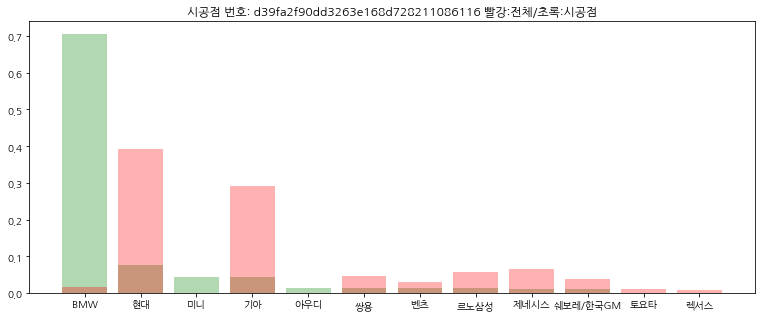

maker
BMW     0.425101
벤츠      0.311741
볼보      0.076923
포르쉐     0.027328
렉서스     0.026316
미니      0.024291
아우디     0.017206
제네시스    0.016194
현대      0.015182
지프      0.014170
Name: regist_dt, dtype: float64
total: 988


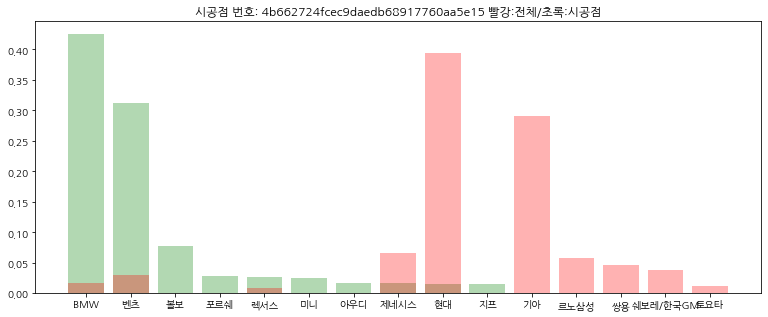

maker
BMW     0.341615
토요타     0.329193
현대      0.062112
기아      0.062112
벤츠      0.043478
랜드로버    0.031056
테슬라     0.024845
제네시스    0.024845
르노삼성    0.012422
혼다      0.012422
Name: regist_dt, dtype: float64
total: 161


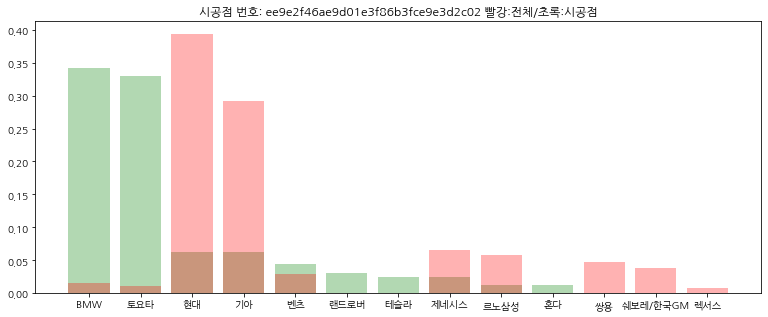

maker
BMW     0.338272
혼다      0.167901
현대      0.164198
기아      0.096296
벤츠      0.033333
제네시스    0.028395
렉서스     0.017284
랜드로버    0.014815
르노삼성    0.014815
볼보      0.012346
Name: regist_dt, dtype: float64
total: 810


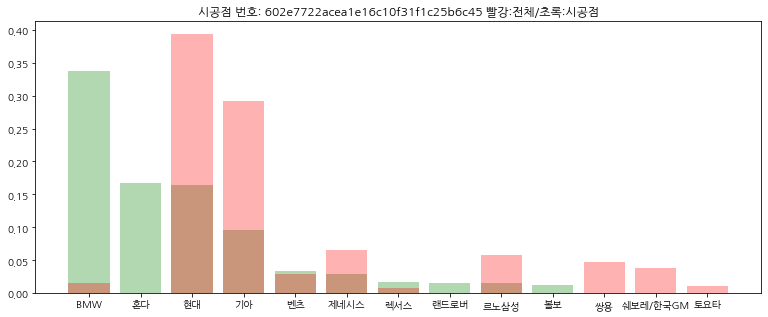

maker
현대          0.370130
BMW         0.253896
기아          0.125325
벤츠          0.083117
제네시스        0.081169
포르쉐         0.025974
쉐보레/한국GM    0.012338
쌍용          0.009091
마세라티        0.004545
폭스바겐        0.004545
Name: regist_dt, dtype: float64
total: 1540


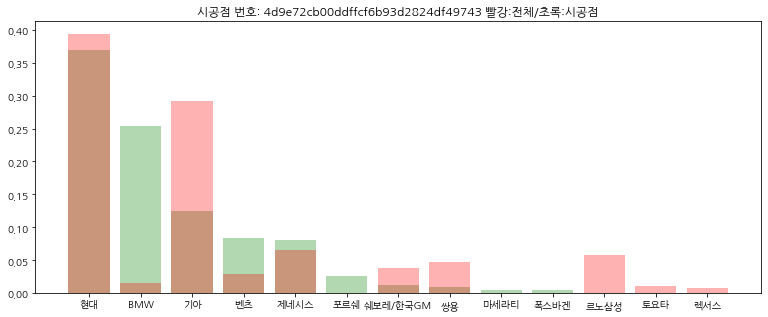

maker
BMW         0.232143
현대          0.191964
벤츠          0.183036
기아          0.098214
폭스바겐        0.075893
제네시스        0.031250
볼보          0.031250
쉐보레/한국GM    0.026786
포르쉐         0.022321
아우디         0.022321
Name: regist_dt, dtype: float64
total: 224


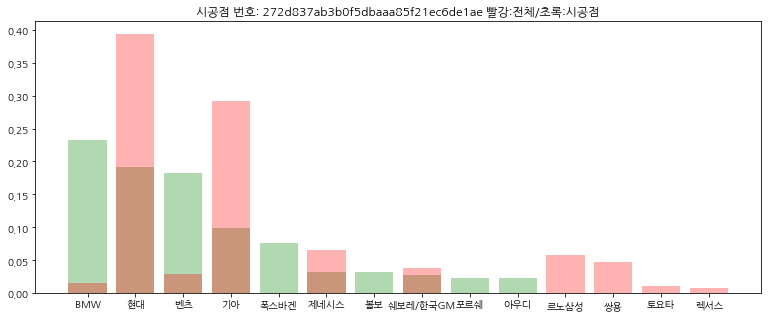

maker
BMW         0.211538
현대          0.192308
기아          0.153846
폭스바겐        0.076923
아우디         0.076923
벤츠          0.076923
제네시스        0.057692
포르쉐         0.019231
쌍용          0.019231
쉐보레/한국GM    0.019231
Name: regist_dt, dtype: float64
total: 52


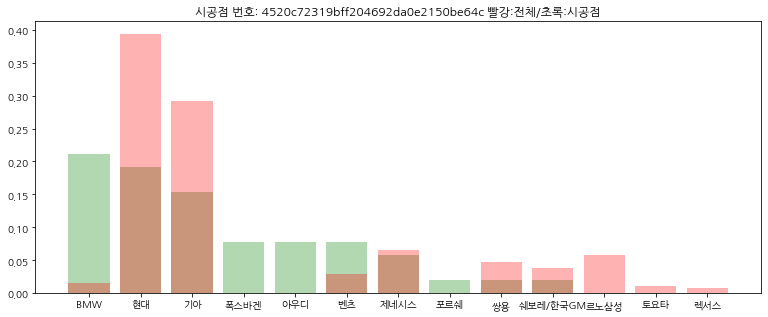

maker
현대      0.188873
BMW     0.185944
기아      0.130307
벤츠      0.090776
르노삼성    0.086384
렉서스     0.062958
아우디     0.045388
혼다      0.042460
푸조      0.039531
제네시스    0.030747
Name: regist_dt, dtype: float64
total: 683


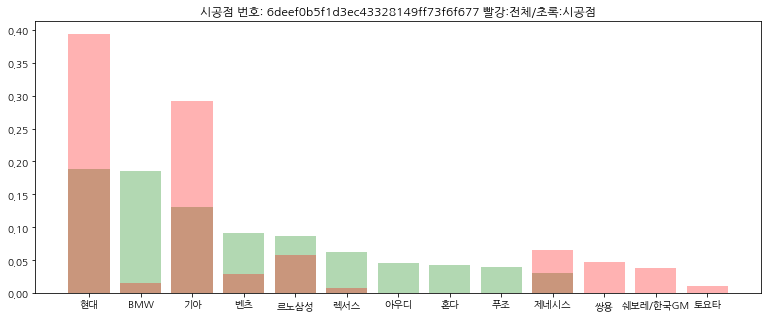

maker
현대          0.347962
기아          0.225705
BMW         0.175549
제네시스        0.109718
벤츠          0.047022
르노삼성        0.034483
쌍용          0.012539
쉐보레/한국GM    0.009404
푸조          0.006270
폭스바겐        0.006270
Name: regist_dt, dtype: float64
total: 319


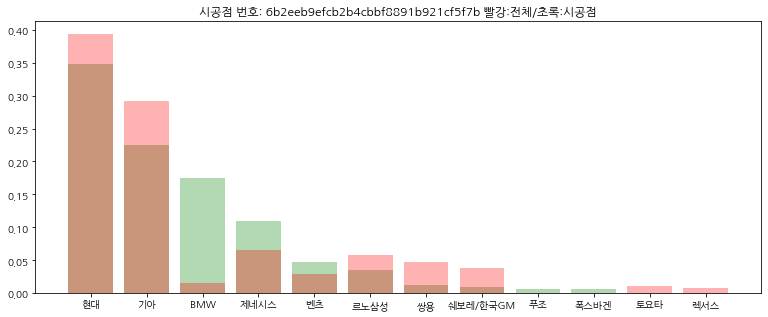

maker
BMW     0.160000
아우디     0.156364
기아      0.138182
포르쉐     0.134545
현대      0.125455
포드      0.063636
벤츠      0.050909
링컨      0.041818
르노삼성    0.029091
렉서스     0.020000
Name: regist_dt, dtype: float64
total: 550


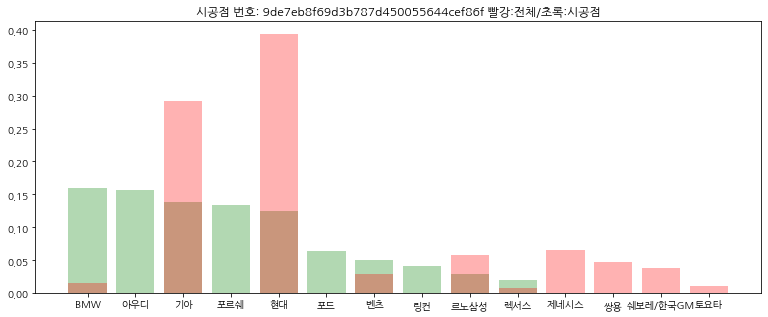

In [137]:
for i in makerXstore('BMW')[:10].store:
  vis_counts(i)

In [138]:
makerXstore('포르쉐')

store  ... percentage
1077  9de7eb8f69d3b787d450055644cef86f  ...   0.134545
1059  43bed24222d9fd7beb84b0c24e067f12  ...   0.082278
801   2d2bfd5d3c59aa2d0dcd1ea32edef0f8  ...   0.082090
154   5d69bf87c3109f378801b30f63e110c0  ...   0.065789
567   6a8ad07e404b4ffce09c81f20aac2219  ...   0.060000
739   0d84d612781609ea15e7ee7cdaf151ae  ...   0.049751
1030  317b59cfa206a293cc1612e235f911ca  ...   0.034839
1001  4b662724fcec9daedb68917760aa5e15  ...   0.027411
408   012ab097e97e103b1e6f8c196da7a875  ...   0.027228
888   4d9e72cb00ddffcf6b93d2824df49743  ...   0.025974
1029  730a24f76cb9b3fff977ea0ffa3ca865  ...   0.023649
677   272d837ab3b0f5dbaaa85f21ec6de1ae  ...   0.022321
966   414e3911782882f3ca1917d369cc9846  ...   0.021910
639   3c52ee815c1ec3e1f125af27fa1bbea6  ...   0.020619
261   4520c72319bff204692da0e2150be64c  ...   0.019231
1018  a24a8e16d3e119a23aec7807308b37a3  ...   0.018519
522   e1e2425af6d8901d1779e80a13414abd  ...   0.017327
135   7b0f9bb47243eaee86088fc74ef7d505  ...   0.015873
699   461fa55291e22de831a424f6877b5a94  ...   0.014760
1153  259451cb86939f83a15ce6aa7d5fb150  ...   0.014670
1017  1aacad79e70da27ee3d94b215a6c3515  ...   0.014545
576   94e50b82687350e05e5d8b4dc8a88f9e  ...   0.014368
134   cb9cd66ba7f5fc870352f07ee4bf59ee  ...   0.014320
449   397703885f757dca7de77bfea3f409af  ...   0.014085
488   470924011e7337833d28a8c8bba49ad5  ...   0.013917
287   2fb33ab819ba8a2b32a41ee03b8e36ec  ...   0.013447
1043  115af758daf7c212b39f0bef0c98cae6  ...   0.012862
409   2bc7612ba95c1a013e4099483644429b  ...   0.012346
772   dd4b4a3d6575c1375d94a33bbec8b837  ...   0.012195
1094  4585768e35a9c3eca21fb4c84cd4b015  ...   0.012048

[30 rows x 4 columns]

maker
BMW     0.160000
아우디     0.156364
기아      0.138182
포르쉐     0.134545
현대      0.125455
포드      0.063636
벤츠      0.050909
링컨      0.041818
르노삼성    0.029091
렉서스     0.020000
Name: regist_dt, dtype: float64
total: 550


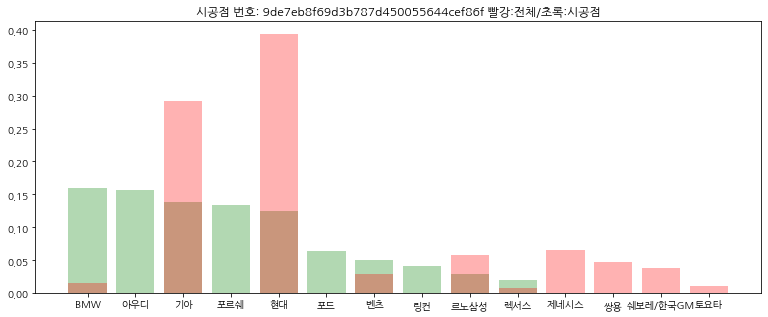

maker
현대          0.386076
기아          0.177215
제네시스        0.088608
포르쉐         0.082278
BMW         0.079114
르노삼성        0.041139
쌍용          0.028481
벤츠          0.025316
쉐보레/한국GM    0.018987
테슬라         0.012658
Name: regist_dt, dtype: float64
total: 316


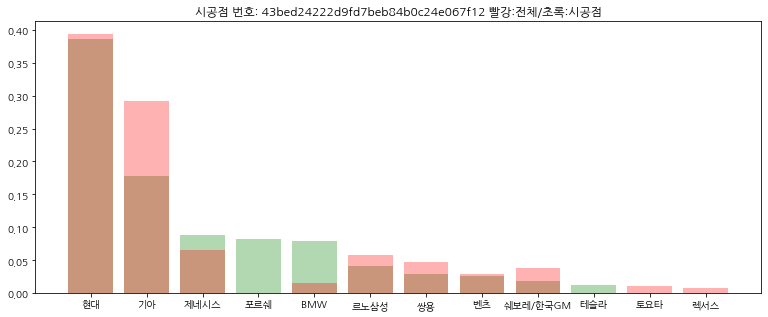

maker
현대      0.466667
제네시스    0.140741
포르쉐     0.081481
기아      0.074074
볼보      0.051852
벤츠      0.029630
쌍용      0.022222
렉서스     0.022222
BMW     0.022222
폭스바겐    0.014815
Name: regist_dt, dtype: float64
total: 135


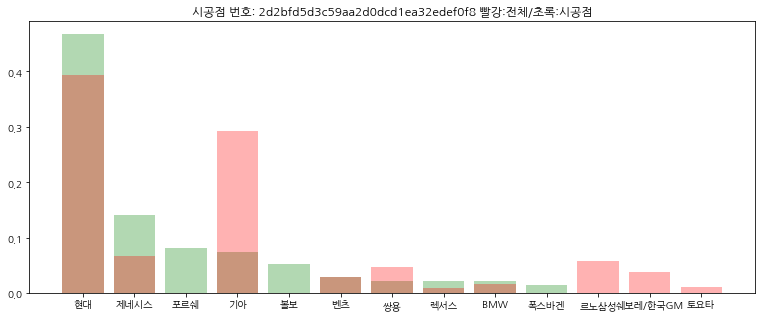

maker
벤츠     0.675325
아우디    0.142857
캐딜락    0.090909
포르쉐    0.064935
렉서스    0.012987
Name: regist_dt, dtype: float64
total: 77


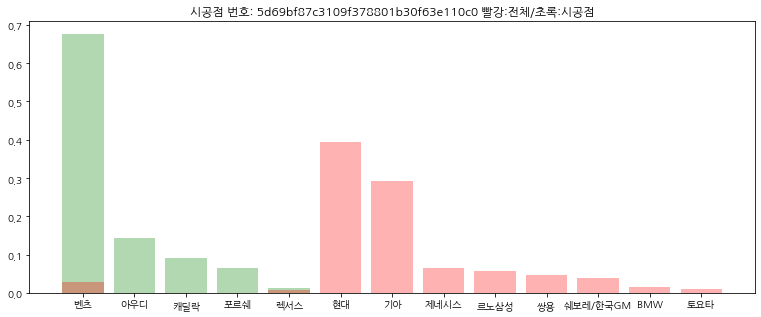

maker
현대          0.471040
제네시스        0.232189
기아          0.155305
포르쉐         0.059969
BMW         0.018452
벤츠          0.017940
아우디         0.009226
쌍용          0.004613
쉐보레/한국GM    0.004100
테슬라         0.003588
Name: regist_dt, dtype: float64
total: 1951


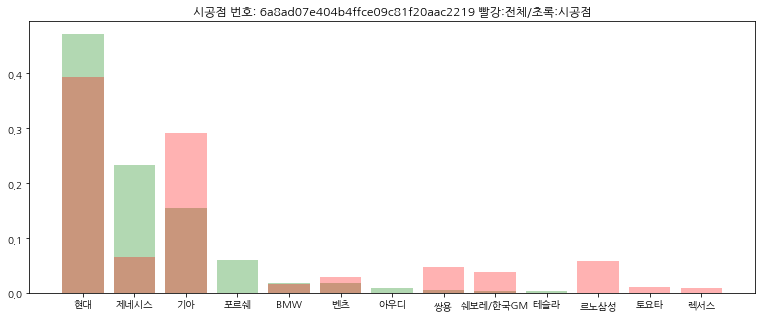

maker
현대          0.634684
기아          0.152097
제네시스        0.087420
포르쉐         0.049751
벤츠          0.019900
쉐보레/한국GM    0.013504
르노삼성        0.007107
BMW         0.006397
아큐라         0.004975
아우디         0.003554
Name: regist_dt, dtype: float64
total: 1407


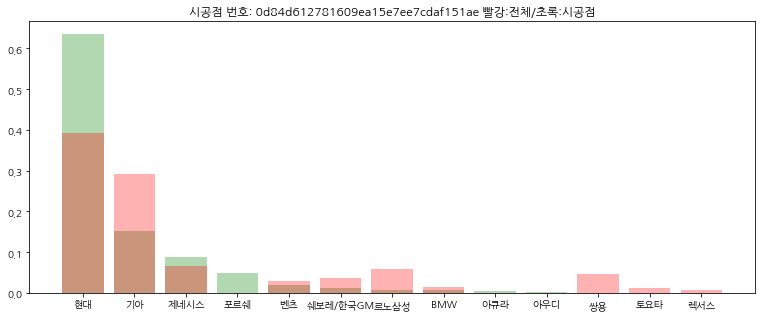

maker
현대          0.210425
벤츠          0.207207
기아          0.115830
제네시스        0.090090
BMW         0.081725
테슬라         0.050193
포르쉐         0.034749
아우디         0.026384
볼보          0.024453
쉐보레/한국GM    0.018018
Name: regist_dt, dtype: float64
total: 1554


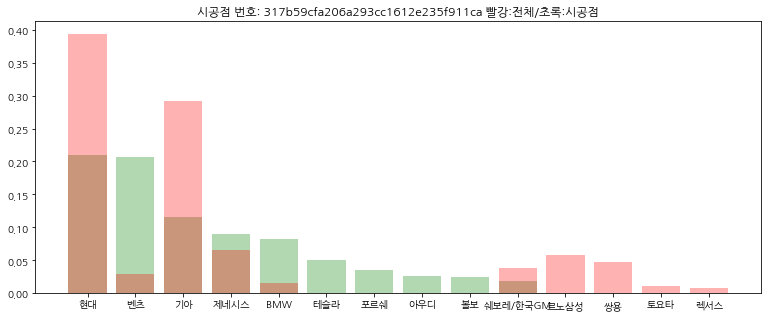

maker
BMW     0.425101
벤츠      0.311741
볼보      0.076923
포르쉐     0.027328
렉서스     0.026316
미니      0.024291
아우디     0.017206
제네시스    0.016194
현대      0.015182
지프      0.014170
Name: regist_dt, dtype: float64
total: 988


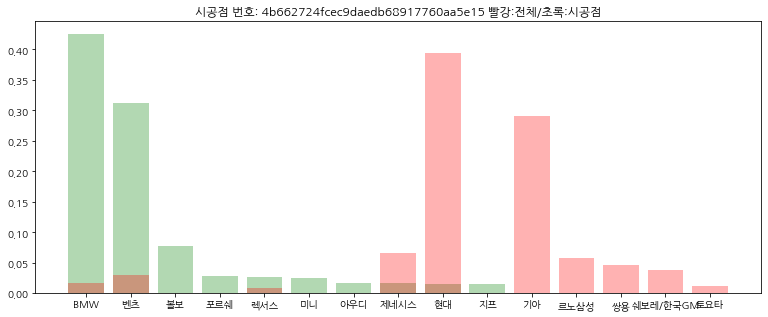

maker
현대      0.241038
벤츠      0.191595
기아      0.106304
제네시스    0.096415
볼보      0.066749
BMW     0.050680
포르쉐     0.027194
아우디     0.027194
렉서스     0.022250
르노삼성    0.022250
Name: regist_dt, dtype: float64
total: 809


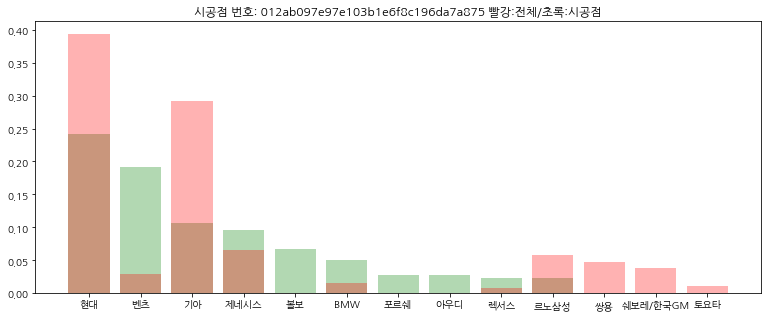

maker
현대          0.370130
BMW         0.253896
기아          0.125325
벤츠          0.083117
제네시스        0.081169
포르쉐         0.025974
쉐보레/한국GM    0.012338
쌍용          0.009091
마세라티        0.004545
폭스바겐        0.004545
Name: regist_dt, dtype: float64
total: 1540


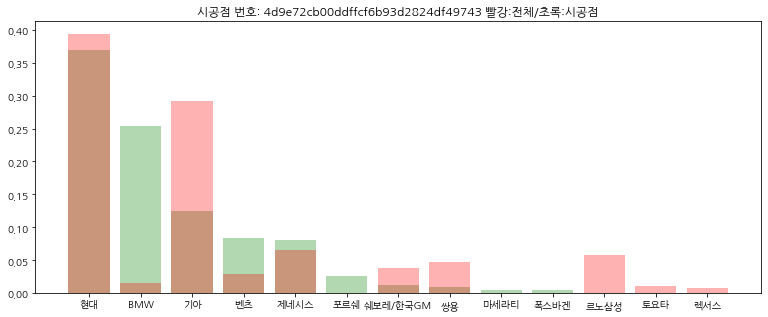

In [139]:
for i in makerXstore('포르쉐')[:10].store:
  vis_counts(i)

In [140]:
makerXstore('렉서스')

store  ... percentage
129   faf6556521007e1f71509689bb426b1e  ...   0.918790
345   0d13369bf930d44063e9f7968e08cb28  ...   0.318766
346   eabb79c85a0e83fb5efc7c7b992dc01c  ...   0.229293
191   8e5bb016e2cc17facfe4288d45c25917  ...   0.185659
545   de6535b79eeaf0fbee24a3409635de60  ...   0.153285
128   9143d451f70cc69da226f3fc152bd279  ...   0.123188
576   94e50b82687350e05e5d8b4dc8a88f9e  ...   0.066092
782   6deef0b5f1d3ec43328149ff73f6f677  ...   0.063050
821   635fe6a1a1682e388d85aac48fec0cce  ...   0.057527
643   53cb66ae3d6b678bc6a922aaeb7e6a1b  ...   0.054930
287   2fb33ab819ba8a2b32a41ee03b8e36ec  ...   0.047512
1268  2b63d707b834f0c0d9a7359fffe2df9f  ...   0.041667
133   c80867dc730d426ce03065e9f8e0b3cd  ...   0.040780
1040  152b58576fb33bef228256890a0ec010  ...   0.036697
690   a9abe3dec687616780e7a1bf28f961c9  ...   0.033236
699   461fa55291e22de831a424f6877b5a94  ...   0.033210
234   63c2269bc624e6ff14d415c037e8e16d  ...   0.027174
966   414e3911782882f3ca1917d369cc9846  ...   0.026966
1001  4b662724fcec9daedb68917760aa5e15  ...   0.026396
184   70b9851a499fe76de792ddd4a88b612c  ...   0.024336
488   470924011e7337833d28a8c8bba49ad5  ...   0.023857
996   6bb7c3f4494951dd9532f84cc010f0dc  ...   0.022727
801   2d2bfd5d3c59aa2d0dcd1ea32edef0f8  ...   0.022388
408   012ab097e97e103b1e6f8c196da7a875  ...   0.022277
1072  04be1cca3fa1591a2002564173c857b0  ...   0.022222
740   802938124b1c5a3c352e0a897acee023  ...   0.021840
134   cb9cd66ba7f5fc870352f07ee4bf59ee  ...   0.021480
1077  9de7eb8f69d3b787d450055644cef86f  ...   0.020000
466   180e79f285081c30dd726311f7e8e0f6  ...   0.019802
47    739fbcda6585d56b27443a67ff05f8c6  ...   0.019737

[30 rows x 4 columns]

maker
렉서스              0.918059
BMW              0.021480
현대               0.015115
벤츠               0.013524
['렉서스', '링컨']    0.007160
기아               0.003978
토요타              0.003182
폭스바겐             0.002387
르노삼성             0.001591
링컨               0.001591
Name: regist_dt, dtype: float64
total: 1257


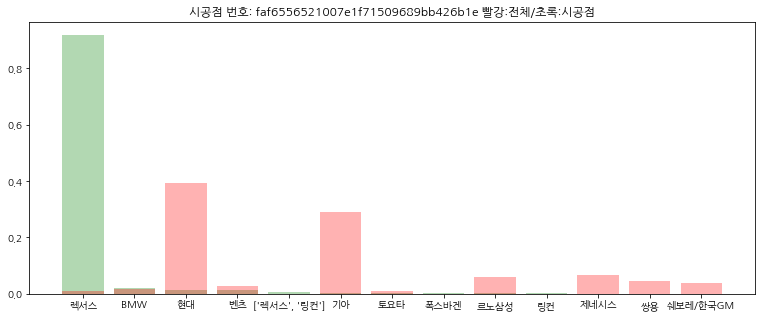

maker
토요타     0.579487
렉서스     0.317949
기아      0.015385
BMW     0.015385
아우디     0.012821
벤츠      0.012821
현대      0.010256
포르쉐     0.010256
테슬라     0.007692
제네시스    0.007692
Name: regist_dt, dtype: float64
total: 390


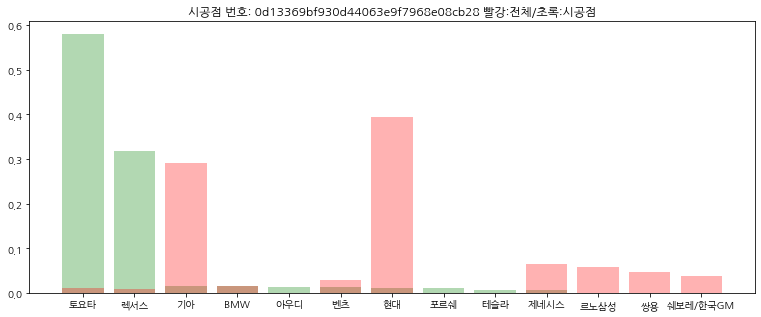

maker
토요타     0.763636
렉서스     0.229293
현대      0.003030
테슬라     0.001010
쌍용      0.001010
랜드로버    0.001010
BMW     0.001010
Name: regist_dt, dtype: float64
total: 990


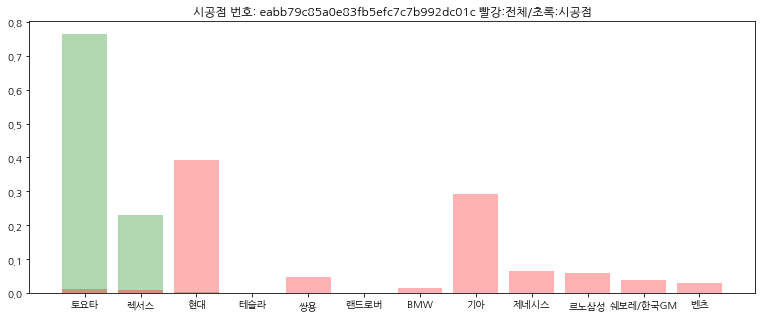

maker
벤츠      0.381879
볼보      0.206226
렉서스     0.185659
현대      0.045581
기아      0.035019
BMW     0.022790
랜드로버    0.020011
제네시스    0.018344
미니      0.017232
링컨      0.011117
Name: regist_dt, dtype: float64
total: 1799


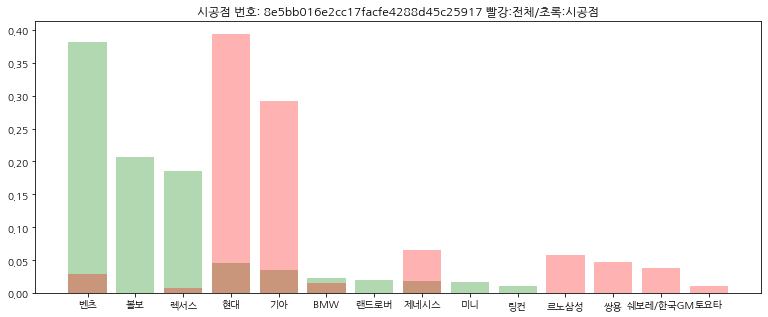

maker
토요타         0.613139
렉서스         0.153285
현대          0.077859
기아          0.053528
쉐보레/한국GM    0.031630
벤츠          0.017032
캐딜락         0.009732
BMW         0.009732
제네시스        0.007299
르노삼성        0.007299
Name: regist_dt, dtype: float64
total: 411


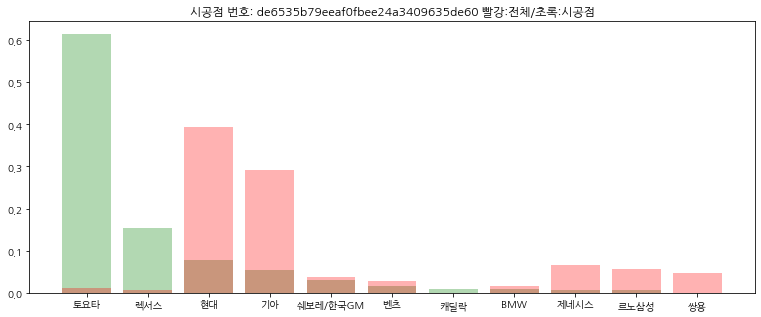

maker
캐딜락     0.181159
닛산      0.148551
기아      0.137681
렉서스     0.123188
현대      0.097826
아우디     0.043478
토요타     0.039855
닷지      0.036232
르노삼성    0.032609
벤츠      0.028986
Name: regist_dt, dtype: float64
total: 276


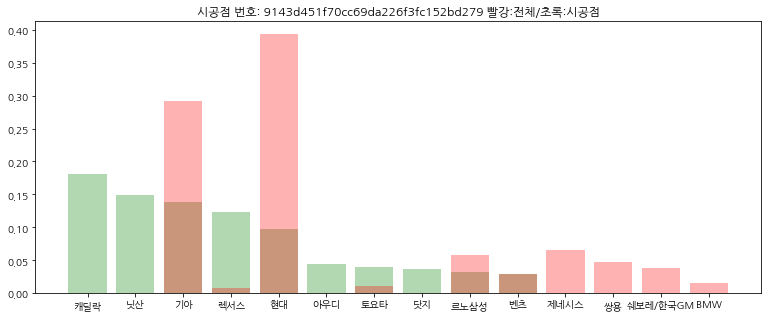

maker
현대      0.206304
벤츠      0.194842
기아      0.100287
제네시스    0.100287
BMW     0.091691
렉서스     0.065903
아우디     0.028653
랜드로버    0.022923
토요타     0.022923
르노삼성    0.017192
Name: regist_dt, dtype: float64
total: 349


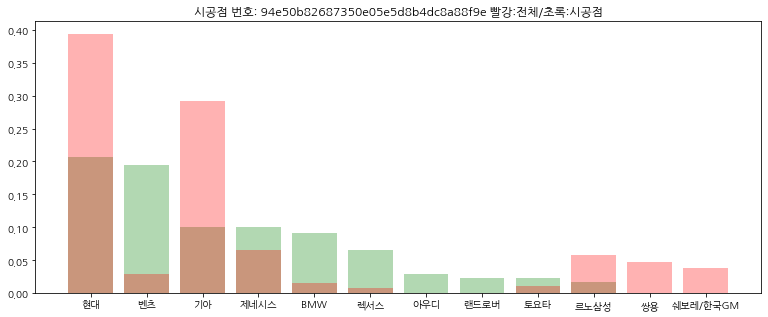

maker
현대      0.188873
BMW     0.185944
기아      0.130307
벤츠      0.090776
르노삼성    0.086384
렉서스     0.062958
아우디     0.045388
혼다      0.042460
푸조      0.039531
제네시스    0.030747
Name: regist_dt, dtype: float64
total: 683


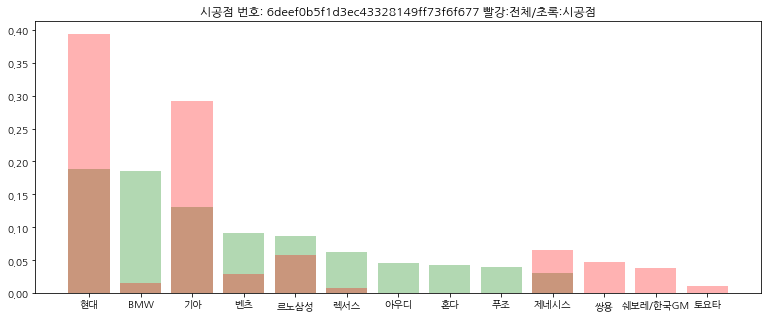

maker
벤츠          0.823751
BMW         0.074154
렉서스         0.057496
현대          0.011822
기아          0.009135
쉐보레/한국GM    0.003224
제네시스        0.002687
미니          0.002687
랜드로버        0.002687
재규어         0.001612
Name: regist_dt, dtype: float64
total: 1861


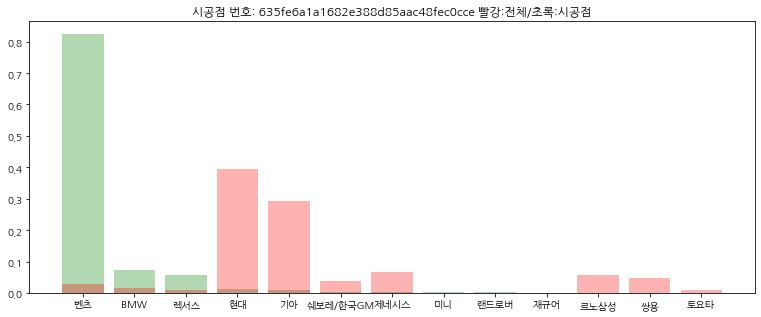

maker
현대          0.380282
기아          0.333803
제네시스        0.080282
렉서스         0.054930
벤츠          0.028169
BMW         0.026761
르노삼성        0.017606
볼보          0.009859
쉐보레/한국GM    0.009155
아우디         0.007042
Name: regist_dt, dtype: float64
total: 1420


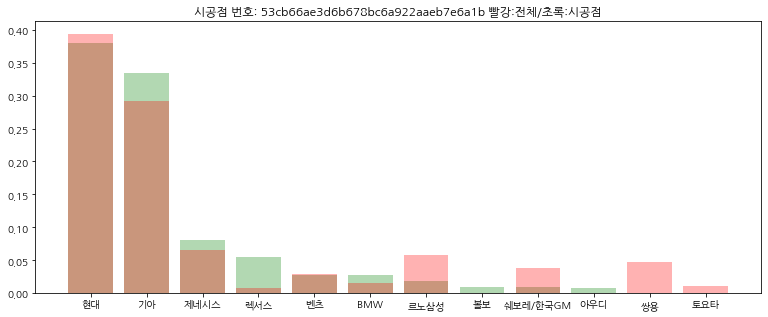

In [141]:
for i in makerXstore('렉서스')[:10].store:
  vis_counts(i)

In [30]:
maker_count = over_50.groupby(['store','country'])['regist_dt'].count().reset_index()
(maker_count[maker_count['country']=='한국'].groupby(['store'])['regist_dt'].sum()/maker_count.groupby(['store'])['regist_dt'].sum()).sort_values(ascending=False).head(30)
def countryXstore(brand):
  print((maker_count[maker_count['country']==brand].groupby(['store'])['regist_dt'].sum()/maker_count.groupby(['store'])['regist_dt'].sum()).sort_values(ascending=False).head(30))
countryXstore('독일')


store
fdf03abd6b6550637798e7ec9cb527fe    1.000000
d400b029f0bdf83012d65f4f598fd8f7    1.000000
f93b6802defdb40c90ac377ab0025de5    0.975207
ac2aec5fecce163e43efa0ed502da2f4    0.971581
9350d99198676f7def676af955ad5fd0    0.969909
635fe6a1a1682e388d85aac48fec0cce    0.907469
5d69bf87c3109f378801b30f63e110c0    0.880597
fd98cb0a5975ad7d2dc23534ed73eb21    0.837838
4b662724fcec9daedb68917760aa5e15    0.804255
d39fa2f90dd3263e168d728211086116    0.779141
272d837ab3b0f5dbaaa85f21ec6de1ae    0.536697
06c11979837de24f912f932e60219eef    0.500000
9de7eb8f69d3b787d450055644cef86f    0.495310
5bb60bdee333ee82ccbee3437366adee    0.457627
8e5bb016e2cc17facfe4288d45c25917    0.441753
461fa55291e22de831a424f6877b5a94    0.431907
ee9e2f46ae9d01e3f86b3fce9e3d2c02    0.409938
4520c72319bff204692da0e2150be64c    0.400000
470924011e7337833d28a8c8bba49ad5    0.397541
602e7722acea1e16c10f31f1c25b6c45    0.394402
872c833988b6117cf7569c3a73da4b62    0.371257
4d9e72cb00ddffcf6b93d2824df49743    0.364776
317b

(array([792., 134.,  86.,  62.,  26.,  28.,  25.,  21.,  19.,  18.,   9.,
         17.,   6.,   4.,   4.,   2.,   2.,   4.,   0.,   2.,   2.,   0.,
          1.,   1.,   0.,   1.,   0.,   0.,   0.,   1.]),
 array([1.0000e+00, 1.5760e+02, 3.1420e+02, 4.7080e+02, 6.2740e+02,
        7.8400e+02, 9.4060e+02, 1.0972e+03, 1.2538e+03, 1.4104e+03,
        1.5670e+03, 1.7236e+03, 1.8802e+03, 2.0368e+03, 2.1934e+03,
        2.3500e+03, 2.5066e+03, 2.6632e+03, 2.8198e+03, 2.9764e+03,
        3.1330e+03, 3.2896e+03, 3.4462e+03, 3.6028e+03, 3.7594e+03,
        3.9160e+03, 4.0726e+03, 4.2292e+03, 4.3858e+03, 4.5424e+03,
        4.6990e+03]),
 <a list of 30 Patch objects>)

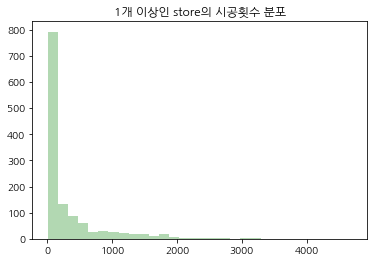

In [ ]:
#스토어별 시공횟수 분포 확인
stores = total_df_item_store.groupby(['store','store_addr','predicted_name'])['regist_dt'].count().sort_values(ascending=False)
n = 1
plt.title(f'{n}개 이상인 store의 시공횟수 분포')
plt.hist(stores[stores>=n],bins=30,color='green',alpha=.3)

In [ ]:
#사분위수/백분위수 확인
print('데이터 내 시공점 개수: '+str(len(stores)))
print('제 1 사분위수: '+str(stores.quantile(.25)))
print('제 2 사분위수: '+str(stores.quantile(.5)))
print('제 3 사분위수: '+str(stores.quantile(.75)))
print('99 백분위수: '+str(stores.quantile(.99)))

데이터 내 시공점 개수: 1267
제 1 사분위수: 12.0
제 2 사분위수: 73.0
제 3 사분위수: 353.0
99 백분위수: 2571.79999999999


In [ ]:
#상위 30개
top_stores = list(stores.reset_index().store.head(30))

In [ ]:
#썬팅 조합 표시
com = {
    'TTFTTF' : '1. 측2 후 전 ',
    'FFFFTF' : '2. 전',
    'TTTTTF': '3. 측3 후 전',
    'TTFTTT': '4. 측2 후 전 썬',
    'TTFTFF': '5. 측2 후',
    'TFFTTF': '6. 측1 후 전',
    'TFFFTF': '7. 측1 전',
    'TTTTTT': '8. 측3 후 전 썬',
    'TTFFTF': '9. 측2 전',
    'FFFFFT': '10. 썬'
}
def TF(inp):
  if np.isnan(inp):
    return 'F'
  else:
    return 'T'

def com_tin(df_row):
  try:
    return com[TF(df_row.product_1)+TF(df_row.product_2)+TF(df_row.product_3)+TF(df_row.product_4)+TF(df_row.product_5)+TF(df_row.product_6)]
  except:
    return '11. 그 외'
total_df_item_store['com_type'] = total_df_item_store.apply(com_tin, axis=1)
total_df_item_store.head(20)

Unnamed: 0       regist_dt  ... predicted_name     com_type
0            0  20201231165209  ...     모토익스 여의도센터  8. 측3 후 전 썬
1           28  20201230100632  ...     모토익스 여의도센터         2. 전
2           29  20201230092303  ...     모토익스 여의도센터   1. 측2 후 전 
3          192  20201221111340  ...     모토익스 여의도센터   1. 측2 후 전 
4          333  20201214110601  ...     모토익스 여의도센터   1. 측2 후 전 
5          449  20201209100721  ...     모토익스 여의도센터   1. 측2 후 전 
6          537  20201204144930  ...     모토익스 여의도센터  8. 측3 후 전 썬
7          618  20201201121940  ...     모토익스 여의도센터   1. 측2 후 전 
8          660  20201127170651  ...     모토익스 여의도센터         2. 전
9          913  20201116140307  ...     모토익스 여의도센터  8. 측3 후 전 썬
10         914  20201116140020  ...     모토익스 여의도센터   1. 측2 후 전 
11        1113  20201107123958  ...     모토익스 여의도센터      11. 그 외
12        1318  20201030095432  ...     모토익스 여의도센터         2. 전
13        1342  20201029132247  ...     모토익스 여의도센터   1. 측2 후 전 
14        1370  20201028152301  ...     모토익스 여의도센터  8. 측3 후 전 썬
15        1400  20201027164448  ...     모토익스 여의도센터         2. 전
16        1494  20201023094507  ...     모토익스 여의도센터  8. 측3 후 전 썬
17        1562  20201021143311  ...     모토익스 여의도센터  4. 측2 후 전 썬
18        1631  20201019114430  ...     모토익스 여의도센터   1. 측2 후 전 
19        1643  20201017152731  ...     모토익스 여의도센터   1. 측2 후 전 

[20 rows x 27 columns]

## top 20 시공점 별 시공조합 비율

com_type
1. 측2 후 전      0.628815
10. 썬          0.002746
11. 그 외        0.017608
2. 전           0.165812
3. 측3 후 전      0.068676
4. 측2 후 전 썬    0.064955
5. 측2 후        0.015388
6. 측1 후 전      0.011109
7. 측1 전        0.009571
8. 측3 후 전 썬    0.008129
9. 측2 전        0.007191
Name: regist_dt, dtype: float64


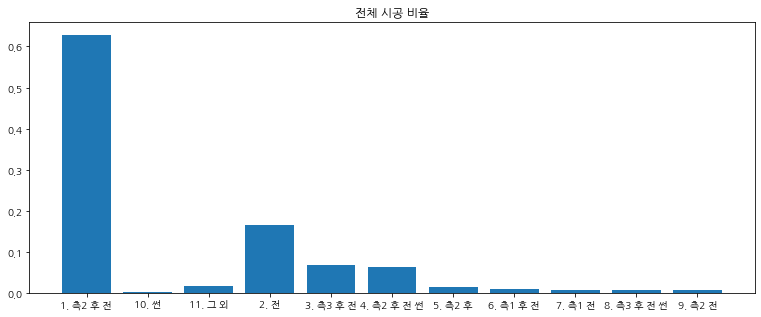

com_type
1. 측2 후 전      0.848478
11. 그 외        0.002767
2. 전           0.035327
3. 측3 후 전      0.033624
4. 측2 후 전 썬    0.021068
5. 측2 후        0.017663
6. 측1 후 전      0.022558
7. 측1 전        0.011279
8. 측3 후 전 썬    0.003618
9. 측2 전        0.003618
Name: regist_dt, dtype: float64


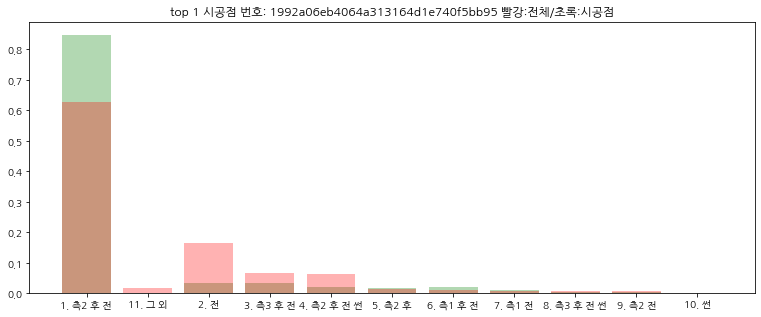

com_type
1. 측2 후 전      0.855293
10. 썬          0.000996
11. 그 외        0.004234
2. 전           0.076712
3. 측3 후 전      0.026650
4. 측2 후 전 썬    0.013948
5. 측2 후        0.007472
6. 측1 후 전      0.009714
7. 측1 전        0.001993
8. 측3 후 전 썬    0.000249
9. 측2 전        0.002740
Name: regist_dt, dtype: float64


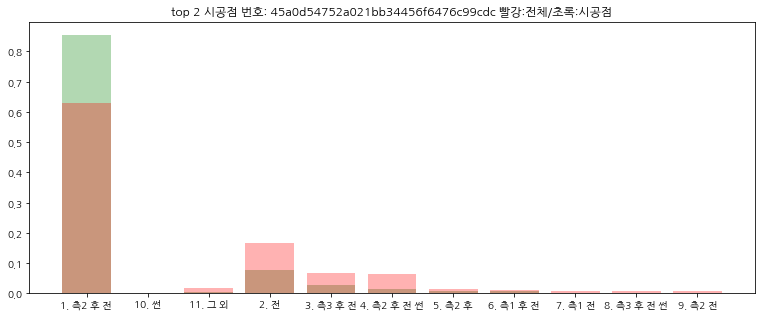

com_type
1. 측2 후 전      0.751072
10. 썬          0.002680
11. 그 외        0.006967
2. 전           0.124062
3. 측3 후 전      0.006967
4. 측2 후 전 썬    0.083601
5. 측2 후        0.011790
6. 측1 후 전      0.004287
7. 측1 전        0.004555
8. 측3 후 전 썬    0.002947
9. 측2 전        0.001072
Name: regist_dt, dtype: float64


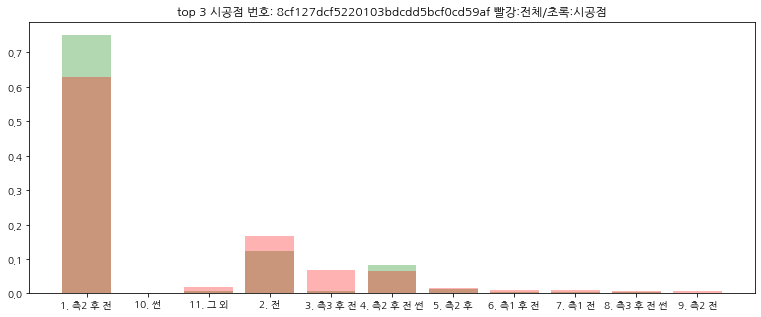

com_type
1. 측2 후 전      0.732871
10. 썬          0.002024
11. 그 외        0.007228
2. 전           0.020526
3. 측3 후 전      0.123446
4. 측2 후 전 썬    0.059844
5. 측2 후        0.005782
6. 측1 후 전      0.032090
7. 측1 전        0.002891
8. 측3 후 전 썬    0.011564
9. 측2 전        0.001735
Name: regist_dt, dtype: float64


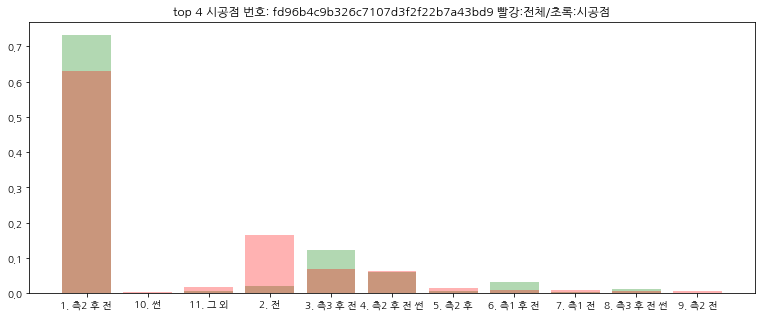

com_type
1. 측2 후 전      0.841452
10. 썬          0.004034
11. 그 외        0.011480
2. 전           0.053056
3. 측3 후 전      0.031337
4. 측2 후 전 썬    0.029165
5. 측2 후        0.009929
6. 측1 후 전      0.013342
7. 측1 전        0.002172
8. 측3 후 전 썬    0.000310
9. 측2 전        0.003723
Name: regist_dt, dtype: float64


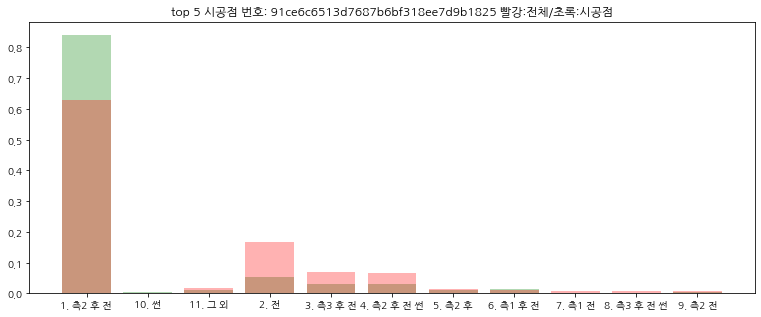

com_type
1. 측2 후 전      0.765749
10. 썬          0.002849
11. 그 외        0.005065
2. 전           0.077556
3. 측3 후 전      0.053181
4. 측2 후 전 썬    0.060779
5. 측2 후        0.012346
6. 측1 후 전      0.008864
7. 측1 전        0.002216
8. 측3 후 전 썬    0.009813
9. 측2 전        0.001583
Name: regist_dt, dtype: float64


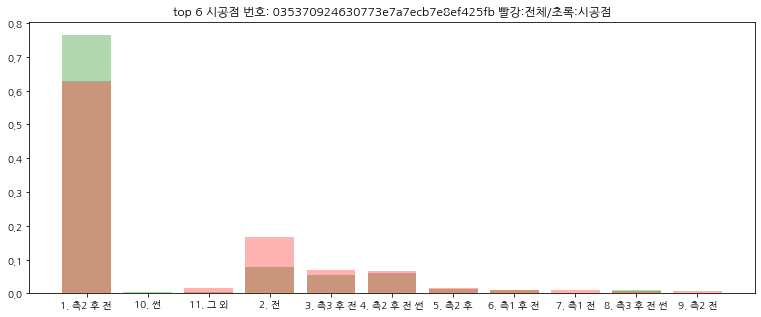

com_type
1. 측2 후 전      0.524217
10. 썬          0.004283
11. 그 외        0.023723
2. 전           0.267216
3. 측3 후 전      0.081054
4. 측2 후 전 썬    0.040857
5. 측2 후        0.024712
6. 측1 후 전      0.005931
7. 측1 전        0.013180
8. 측3 후 전 썬    0.005931
9. 측2 전        0.008896
Name: regist_dt, dtype: float64


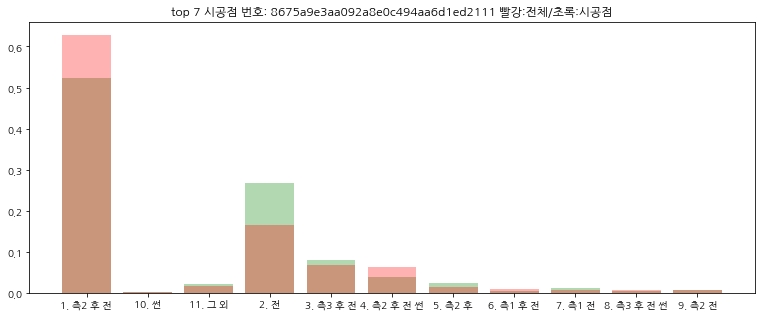

com_type
1. 측2 후 전      0.629838
10. 썬          0.002316
11. 그 외        0.009262
2. 전           0.193847
3. 측3 후 전      0.049950
4. 측2 후 전 썬    0.077737
5. 측2 후        0.014555
6. 측1 후 전      0.007608
7. 측1 전        0.003970
8. 측3 후 전 썬    0.008601
9. 측2 전        0.002316
Name: regist_dt, dtype: float64


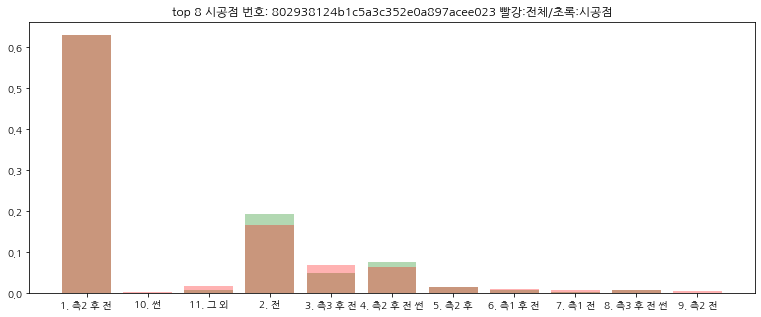

com_type
1. 측2 후 전      0.624733
10. 썬          0.009622
11. 그 외        0.029223
2. 전           0.126871
3. 측3 후 전      0.023521
4. 측2 후 전 썬    0.127227
5. 측2 후        0.027085
6. 측1 후 전      0.014968
7. 측1 전        0.008197
8. 측3 후 전 썬    0.006771
9. 측2 전        0.001782
Name: regist_dt, dtype: float64


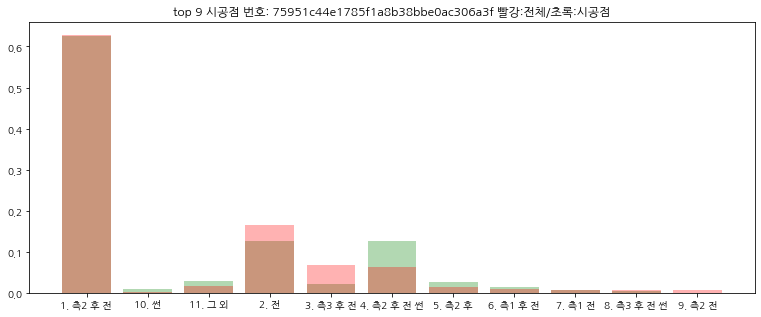

com_type
1. 측2 후 전      0.700623
10. 썬          0.002565
11. 그 외        0.014657
2. 전           0.023452
3. 측3 후 전      0.149505
4. 측2 후 전 썬    0.056431
5. 측2 후        0.004031
6. 측1 후 전      0.031513
7. 측1 전        0.002199
8. 측3 후 전 썬    0.014291
9. 측2 전        0.000733
Name: regist_dt, dtype: float64


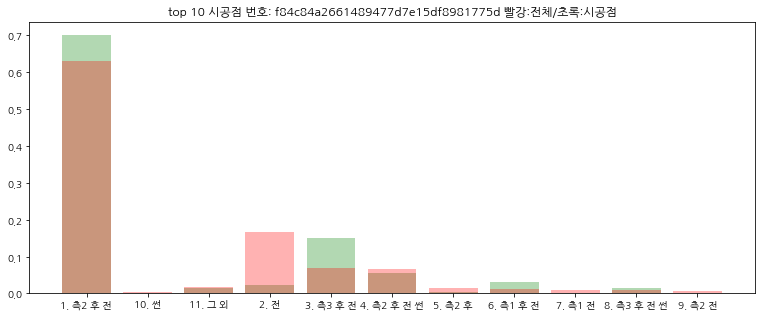

com_type
1. 측2 후 전      0.705601
11. 그 외        0.008475
2. 전           0.100590
3. 측3 후 전      0.119749
4. 측2 후 전 썬    0.036109
5. 측2 후        0.006264
6. 측1 후 전      0.011791
7. 측1 전        0.003316
8. 측3 후 전 썬    0.007369
9. 측2 전        0.000737
Name: regist_dt, dtype: float64


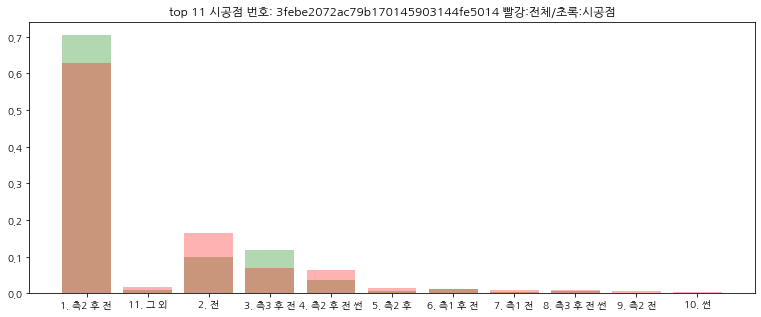

com_type
1. 측2 후 전      0.676067
10. 썬          0.001855
11. 그 외        0.009276
2. 전           0.168460
3. 측3 후 전      0.070130
4. 측2 후 전 썬    0.050093
5. 측2 후        0.009647
6. 측1 후 전      0.002597
7. 측1 전        0.002597
8. 측3 후 전 썬    0.006679
9. 측2 전        0.002597
Name: regist_dt, dtype: float64


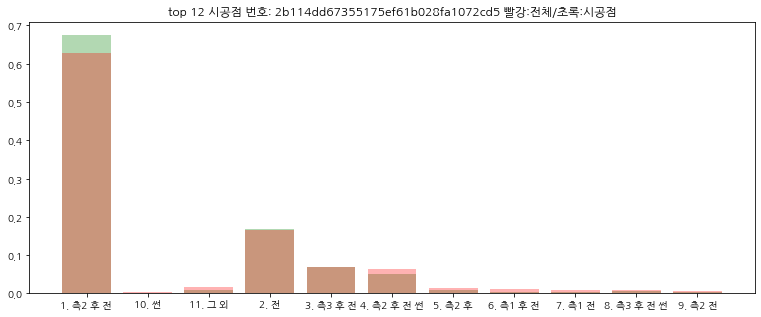

com_type
1. 측2 후 전      0.880800
11. 그 외        0.002263
2. 전           0.012071
3. 측3 후 전      0.043380
4. 측2 후 전 썬    0.033195
5. 측2 후        0.005281
6. 측1 후 전      0.018861
7. 측1 전        0.001132
8. 측3 후 전 썬    0.002641
9. 측2 전        0.000377
Name: regist_dt, dtype: float64


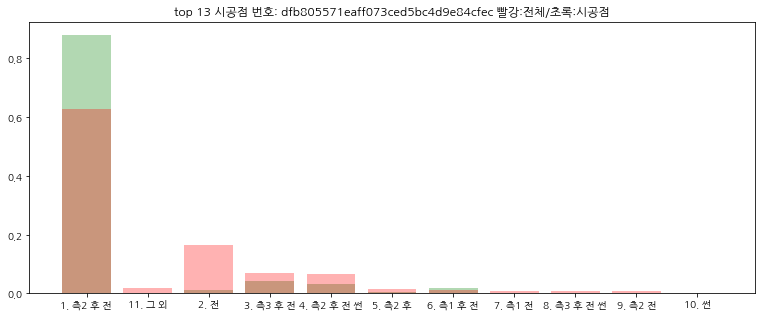

com_type
1. 측2 후 전      0.657843
10. 썬          0.002371
11. 그 외        0.010668
2. 전           0.164362
3. 측3 후 전      0.051758
4. 측2 후 전 썬    0.084947
5. 측2 후        0.005927
6. 측1 후 전      0.004346
7. 측1 전        0.006322
8. 측3 후 전 썬    0.007112
9. 측2 전        0.004346
Name: regist_dt, dtype: float64


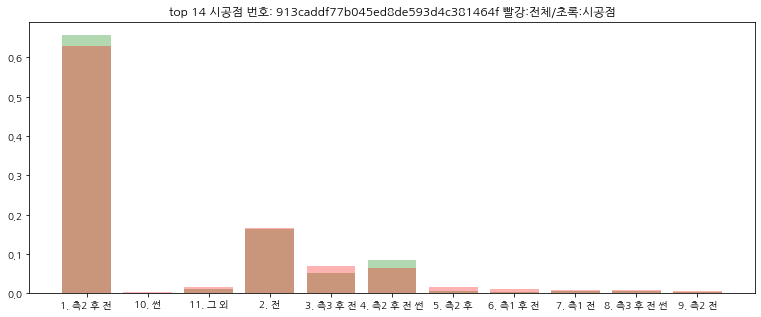

com_type
1. 측2 후 전      0.830260
10. 썬          0.001676
11. 그 외        0.001676
2. 전           0.027242
3. 측3 후 전      0.043588
4. 측2 후 전 썬    0.069573
5. 측2 후        0.011316
6. 측1 후 전      0.006706
7. 측1 전        0.000419
8. 측3 후 전 썬    0.005029
9. 측2 전        0.002515
Name: regist_dt, dtype: float64


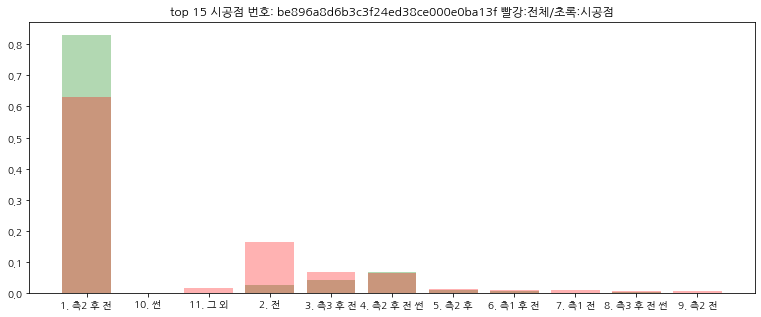

com_type
1. 측2 후 전      0.381313
10. 썬          0.002104
11. 그 외        0.031566
2. 전           0.471801
3. 측3 후 전      0.038721
4. 측2 후 전 썬    0.026094
5. 측2 후        0.022727
6. 측1 후 전      0.005471
7. 측1 전        0.012205
8. 측3 후 전 썬    0.000842
9. 측2 전        0.007155
Name: regist_dt, dtype: float64


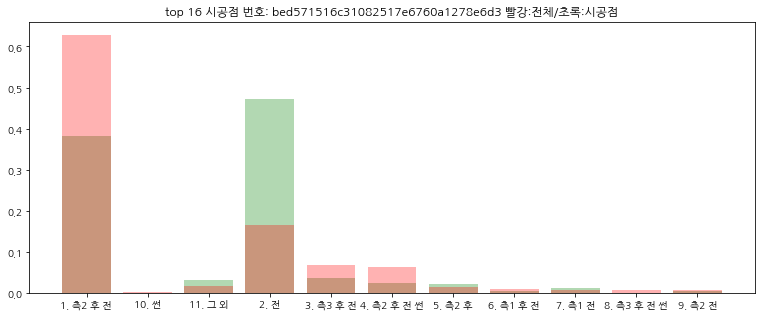

com_type
1. 측2 후 전      0.597167
10. 썬          0.003099
11. 그 외        0.023462
2. 전           0.095175
3. 측3 후 전      0.156707
4. 측2 후 전 썬    0.062417
5. 측2 후        0.018592
6. 측1 후 전      0.006640
7. 측1 전        0.007968
8. 측3 후 전 썬    0.014166
9. 측2 전        0.014608
Name: regist_dt, dtype: float64


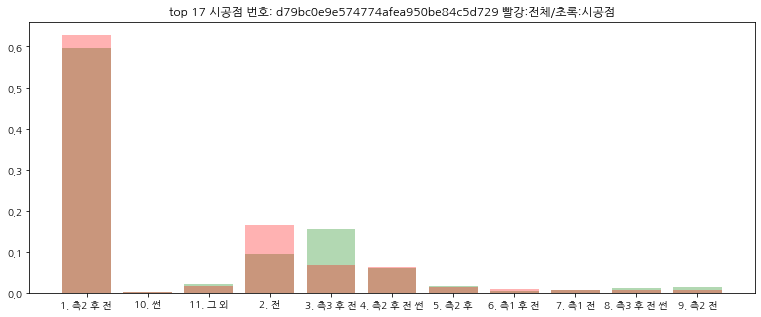

com_type
1. 측2 후 전      0.665175
10. 썬          0.003133
11. 그 외        0.016562
2. 전           0.069382
3. 측3 후 전      0.048791
4. 측2 후 전 썬    0.124440
5. 측2 후        0.015667
6. 측1 후 전      0.038496
7. 측1 전        0.008057
8. 측3 후 전 썬    0.004476
9. 측2 전        0.005819
Name: regist_dt, dtype: float64


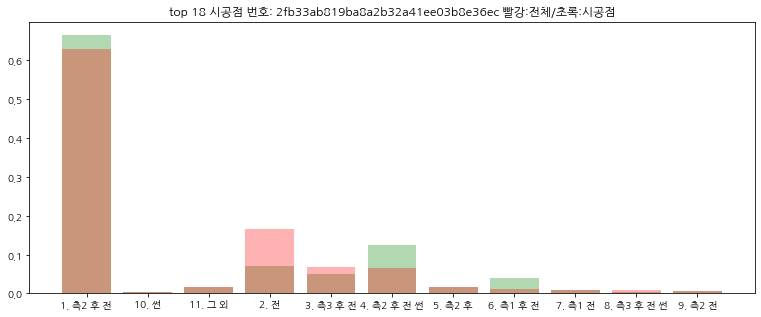

com_type
1. 측2 후 전      0.780355
10. 썬          0.001364
11. 그 외        0.009095
2. 전           0.048658
3. 측3 후 전      0.092315
4. 측2 후 전 썬    0.018190
5. 측2 후        0.012733
6. 측1 후 전      0.022738
7. 측1 전        0.005002
8. 측3 후 전 썬    0.006367
9. 측2 전        0.003183
Name: regist_dt, dtype: float64


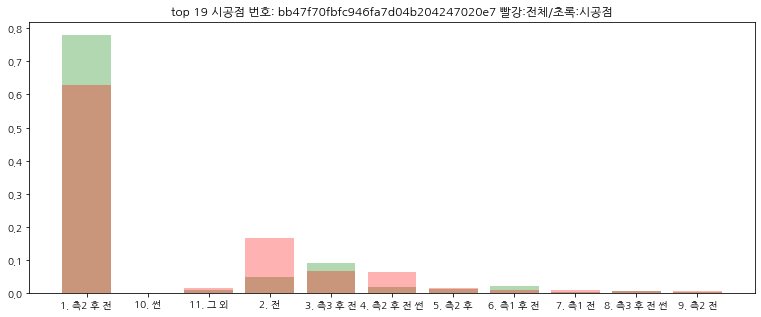

com_type
1. 측2 후 전      0.542141
10. 썬          0.000456
11. 그 외        0.008656
2. 전           0.338952
3. 측3 후 전      0.019134
4. 측2 후 전 썬    0.049203
5. 측2 후        0.019134
6. 측1 후 전      0.004100
7. 측1 전        0.011845
8. 측3 후 전 썬    0.003645
9. 측2 전        0.002733
Name: regist_dt, dtype: float64


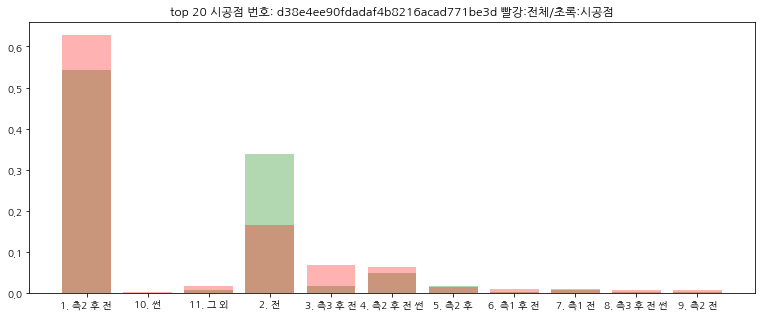

In [ ]:
# 시공 부위별 비율
total_counts = total_df_item_store.groupby(['com_type'])['regist_dt'].count()/len(total_df_item_store)
print(total_counts)
plt.figure(figsize = (13,5))
plt.title('전체 시공 비율')
plt.bar(x = total_counts.index, height = total_counts)
plt.show()

for i in top_stores[0:20]:
  counts = total_df_item_store[total_df_item_store['store'] == i].groupby(['com_type'])['regist_dt'].count()/len(total_df_item_store[total_df_item_store['store'] == i])
  print(counts)
  plt.figure(figsize = (13,5))
  plt.title(f'top {top_stores.index(i)+1} 시공점 번호: '+i+' 빨강:전체/초록:시공점')
  plt.bar(x = counts.index, height = counts, color='green', alpha=.3)
  plt.bar(x = total_counts.index, height = total_counts, color='red', alpha=.3)
  plt.show()


## top20 시공점별 딜러 비율

by_dealer
0    0.829311
1    0.170689
Name: regist_dt, dtype: float64


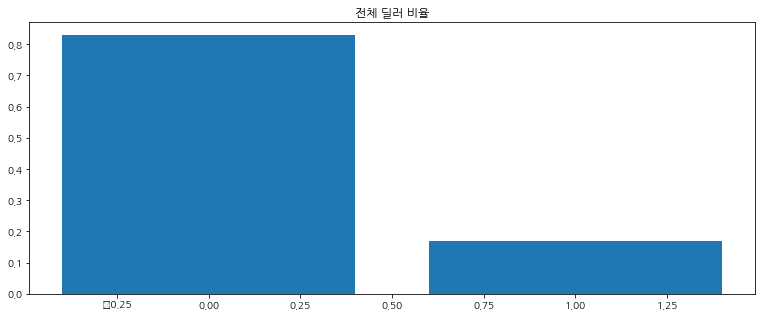

by_dealer
0    0.652905
1    0.347095
Name: regist_dt, dtype: float64


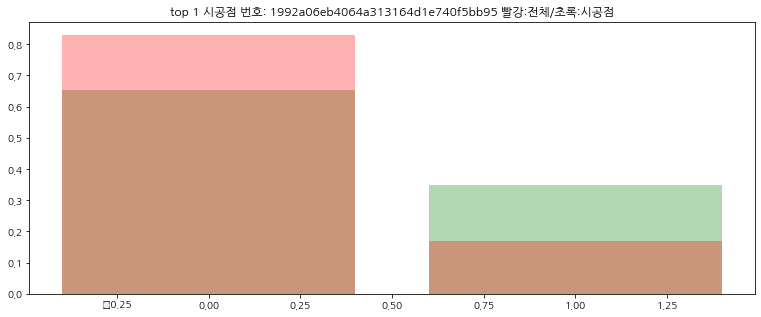

by_dealer
0    0.535243
1    0.464757
Name: regist_dt, dtype: float64


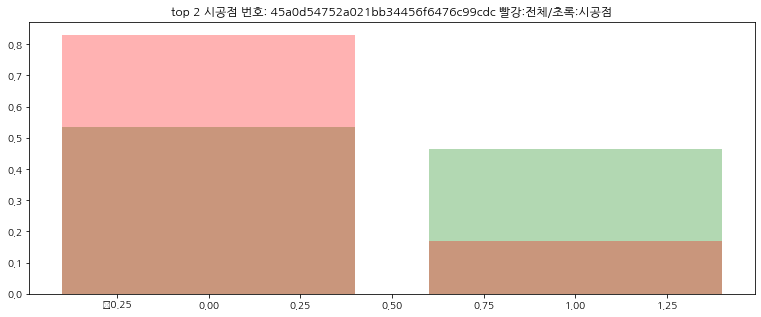

by_dealer
1    0.576367
0    0.423633
Name: regist_dt, dtype: float64


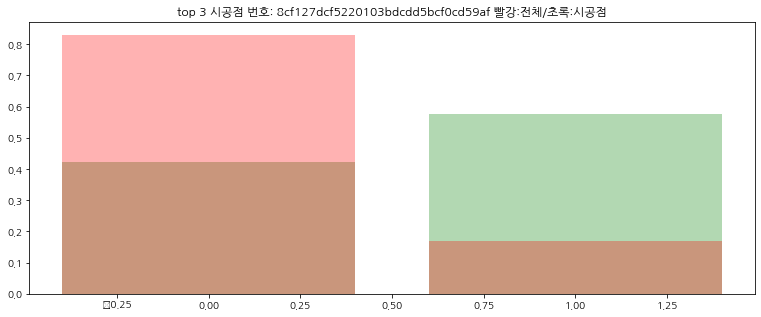

by_dealer
0    0.808037
1    0.191963
Name: regist_dt, dtype: float64


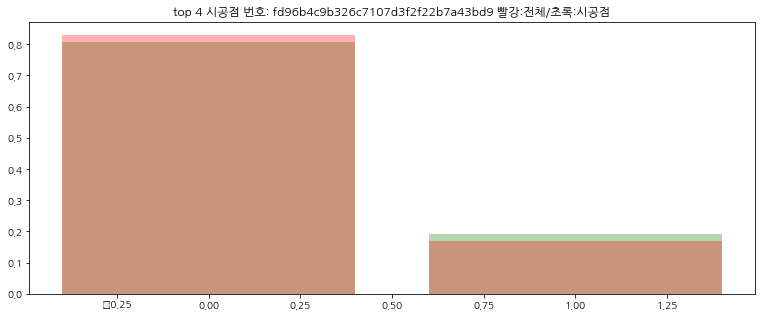

by_dealer
0    1.0
Name: regist_dt, dtype: float64


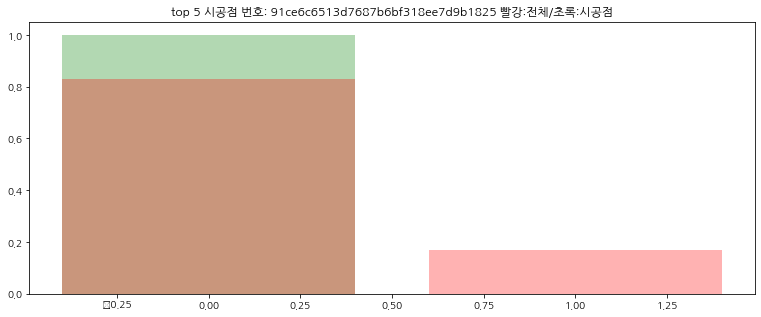

by_dealer
1    0.559671
0    0.440329
Name: regist_dt, dtype: float64


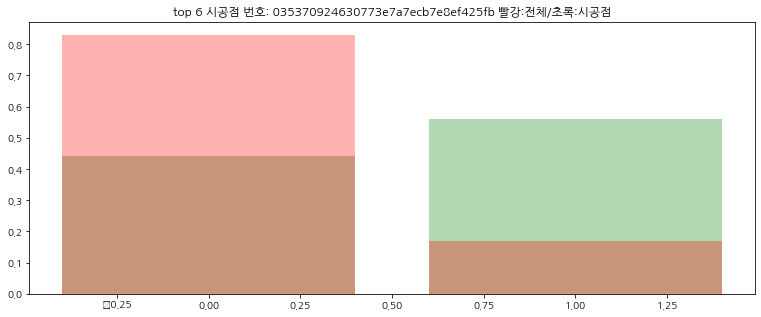

by_dealer
0    0.723888
1    0.276112
Name: regist_dt, dtype: float64


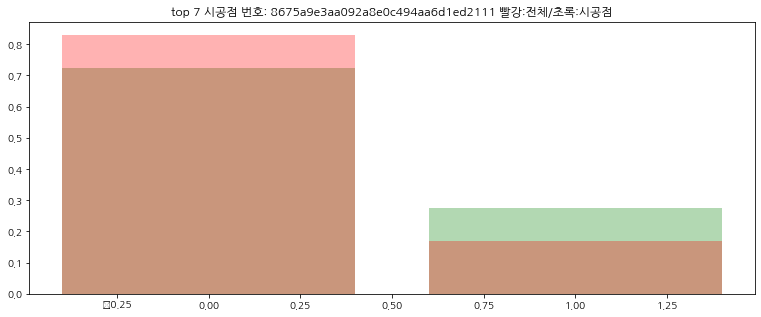

by_dealer
0    0.649024
1    0.350976
Name: regist_dt, dtype: float64


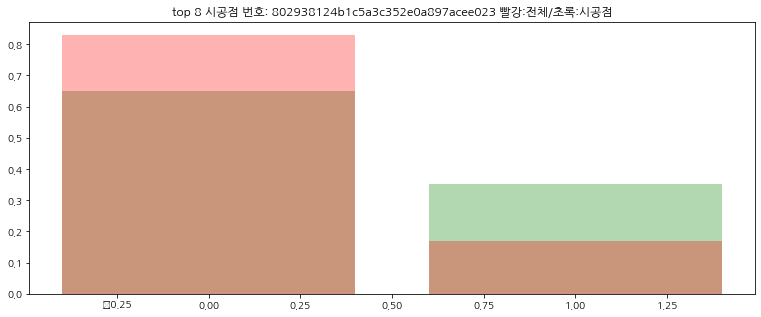

by_dealer
0    0.708838
1    0.291162
Name: regist_dt, dtype: float64


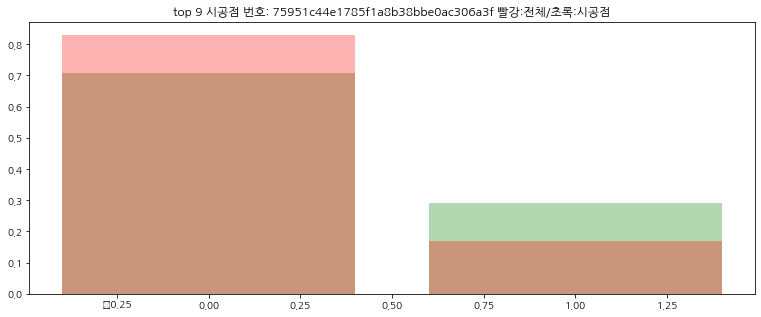

by_dealer
1    0.554049
0    0.445951
Name: regist_dt, dtype: float64


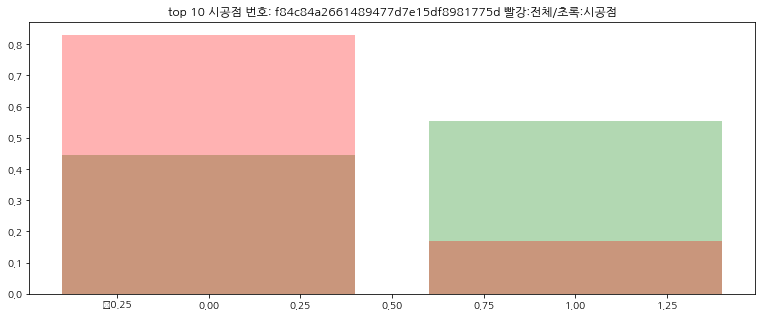

by_dealer
0    0.56927
1    0.43073
Name: regist_dt, dtype: float64


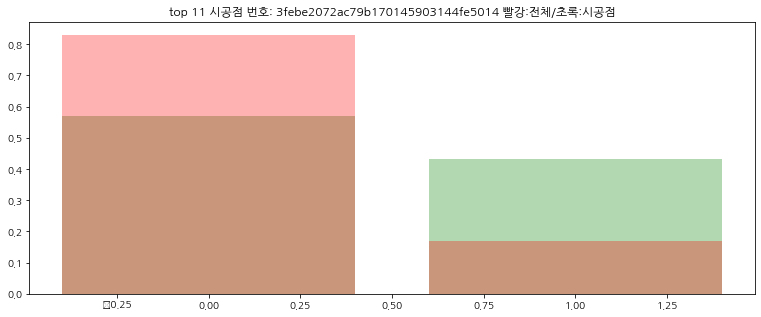

by_dealer
1    0.562523
0    0.437477
Name: regist_dt, dtype: float64


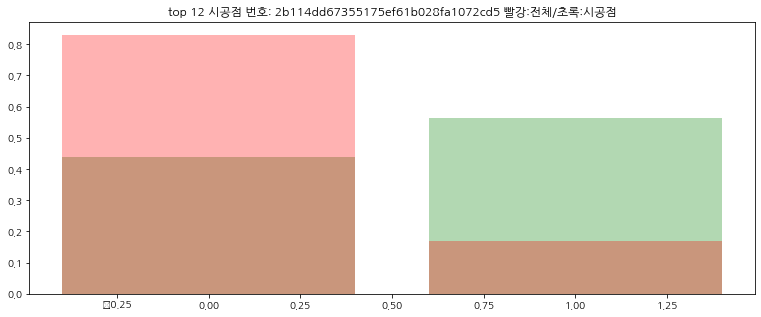

by_dealer
0    1.0
Name: regist_dt, dtype: float64


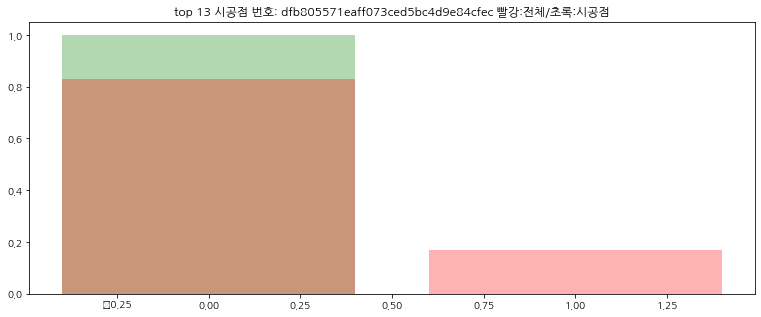

by_dealer
0    0.507309
1    0.492691
Name: regist_dt, dtype: float64


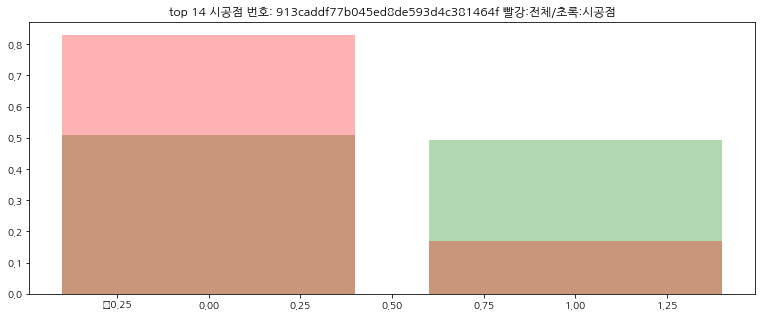

by_dealer
1    0.550293
0    0.449707
Name: regist_dt, dtype: float64


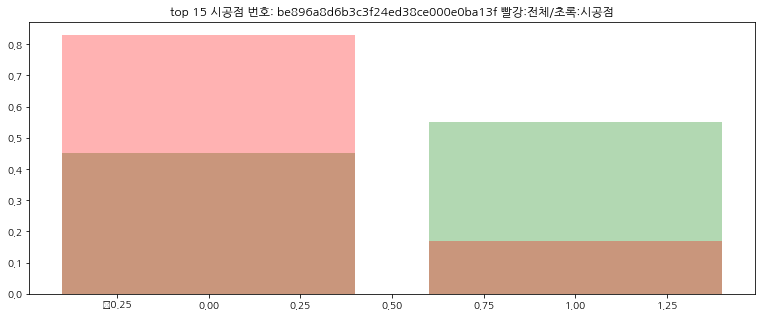

by_dealer
0    0.999158
1    0.000842
Name: regist_dt, dtype: float64


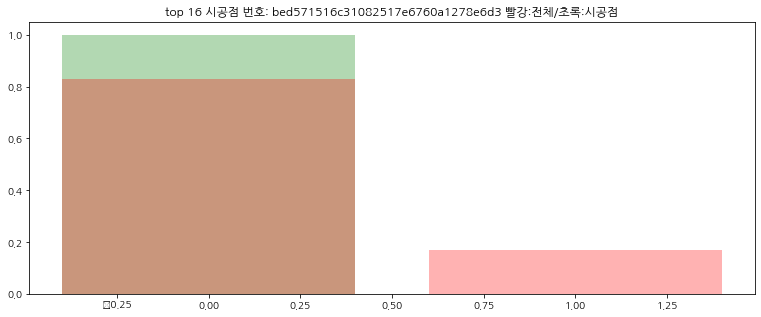

by_dealer
0    0.76494
1    0.23506
Name: regist_dt, dtype: float64


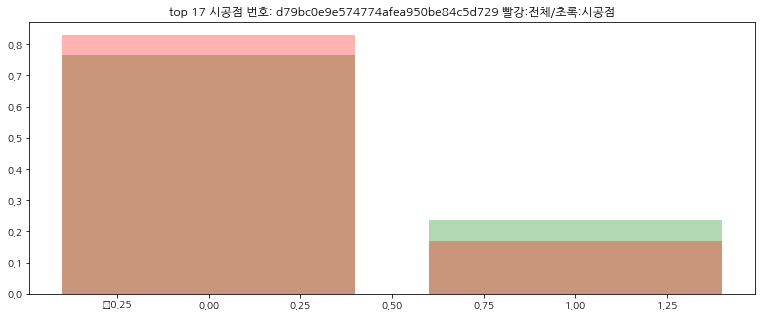

by_dealer
0    0.755148
1    0.244852
Name: regist_dt, dtype: float64


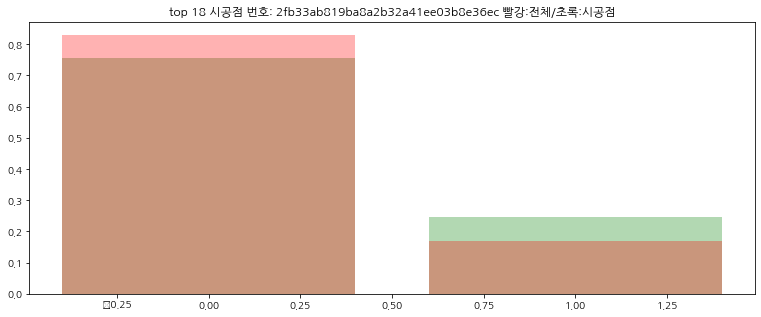

by_dealer
1    0.644384
0    0.355616
Name: regist_dt, dtype: float64


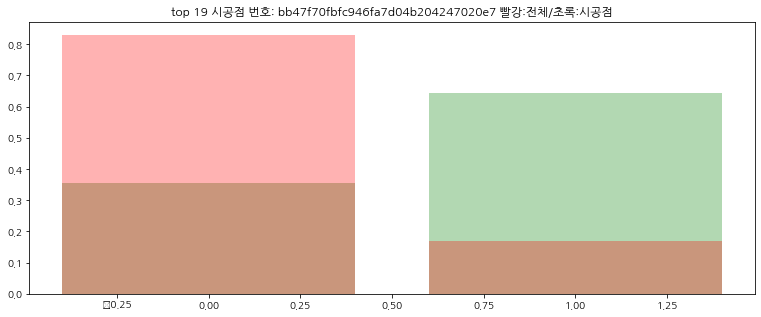

by_dealer
0    0.982688
1    0.017312
Name: regist_dt, dtype: float64


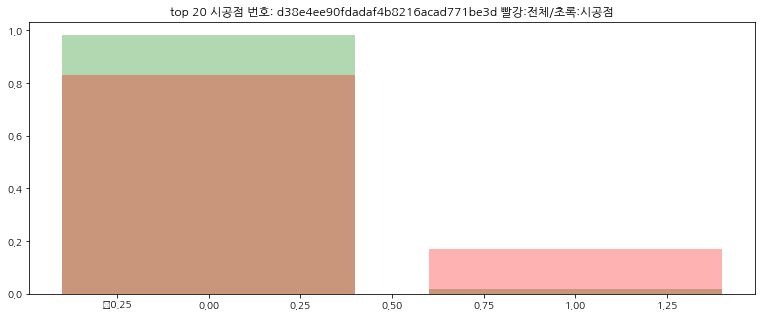

by_dealer
0    0.676043
1    0.323957
Name: regist_dt, dtype: float64


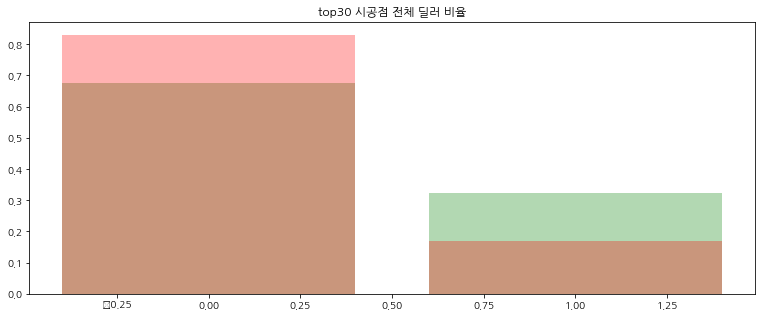

In [ ]:
#시공점별 딜러비율
total_counts = total_df_item_store.groupby(['by_dealer'])['regist_dt'].count()/len(total_df_item_store)
print(total_counts.sort_values(ascending=False)[0:10])
plt.figure(figsize = (13,5))
plt.title('전체 딜러 비율')
plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10])
plt.show()

for i in top_stores[0:20]:
  counts = total_df_item_store[total_df_item_store['store'] == i].groupby(['by_dealer'])['regist_dt'].count().sort_values(ascending=False)[0:10]/len(total_df_item_store[total_df_item_store['store'] == i])
  print(counts)
  plt.figure(figsize = (13,5))
  plt.title(f'top {top_stores.index(i)+1} 시공점 번호: '+i+' 빨강:전체/초록:시공점')
  plt.bar(x = counts.index, height = counts, color='green', alpha=.3)
  plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10], color='red', alpha=.3)
  plt.show()

counts_top30 = total_df_item_store[total_df_item_store['store'].isin(top_stores)].groupby(['by_dealer'])['regist_dt'].count().sort_values(ascending=False)[0:10]/len(total_df_item_store[total_df_item_store['store'].isin(top_stores)])
print(counts_top30)
plt.figure(figsize = (13,5))
plt.title(f'top30 시공점 전체 딜러 비율')
plt.bar(x = counts_top30.index, height = counts_top30, color='green', alpha=.3)
plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10], color='red', alpha=.3)
plt.show()

## top 20 시공점 별 메이커 비율

maker
현대          0.443786
기아          0.290988
르노삼성        0.057653
쌍용          0.046457
쉐보레/한국GM    0.037000
벤츠          0.027851
BMW         0.014673
제네시스        0.014383
토요타         0.011165
0           0.008487
Name: regist_dt, dtype: float64


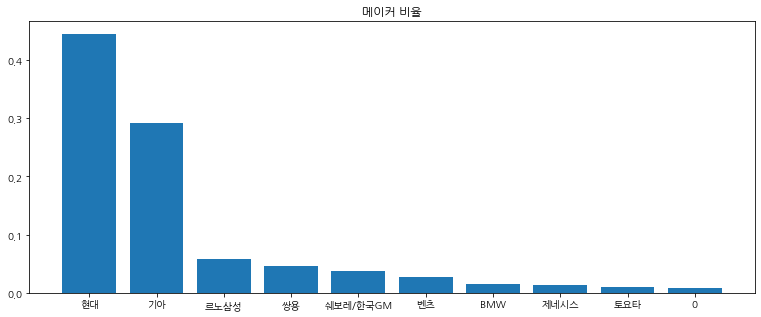

maker
현대          0.545648
기아          0.418600
제네시스        0.010853
쌍용          0.005533
쉐보레/한국GM    0.005320
아큐라         0.004043
르노삼성        0.003405
랜드로버        0.001064
쉐보레         0.000851
BMW         0.000851
Name: regist_dt, dtype: float64


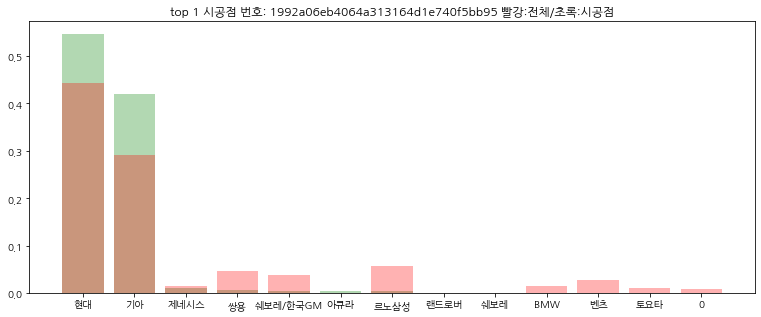

maker
현대          0.578331
기아          0.312578
쉐보레/한국GM    0.043337
쌍용          0.025405
제네시스        0.018680
르노삼성        0.015442
아큐라         0.001743
쉐보레         0.001245
벤츠          0.001245
0           0.001245
Name: regist_dt, dtype: float64


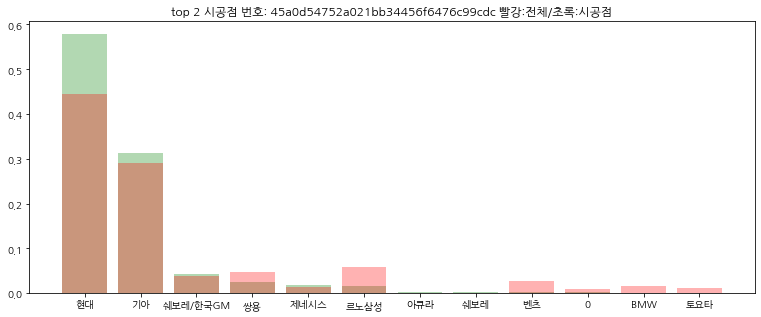

maker
현대          0.716774
기아          0.130493
르노삼성        0.064041
쉐보레/한국GM    0.031083
제네시스        0.018221
쌍용          0.011254
아큐라         0.005091
BMW         0.004823
벤츠          0.003751
쉐보레         0.002412
Name: regist_dt, dtype: float64


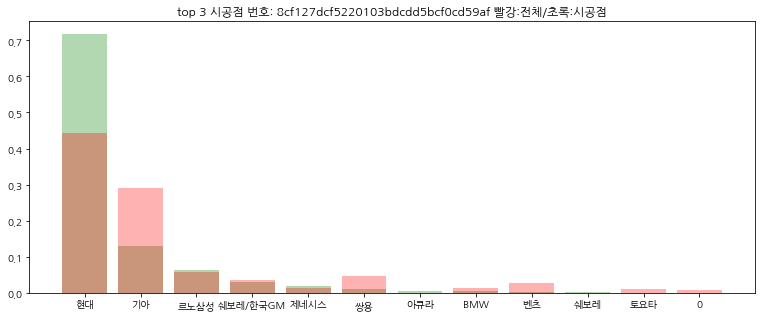

maker
현대          0.457647
기아          0.453599
쉐보레/한국GM    0.034981
르노삼성        0.017635
제네시스        0.010986
쌍용          0.006360
벤츠          0.004626
BMW         0.004047
혼다          0.001446
0           0.001446
Name: regist_dt, dtype: float64


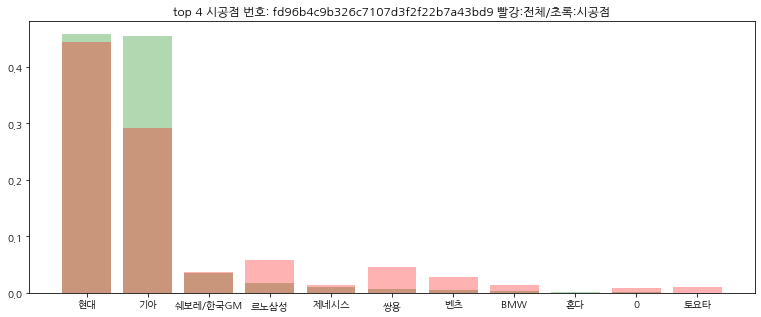

maker
기아          0.507602
현대          0.367360
르노삼성        0.048092
쌍용          0.014583
제네시스        0.011790
쉐보레/한국GM    0.010239
벤츠          0.008688
BMW         0.008067
0           0.003723
아큐라         0.003103
Name: regist_dt, dtype: float64


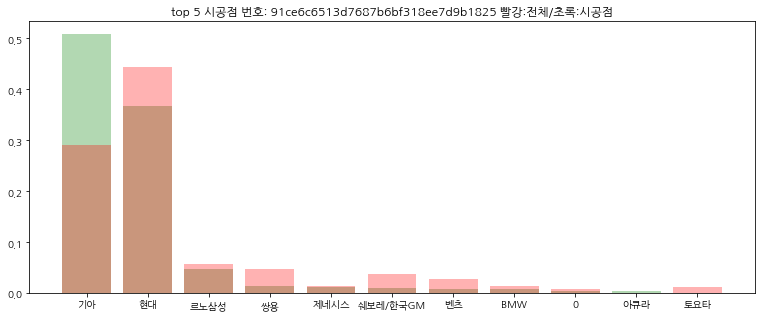

maker
기아          0.535296
현대          0.428300
제네시스        0.011396
아큐라         0.007597
쉐보레/한국GM    0.004432
쌍용          0.004432
르노삼성        0.002532
벤츠          0.001266
BMW         0.000950
0           0.000950
Name: regist_dt, dtype: float64


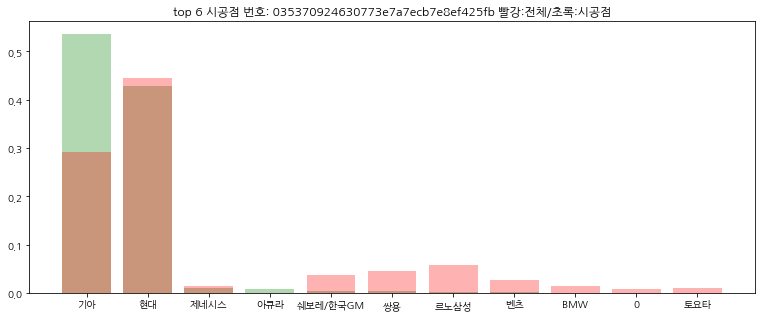

maker
현대          0.430972
기아          0.359143
쌍용          0.125865
쉐보레/한국GM    0.019440
르노삼성        0.016804
제네시스        0.014168
벤츠          0.005601
BMW         0.004942
0           0.004283
아우디         0.003624
Name: regist_dt, dtype: float64


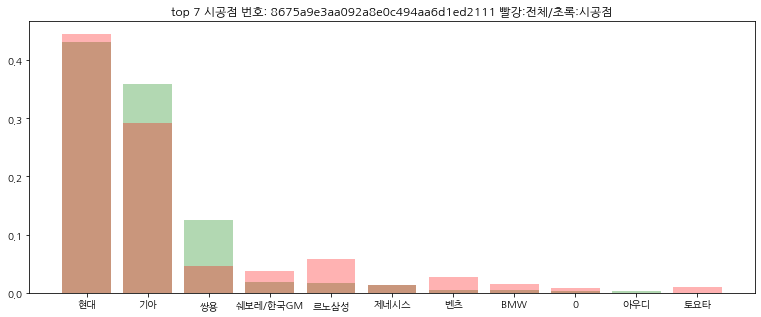

maker
현대          0.471717
기아          0.143897
쉐보레/한국GM    0.079391
벤츠          0.072445
토요타         0.036718
르노삼성        0.029441
렉서스         0.019517
아우디         0.019186
랜드로버        0.017201
제네시스        0.015878
Name: regist_dt, dtype: float64


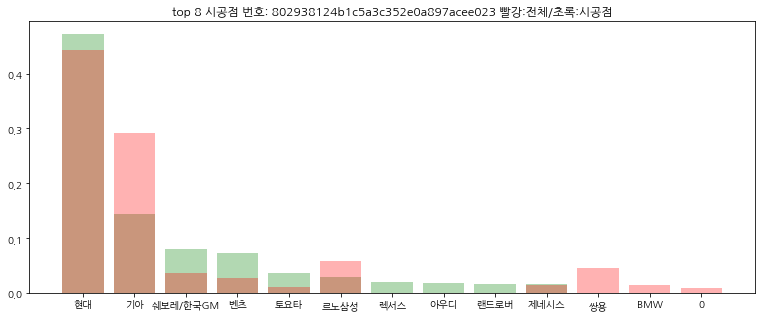

maker
현대      0.531718
기아      0.227726
토요타     0.030292
벤츠      0.026372
포드      0.025303
쌍용      0.021026
BMW     0.020670
제네시스    0.019244
링컨      0.014612
르노삼성    0.013542
Name: regist_dt, dtype: float64


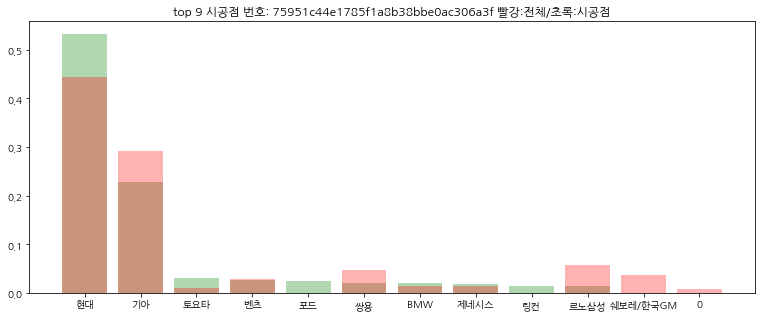

maker
현대          0.655551
기아          0.287285
제네시스        0.020887
쌍용          0.008428
르노삼성        0.006596
아큐라         0.004764
쉐보레/한국GM    0.004031
렉서스         0.004031
폭스바겐        0.001832
아우디         0.001466
Name: regist_dt, dtype: float64


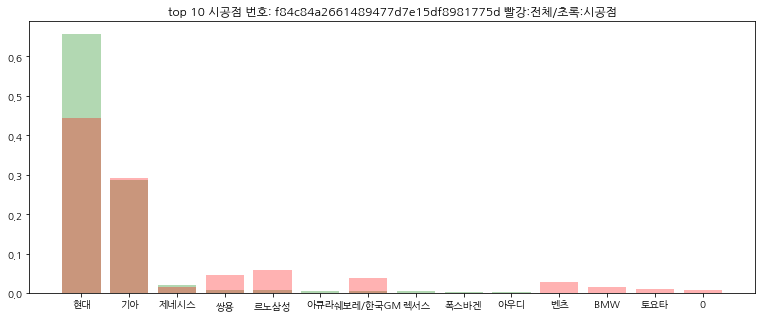

maker
현대          0.483419
기아          0.416360
쌍용          0.030214
쉐보레/한국GM    0.026161
제네시스        0.018791
BMW         0.010317
르노삼성        0.003316
쉐보레         0.002579
0           0.002579
아우디         0.001105
Name: regist_dt, dtype: float64


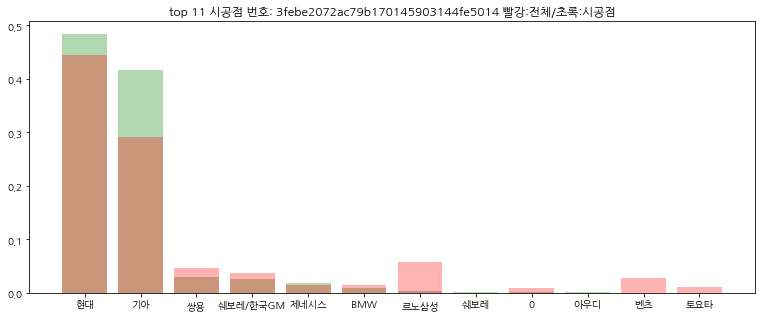

maker
기아          0.540260
현대          0.361410
쌍용          0.034879
제네시스        0.017440
르노삼성        0.010390
쉐보레/한국GM    0.009647
벤츠          0.005195
BMW         0.002968
아우디         0.002968
0           0.002597
Name: regist_dt, dtype: float64


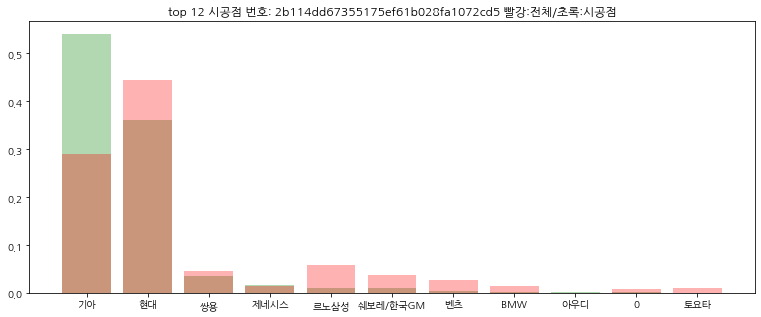

maker
현대          0.668427
기아          0.176914
쉐보레/한국GM    0.084496
르노삼성        0.032063
제네시스        0.019238
쌍용          0.008676
BMW         0.001886
벤츠          0.001509
홀덴          0.001132
쉐보레         0.000754
Name: regist_dt, dtype: float64


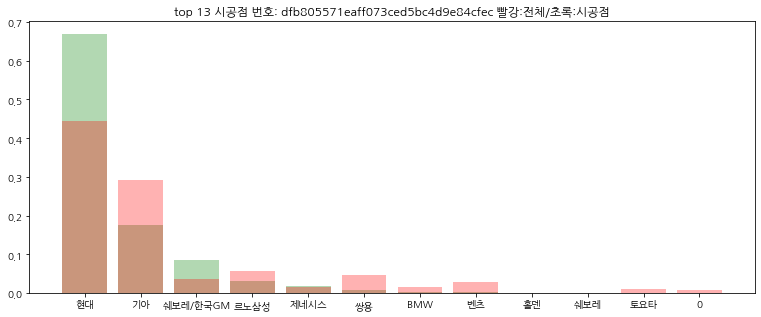

maker
현대          0.414856
기아          0.327539
쌍용          0.100751
쉐보레/한국GM    0.056104
볼보          0.020150
제네시스        0.018965
르노삼성        0.013829
벤츠          0.008692
아우디         0.005927
BMW         0.004741
Name: regist_dt, dtype: float64


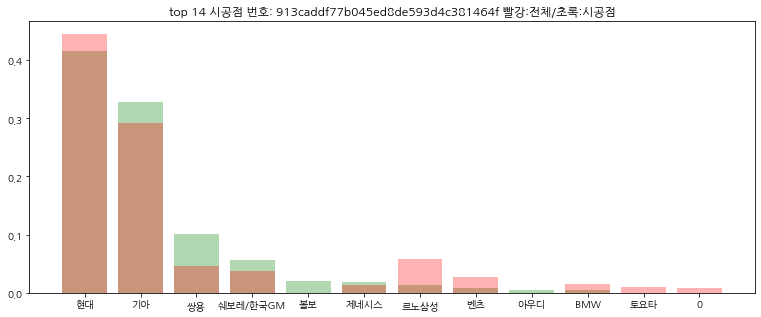

maker
기아          0.579631
현대          0.364208
쌍용          0.035205
제네시스        0.014250
쉐보레/한국GM    0.002934
르노삼성        0.001676
아큐라         0.000838
혼다          0.000419
토요타         0.000419
Name: regist_dt, dtype: float64


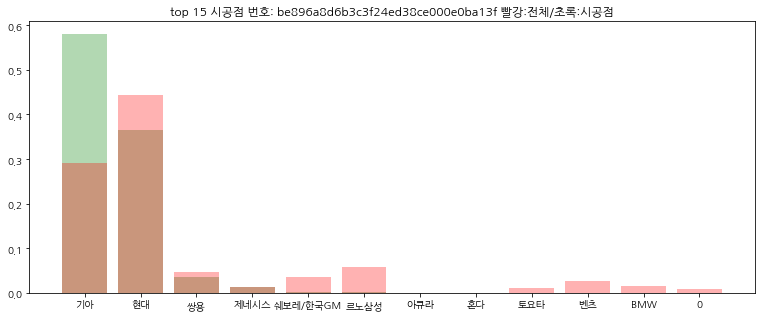

maker
기아          0.422980
현대          0.385101
쌍용          0.033670
르노삼성        0.026515
쉐보레/한국GM    0.021044
벤츠          0.020623
BMW         0.018519
제네시스        0.013889
0           0.009259
아우디         0.008418
Name: regist_dt, dtype: float64


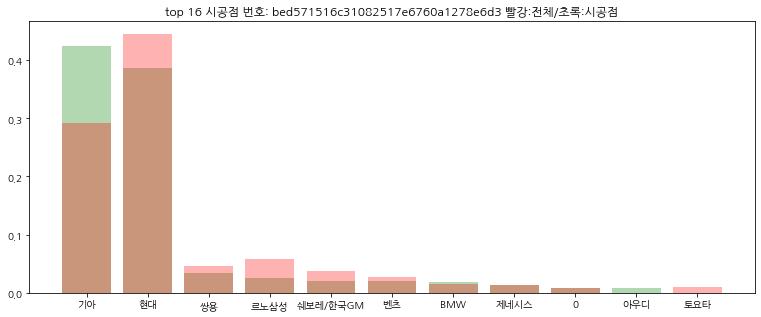

maker
현대          0.411244
기아          0.395750
쌍용          0.049137
쉐보레/한국GM    0.035414
르노삼성        0.025675
제네시스        0.015494
BMW         0.011952
볼보          0.010181
폭스바겐        0.006640
벤츠          0.006197
Name: regist_dt, dtype: float64


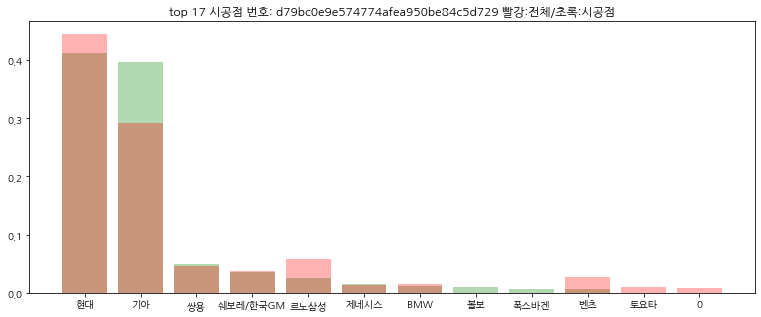

maker
현대          0.500000
기아          0.255595
렉서스         0.041182
쌍용          0.026410
토요타         0.021486
벤츠          0.018353
테슬라         0.017010
BMW         0.016562
쉐보레/한국GM    0.016562
르노삼성        0.015219
Name: regist_dt, dtype: float64


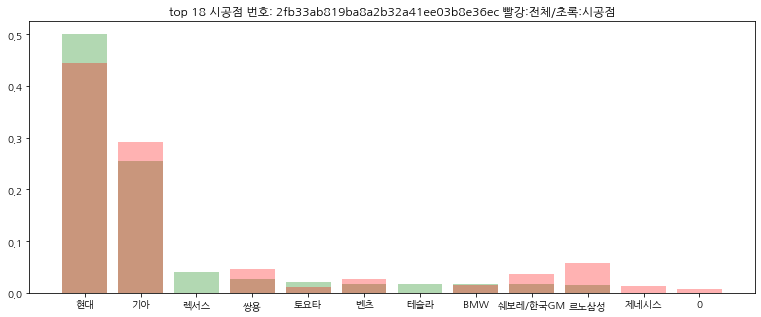

maker
현대          0.447476
기아          0.349704
쉐보레/한국GM    0.102319
쌍용          0.064120
르노삼성        0.010005
제네시스        0.008186
쉐보레         0.003638
홀덴          0.002274
아큐라         0.002274
벤츠          0.001819
Name: regist_dt, dtype: float64


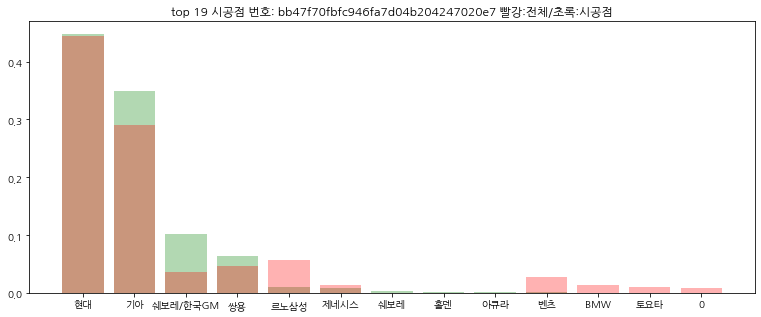

maker
현대          0.575399
기아          0.250114
쉐보레/한국GM    0.078360
제네시스        0.029157
쌍용          0.014579
볼보          0.009567
벤츠          0.008200
BMW         0.007289
르노삼성        0.007289
쉐보레         0.004100
Name: regist_dt, dtype: float64


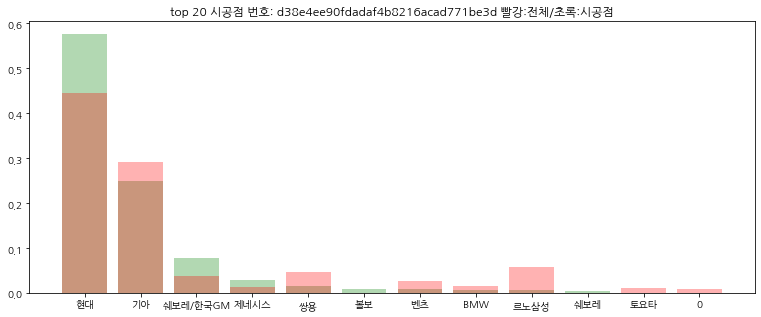

maker
현대          0.487905
기아          0.343977
쌍용          0.036738
쉐보레/한국GM    0.033422
르노삼성        0.029354
제네시스        0.016271
벤츠          0.009602
BMW         0.006631
토요타         0.004004
0           0.003940
Name: regist_dt, dtype: float64


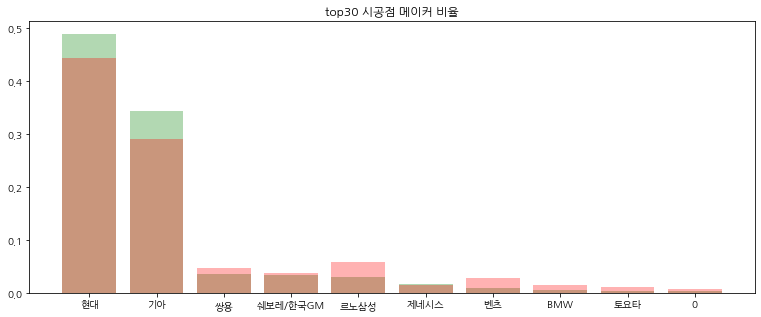

In [ ]:
#시공점 별 메이커 비율
total_counts = total_df_item_store.groupby(['maker'])['regist_dt'].count()/len(total_df_item_store)
print(total_counts.sort_values(ascending=False)[0:10])
plt.figure(figsize = (13,5))
plt.title('메이커 비율')
plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10])
plt.show()

for i in top_stores[0:20]:
  counts = total_df_item_store[total_df_item_store['store'] == i].groupby(['maker'])['regist_dt'].count().sort_values(ascending=False)[0:10]/len(total_df_item_store[total_df_item_store['store'] == i])
  print(counts)
  plt.figure(figsize = (13,5))
  plt.title(f'top {top_stores.index(i)+1} 시공점 번호: '+i+' 빨강:전체/초록:시공점')
  plt.bar(x = counts.index, height = counts, color='green', alpha=.3)
  plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10], color='red', alpha=.3)
  plt.show()

counts_top30 = total_df_item_store[total_df_item_store['store'].isin(top_stores)].groupby(['maker'])['regist_dt'].count().sort_values(ascending=False)[0:10]/len(total_df_item_store[total_df_item_store['store'].isin(top_stores)])
print(counts_top30)
plt.figure(figsize = (13,5))
plt.title(f'top30 시공점 메이커 비율')
plt.bar(x = counts_top30.index, height = counts_top30, color='green', alpha=.3)
plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10], color='red', alpha=.3)
plt.show()

## 시공 아이템에 따른 가격차이가 나는지 확인 (인기품목대로 정렬)

In [ ]:
item_count = total_df_item_store.groupby(['product_1_name','com_type'])['regist_dt'].count().reset_index()
popular_order = list(item_count[item_count['com_type'] == '1. 측2 후 전 '].sort_values(by = 'regist_dt', ascending=False).product_1_name)


In [ ]:
item_price2_p1_t1

product_1_name    com_type         price
52         Tundra  1. 측2 후 전   2.700000e+06
58    Vertex 1100  1. 측2 후 전   2.006000e+06
77     Vertex 900  1. 측2 후 전   1.319850e+06
54         Vertex  1. 측2 후 전   1.300000e+06
7         Bisanti  1. 측2 후 전   1.138333e+06
71     Vertex 700  1. 측2 후 전   9.726357e+05
65     Vertex 600  1. 측2 후 전   8.928571e+05
50            TNT  1. 측2 후 전   8.618750e+05
17       Latitude  1. 측2 후 전   8.363068e+05
12         Cirrus  1. 측2 후 전   8.200000e+05
66     Vertex 650  1. 측2 후 전   7.890909e+05
26       Pinnacle  1. 측2 후 전   7.041429e+05
0         Artisan  1. 측2 후 전   6.666279e+05
45          Super  1. 측2 후 전   6.161570e+05
36           Star  1. 측2 후 전   5.510993e+05
61     Vertex 500  1. 측2 후 전   5.361538e+05

In [ ]:

item_price2_p1_t1['item_order'] = pd.Categorical(
    item_price2_p1_t1['product_1_name'], 
    categories=popular_order, 
    ordered=True
)
item_price2_p1_t1.sort_values('item_order')

product_1_name    com_type         price   item_order
0         Artisan  1. 측2 후 전   6.666279e+05      Artisan
45          Super  1. 측2 후 전   6.161570e+05        Super
36           Star  1. 측2 후 전   5.510993e+05         Star
17       Latitude  1. 측2 후 전   8.363068e+05     Latitude
71     Vertex 700  1. 측2 후 전   9.726357e+05   Vertex 700
61     Vertex 500  1. 측2 후 전   5.361538e+05   Vertex 500
50            TNT  1. 측2 후 전   8.618750e+05          TNT
77     Vertex 900  1. 측2 후 전   1.319850e+06   Vertex 900
26       Pinnacle  1. 측2 후 전   7.041429e+05     Pinnacle
66     Vertex 650  1. 측2 후 전   7.890909e+05   Vertex 650
7         Bisanti  1. 측2 후 전   1.138333e+06      Bisanti
65     Vertex 600  1. 측2 후 전   8.928571e+05   Vertex 600
54         Vertex  1. 측2 후 전   1.300000e+06       Vertex
58    Vertex 1100  1. 측2 후 전   2.006000e+06  Vertex 1100
12         Cirrus  1. 측2 후 전   8.200000e+05       Cirrus
52         Tundra  1. 측2 후 전   2.700000e+06       Tundra

### 전면 시공 아이템에 따른 가격차이가 나는지 확인 (인기품목대로 정렬)


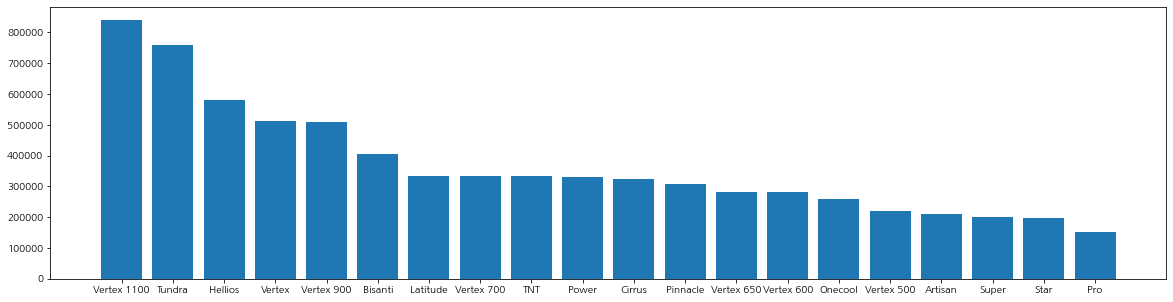

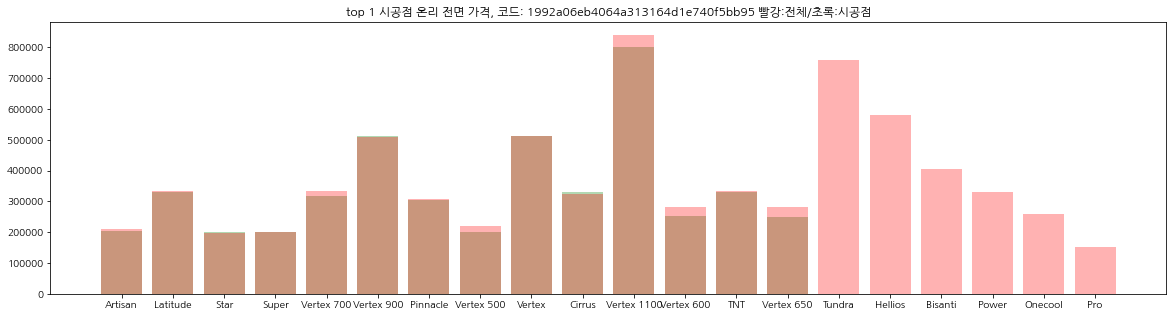

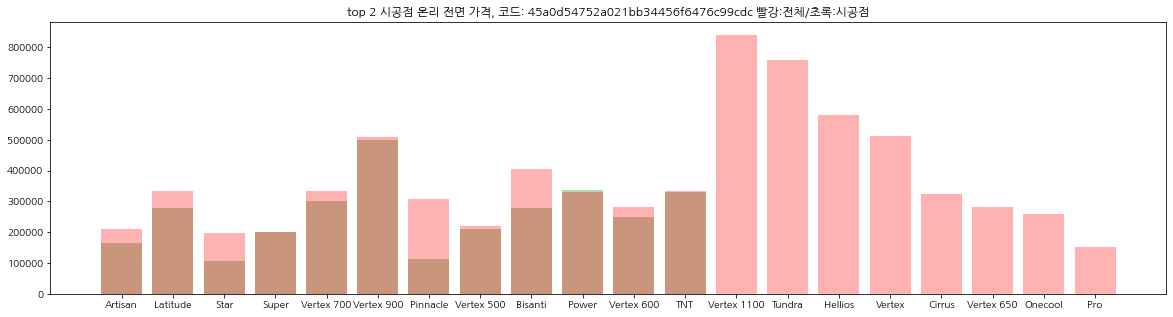

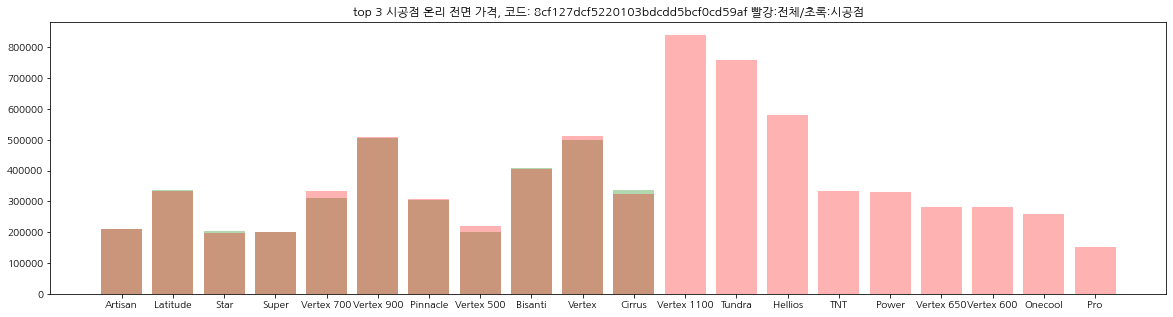

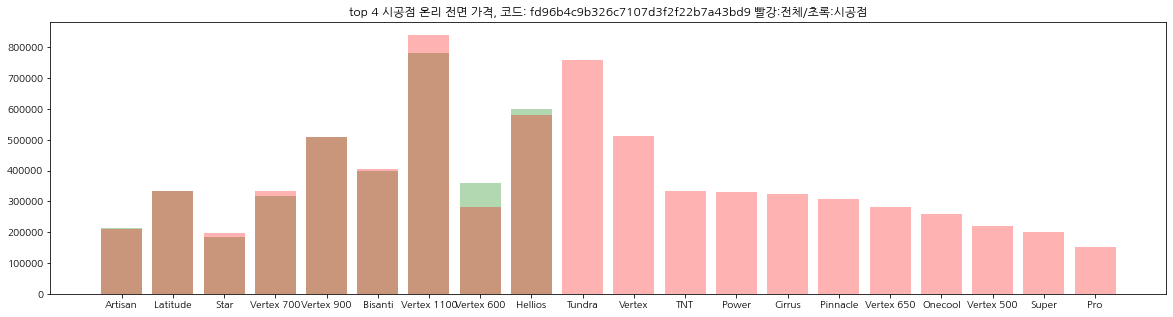

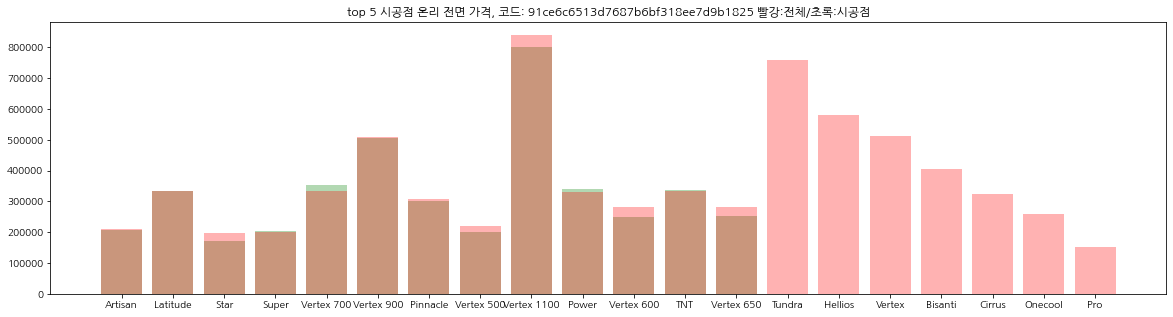

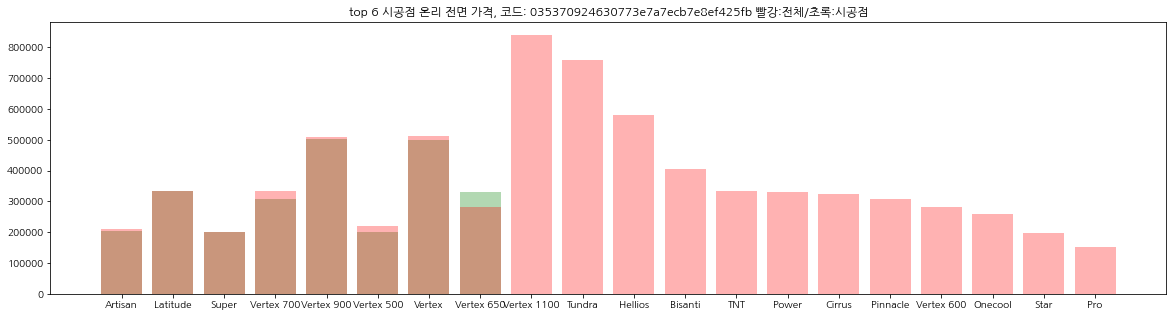

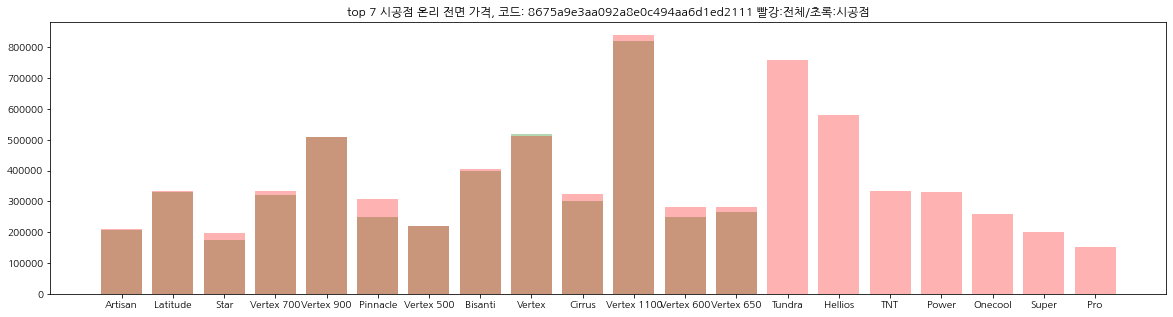

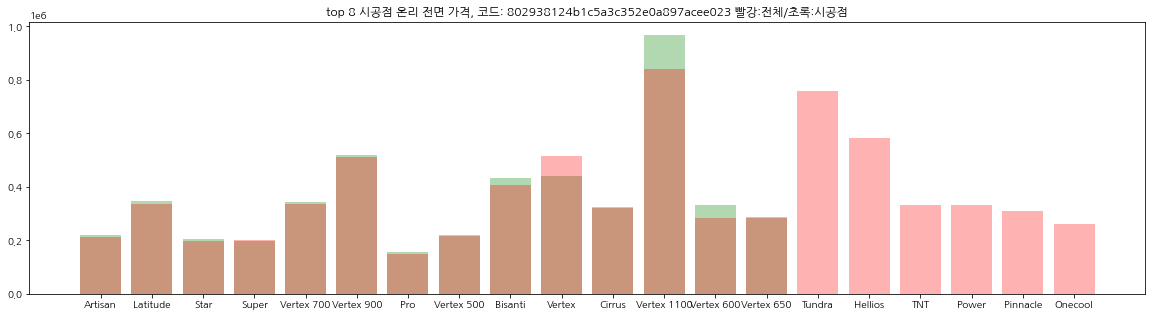

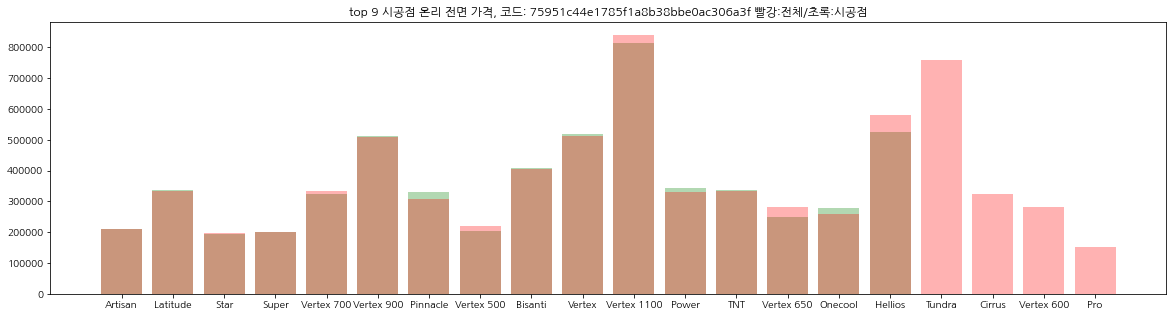

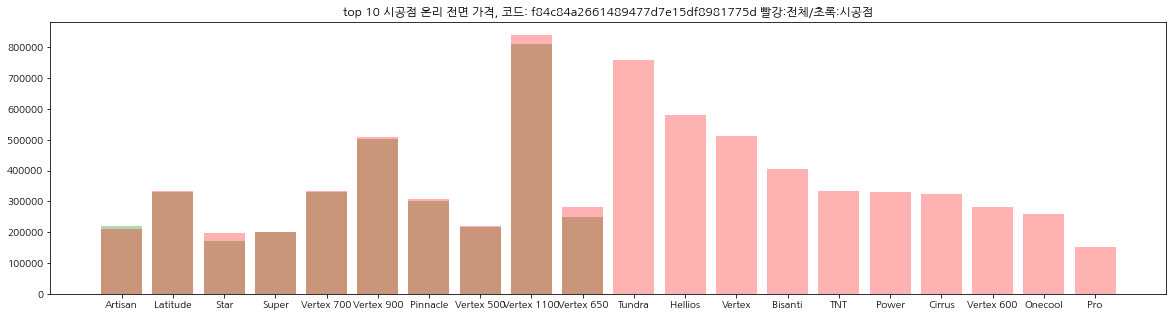

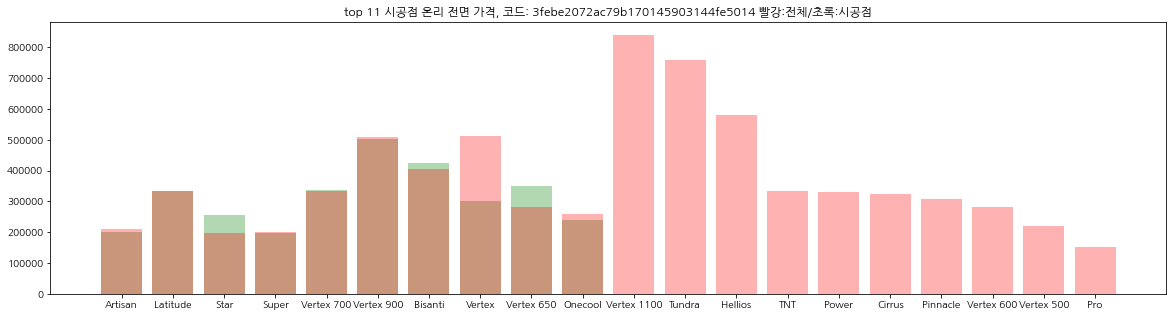

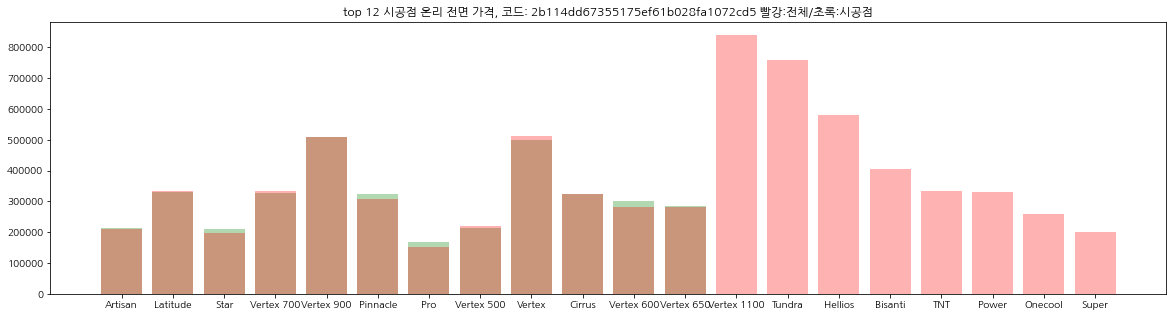

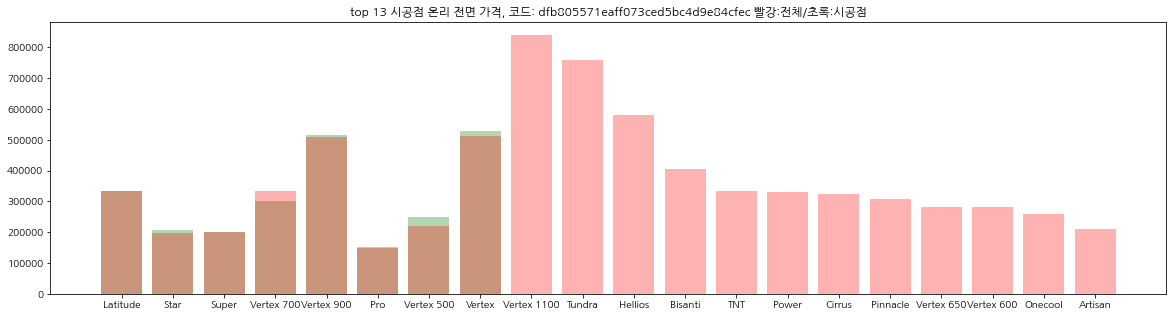

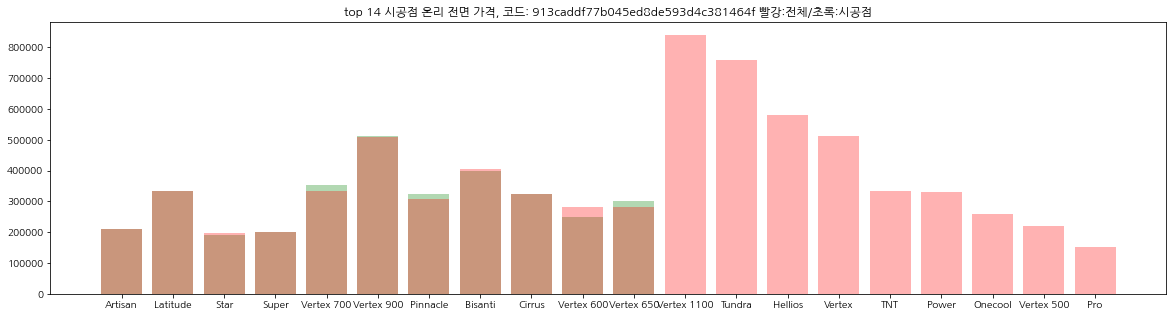

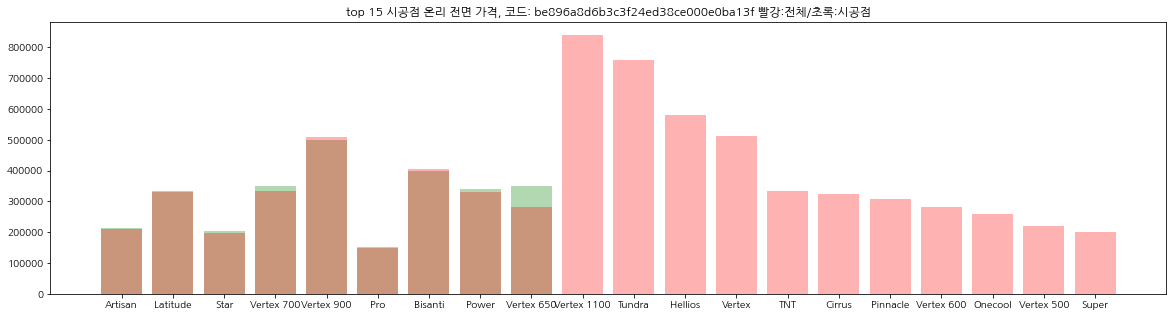

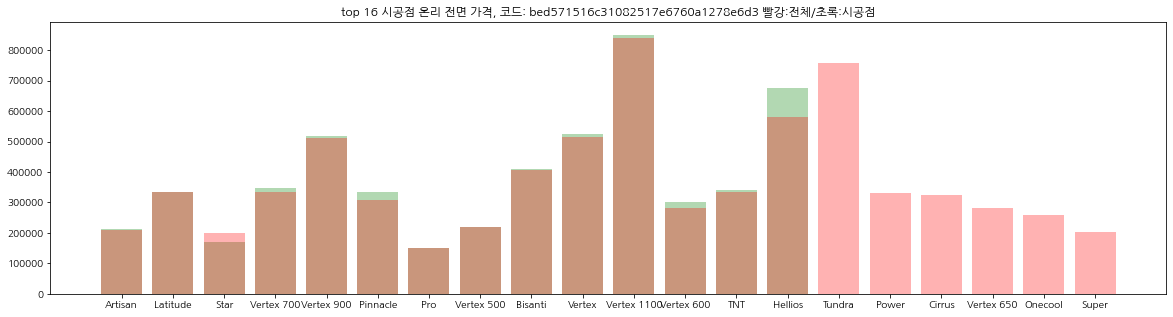

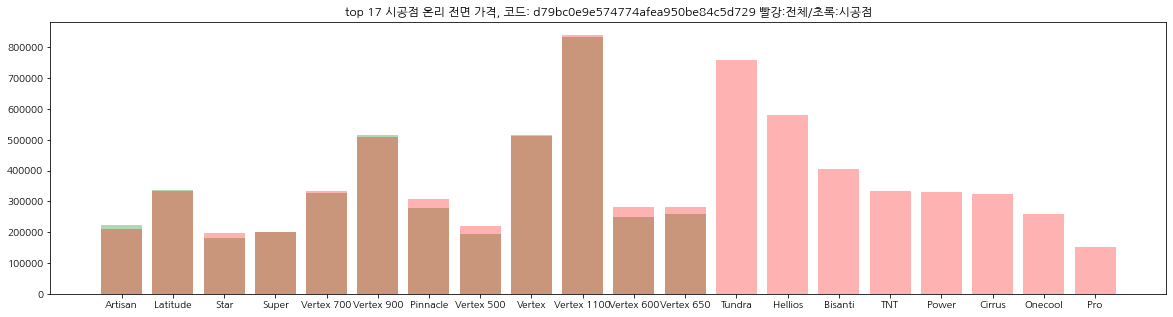

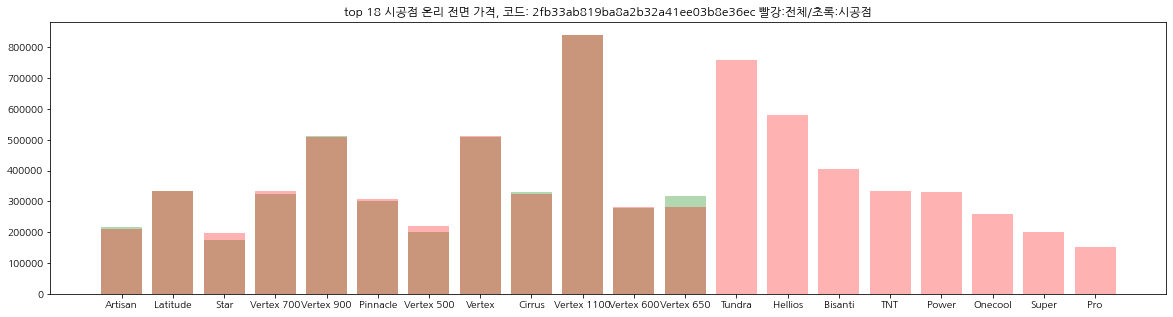

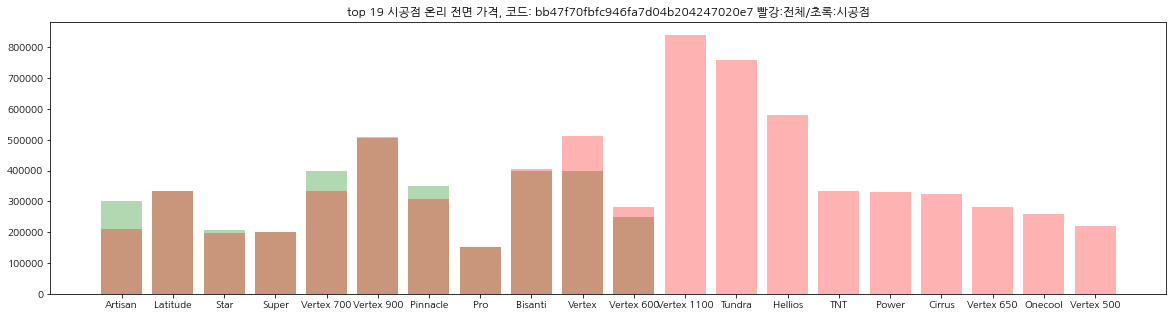

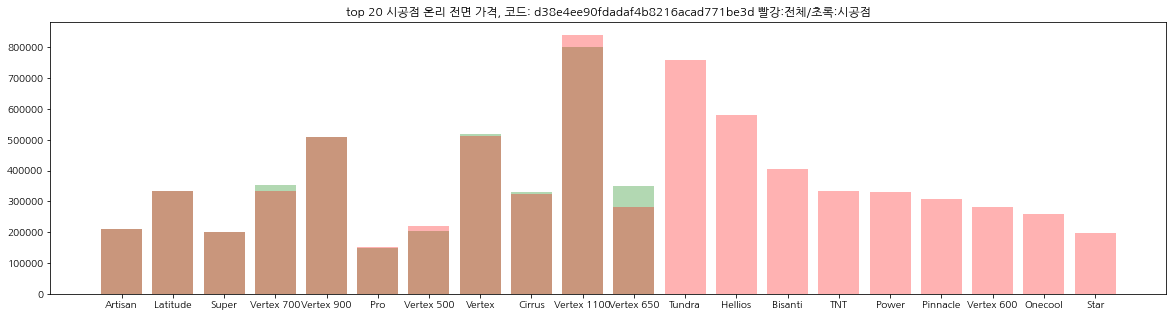

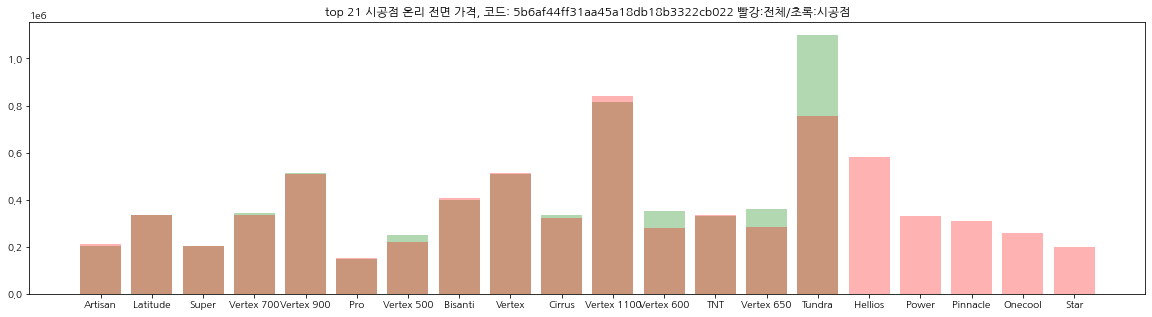

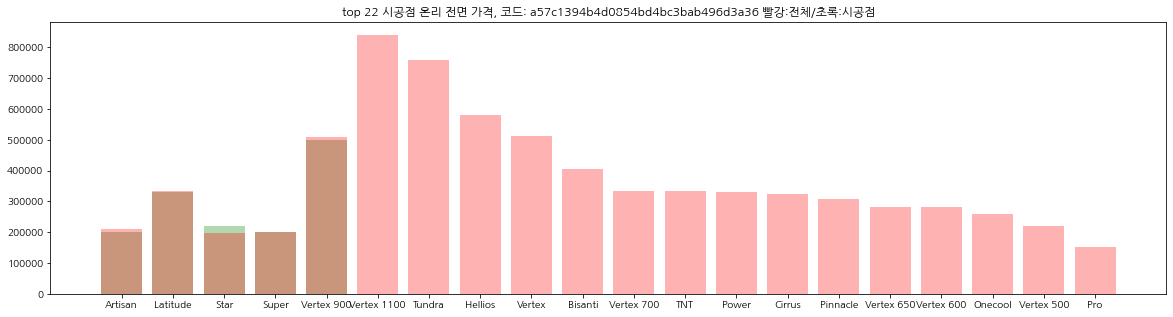

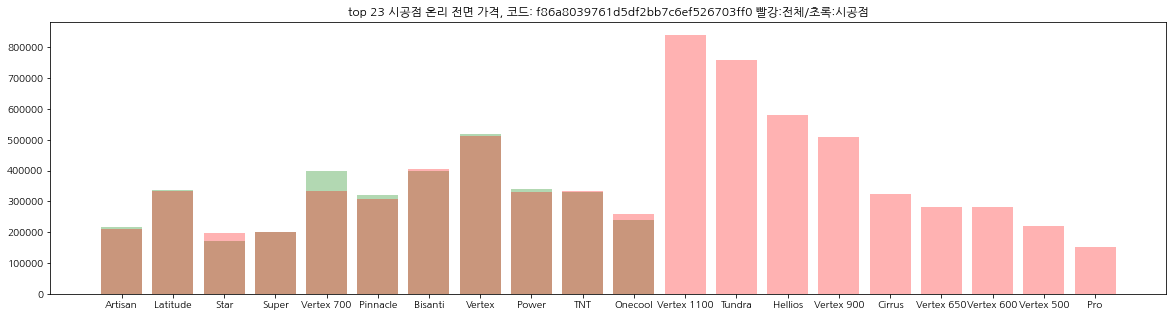

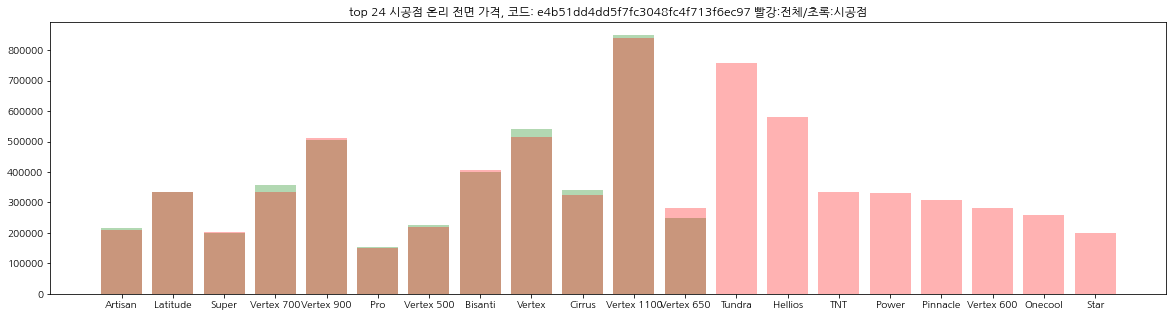

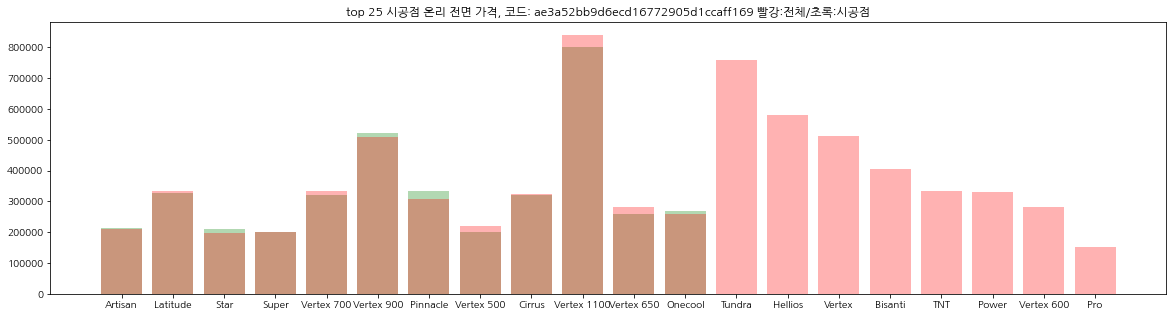

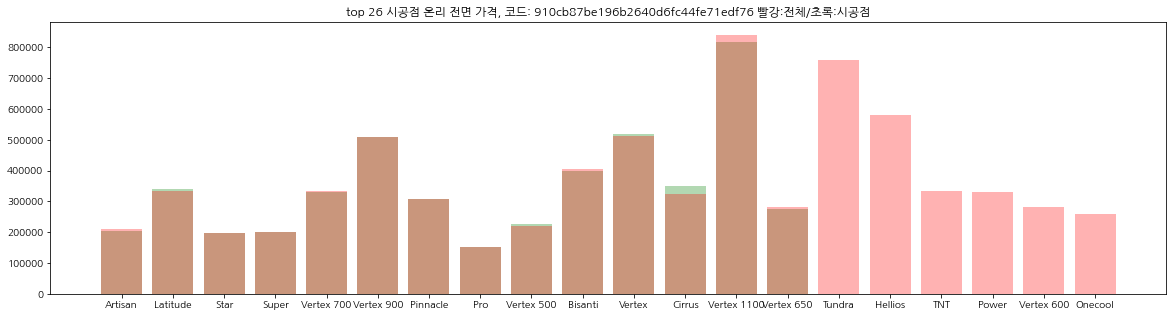

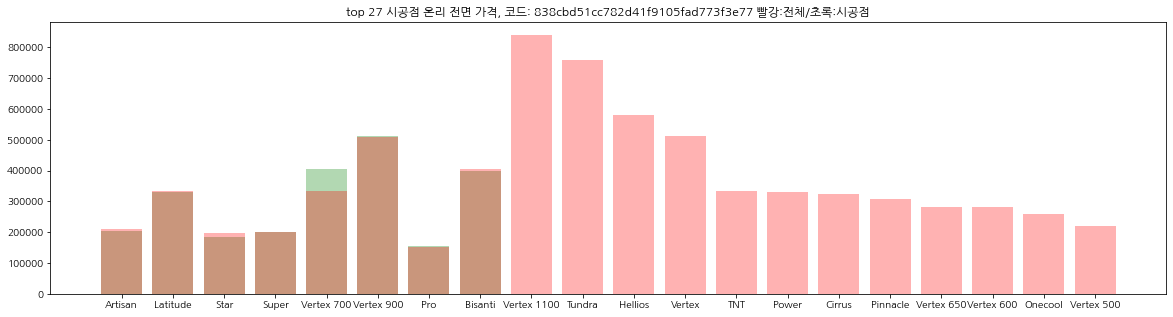

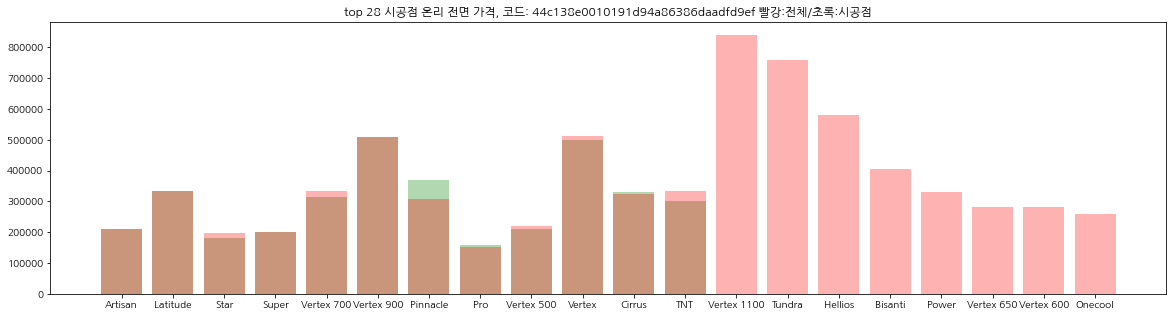

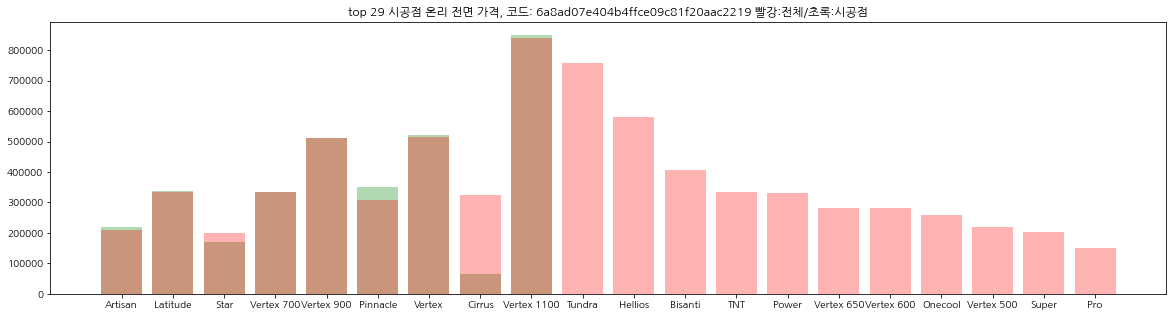

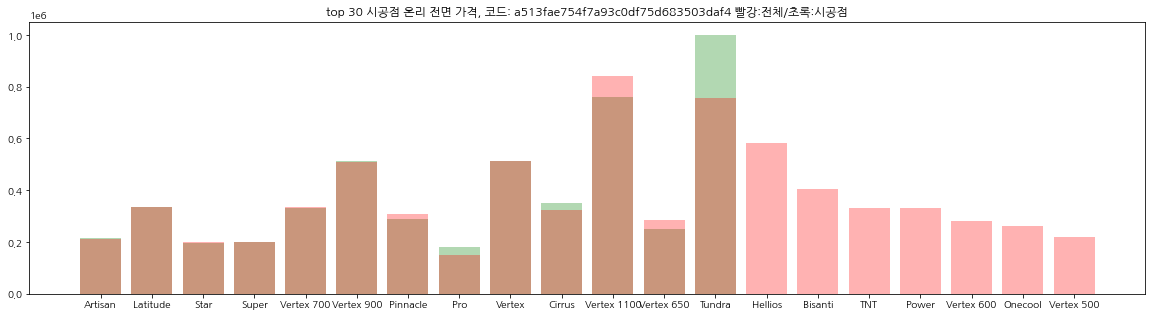

In [ ]:
## 측2 후 전 시공 아이템에 따른 가격차이가 나는지 확인 (인기품목대로 정렬)
item_price = total_df_item_store.groupby(['product_5_name','com_type'])['price'].mean().reset_index()
item_price_p5_t2 = item_price[item_price['com_type'] == '2. 전'].sort_values(by = 'price', ascending=False)
plt.figure(figsize = (20,5))
plt.bar(item_price_p5_t2.product_5_name,item_price_p5_t2.price)
plt.show()

item_count = total_df_item_store.groupby(['product_5_name','com_type'])['regist_dt'].count().reset_index()

popular_order2 = list(item_count[item_count['com_type'] == '2. 전'].sort_values(by = 'regist_dt', ascending=False).product_5_name)

for i in top_stores:
  item_price2 = total_df_item_store[total_df_item_store.store == i].groupby(['product_5_name','com_type'])['price'].mean().reset_index()
  item_price2_p5_t2 = item_price2[item_price2['com_type'] == '2. 전'].sort_values(by = 'price', ascending=False)
  item_price2_p5_t2['item_order'] = pd.Categorical(
    item_price2_p5_t2['product_5_name'], 
    categories=popular_order2, 
    ordered=True
  )
  item_price2_p5_t2=item_price2_p5_t2.sort_values('item_order')
  
  plt.figure(figsize = (20,5))
  plt.title(f'top {top_stores.index(i)+1} 시공점 온리 전면 가격, 코드: '+i+' 빨강:전체/초록:시공점')
  plt.bar(item_price2_p5_t2.product_5_name,item_price2_p5_t2.price, color='green', alpha=.3)
  plt.bar(item_price_p5_t2.product_5_name,item_price_p5_t2.price, color='red', alpha=.3)
  plt.show()


### 측면2 후면 전면 시공 아이템에 따른 가격차이가 나는지 확인 (인기품목대로 정렬)

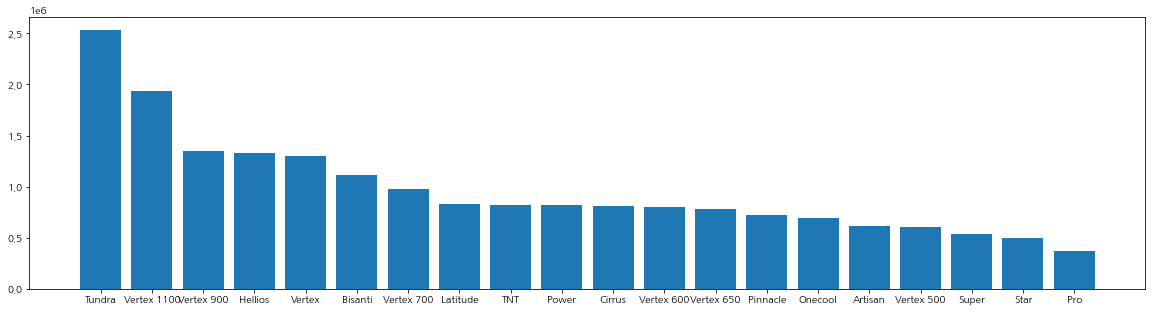

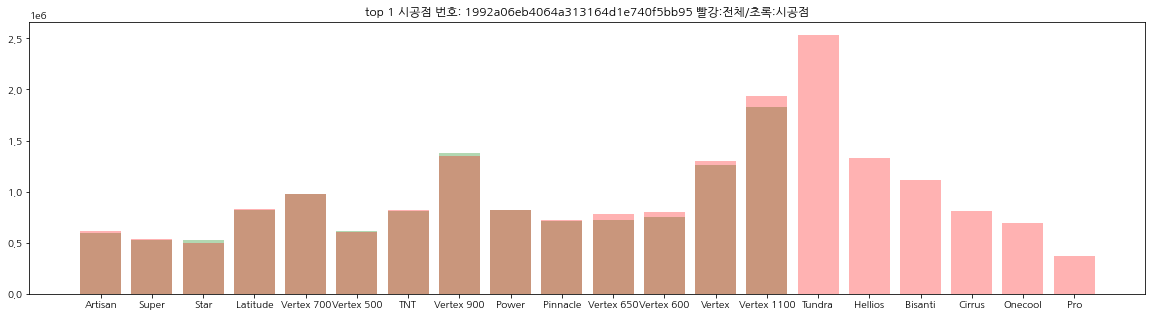

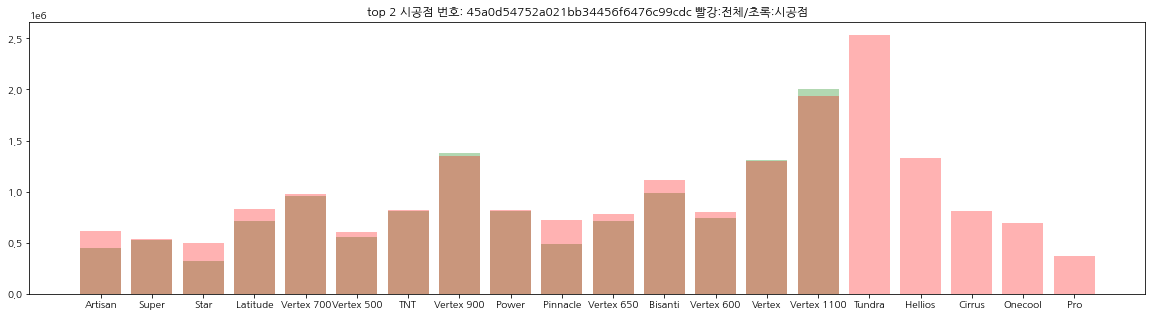

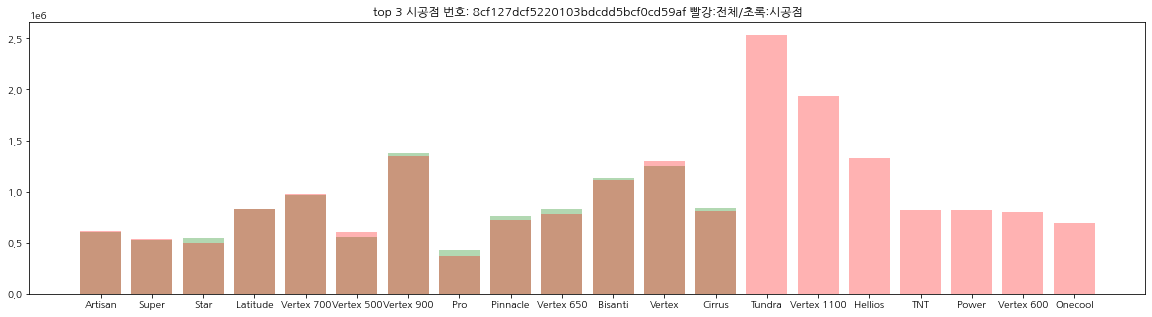

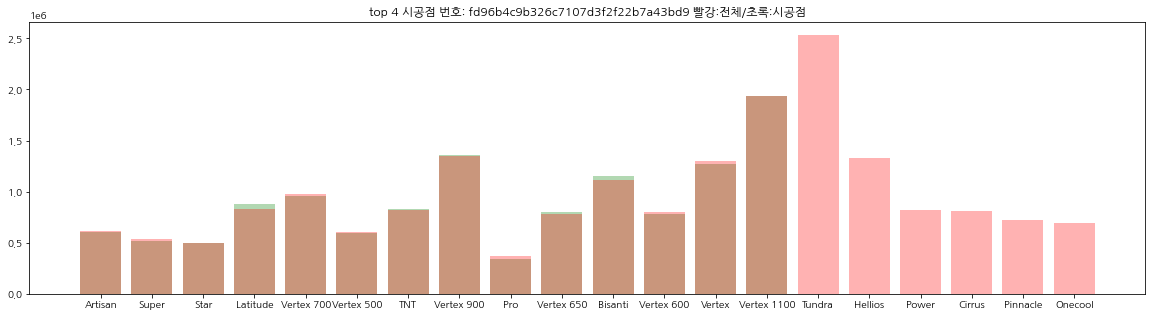

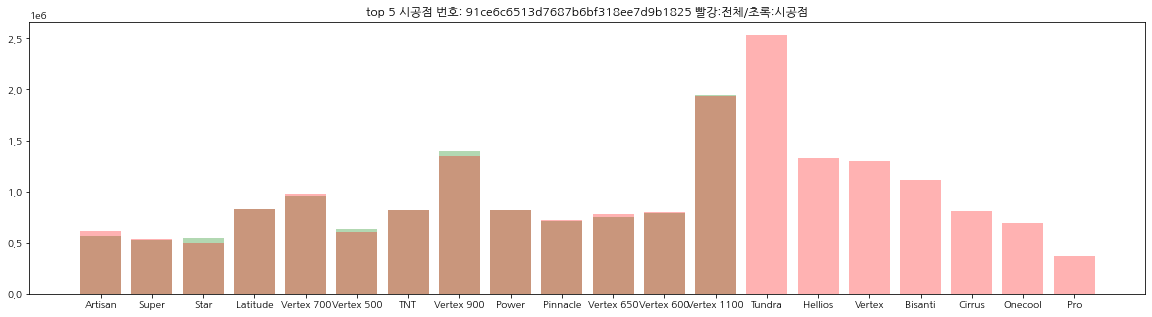

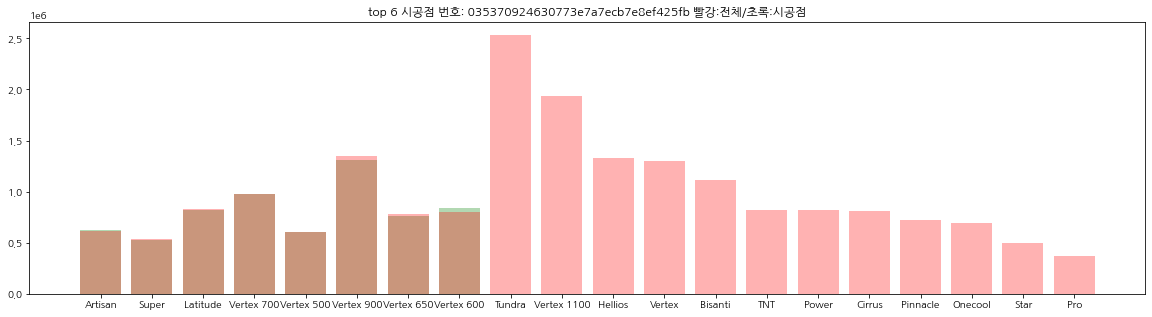

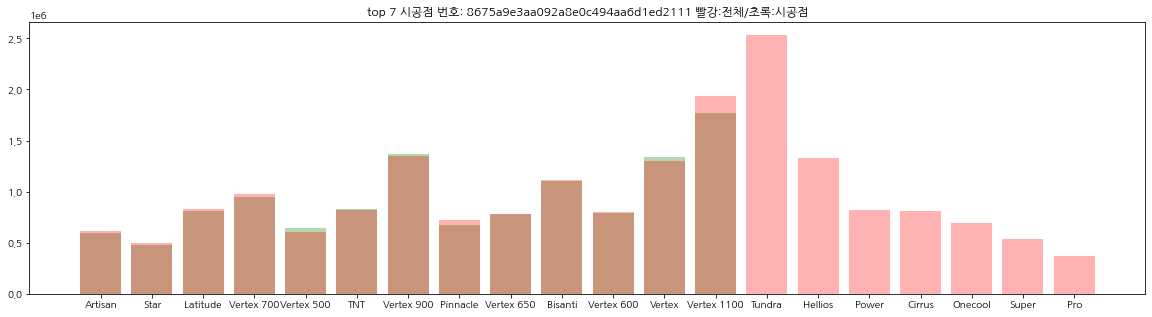

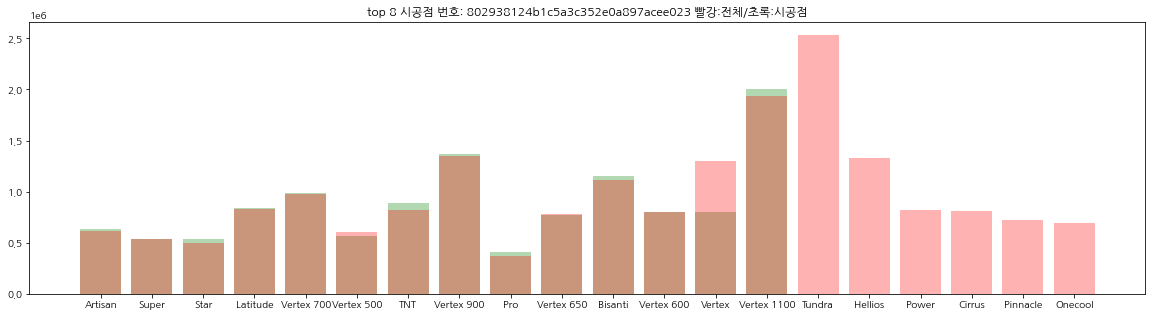

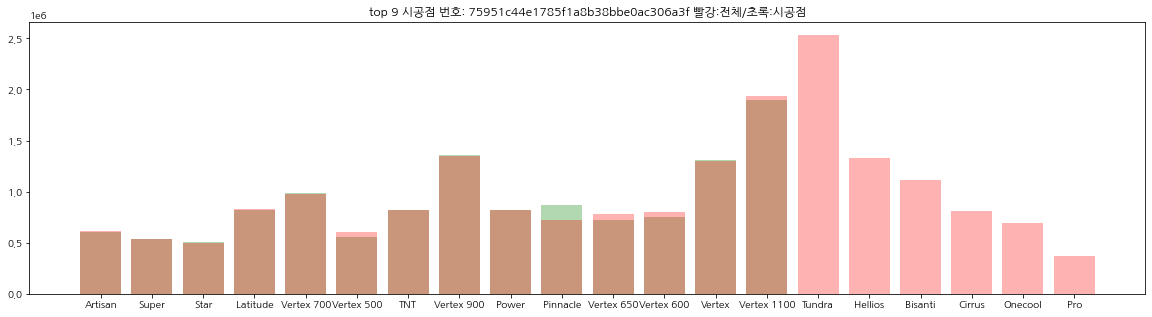

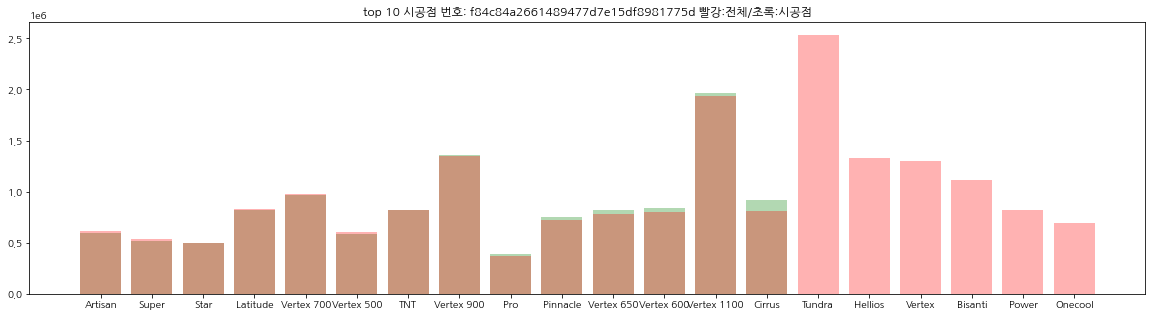

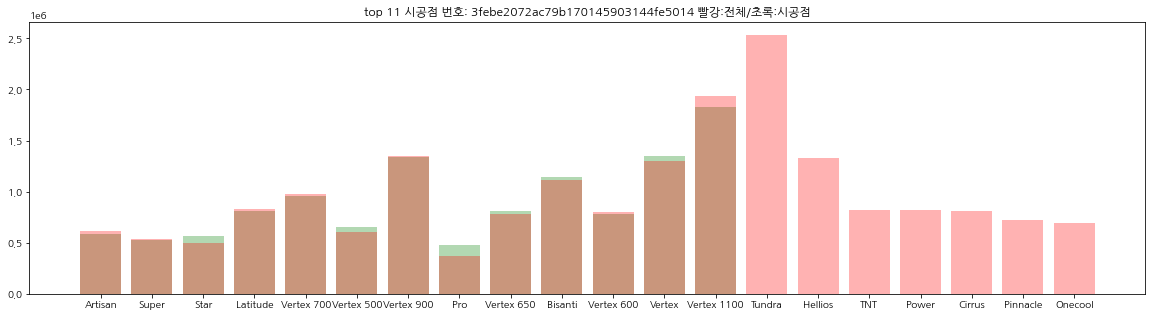

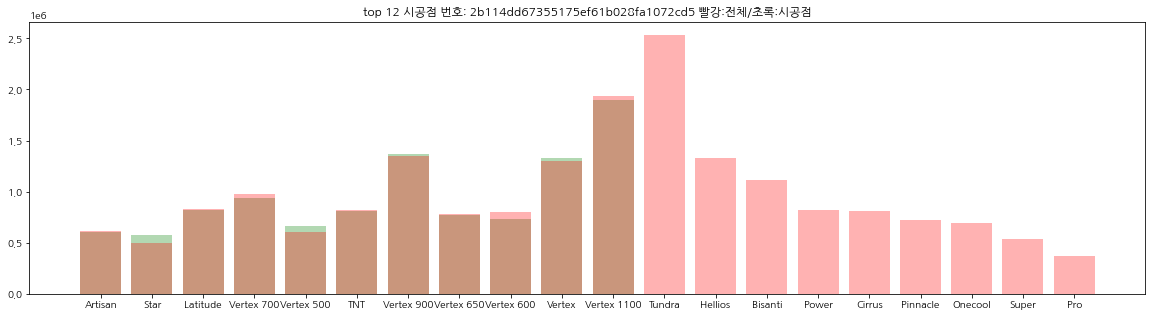

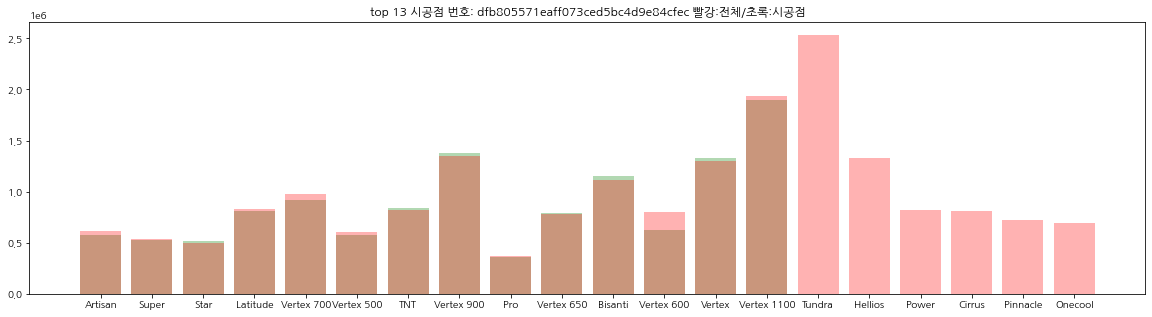

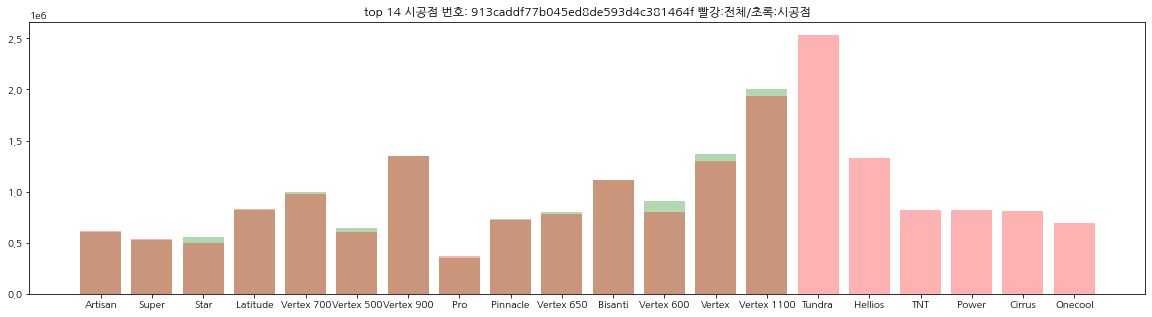

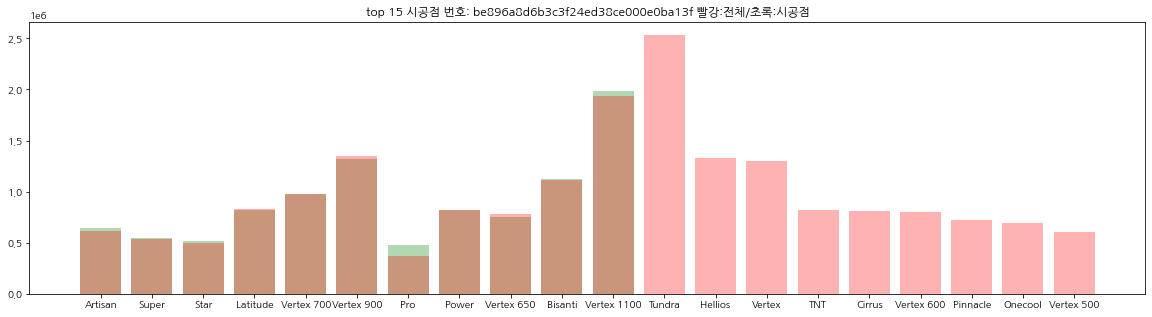

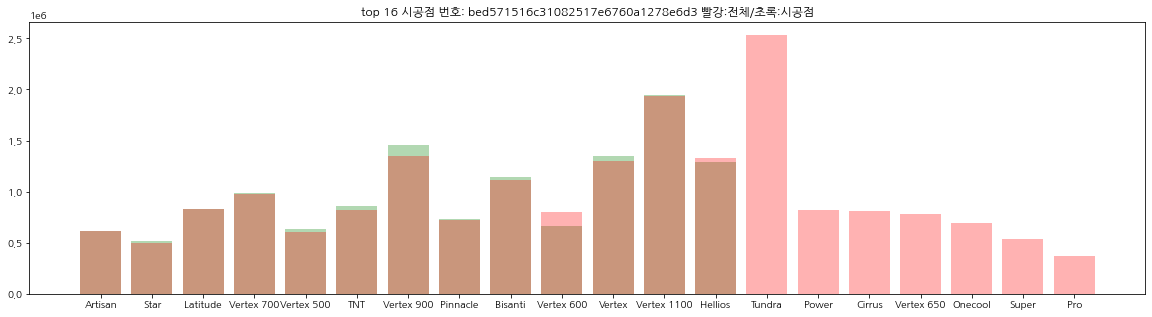

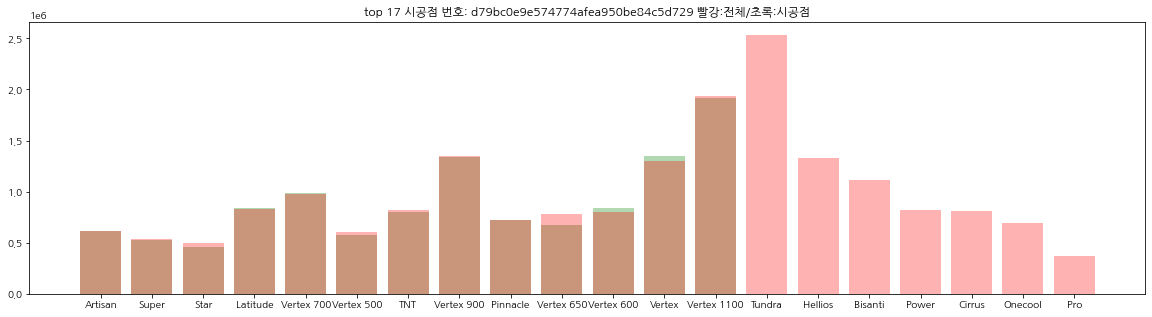

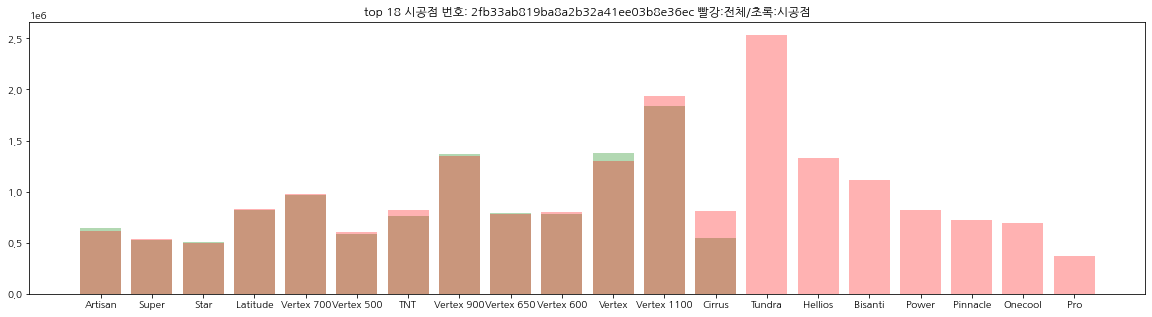

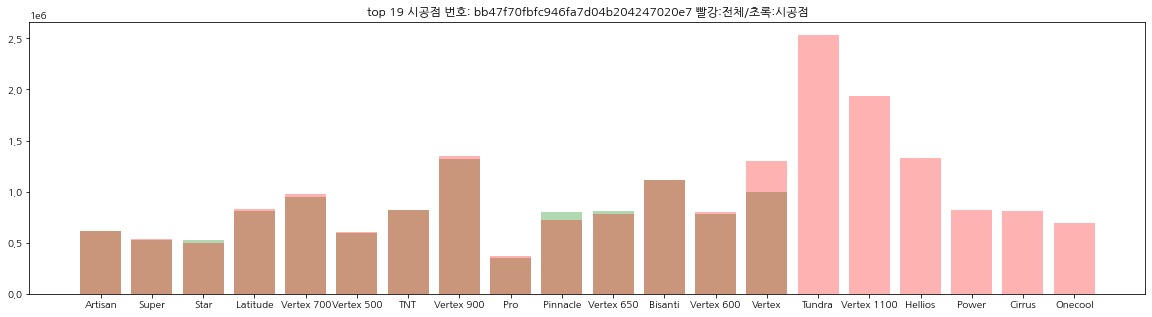

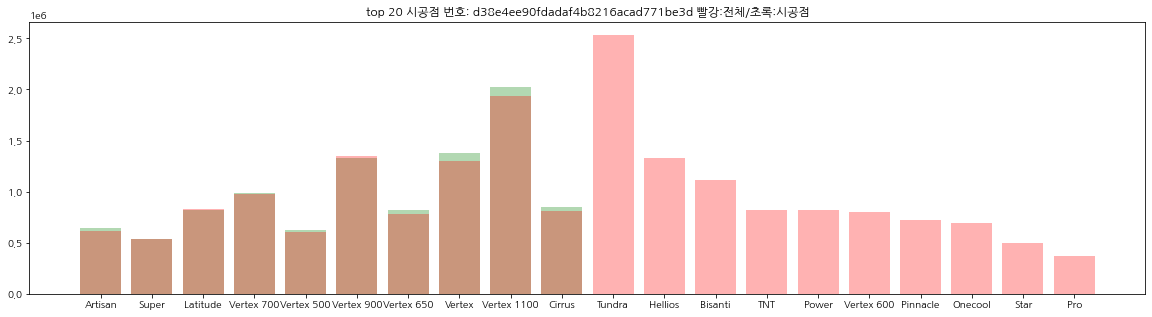

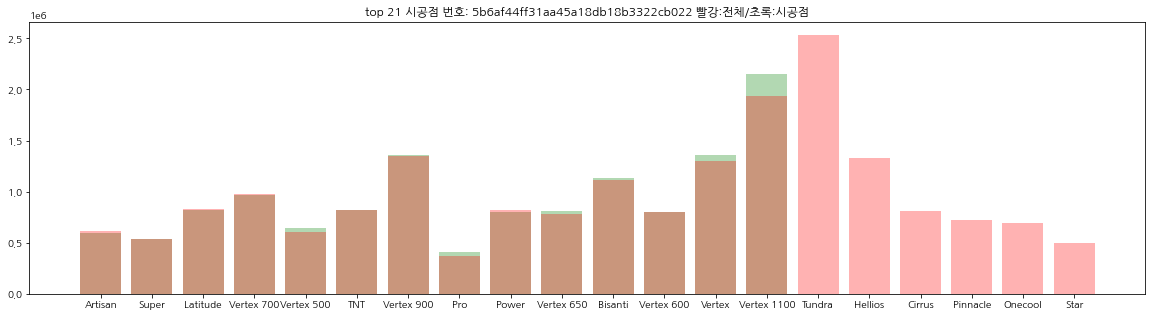

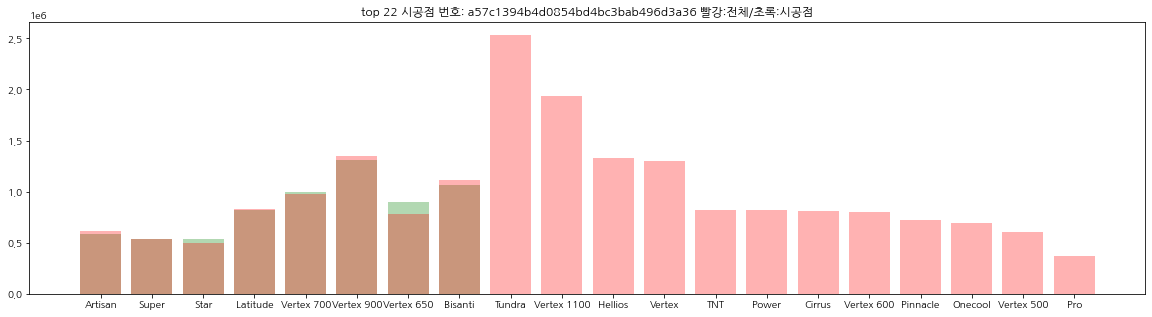

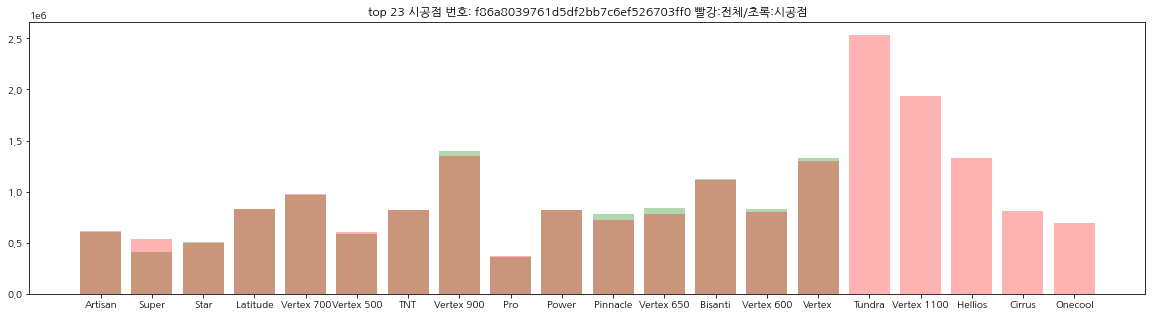

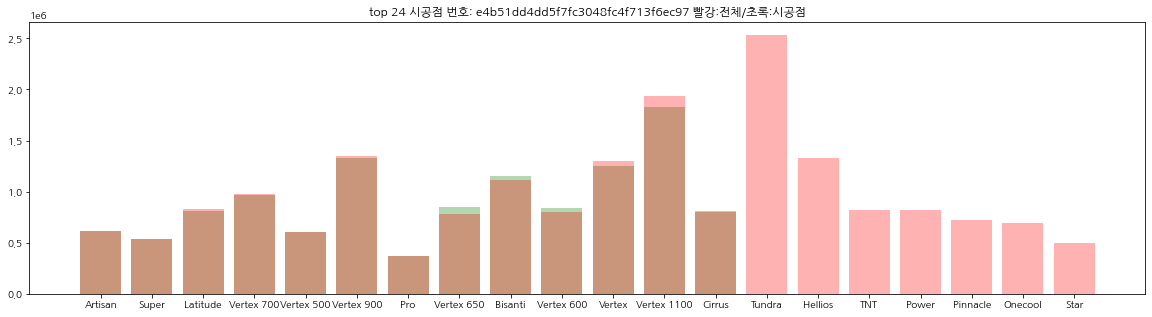

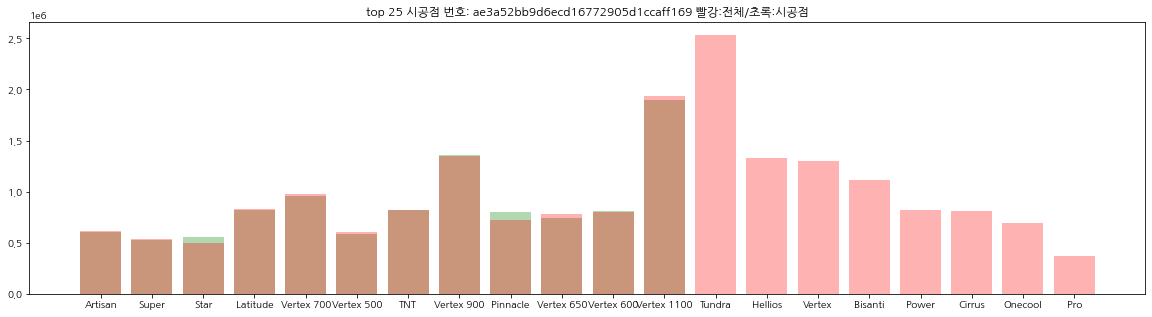

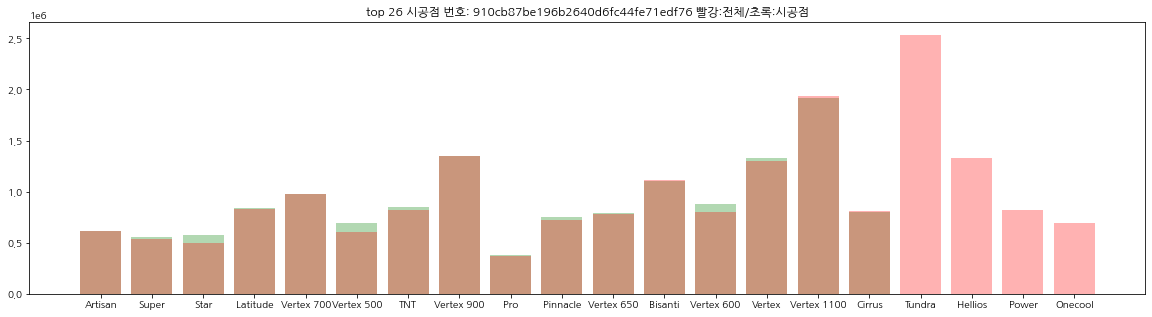

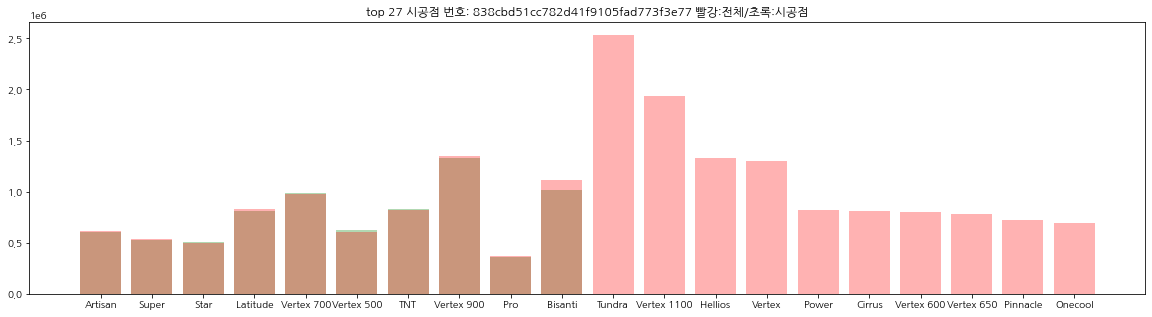

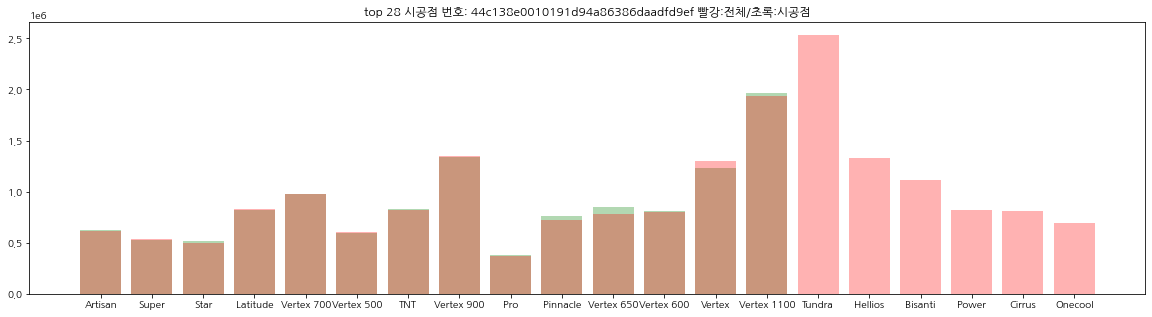

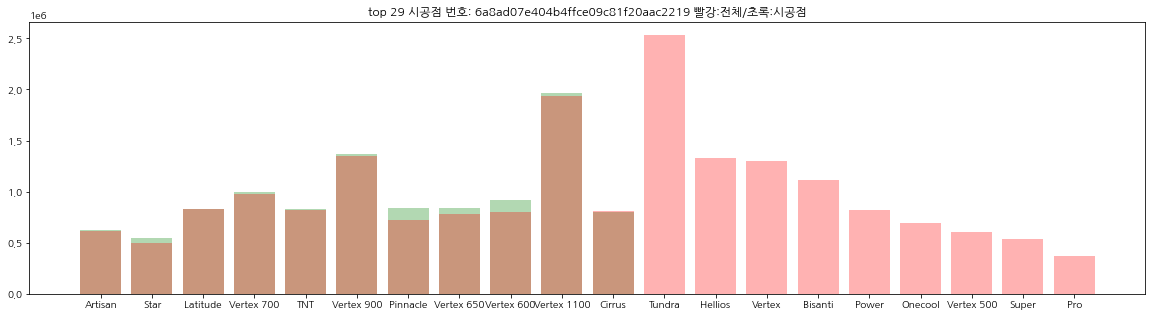

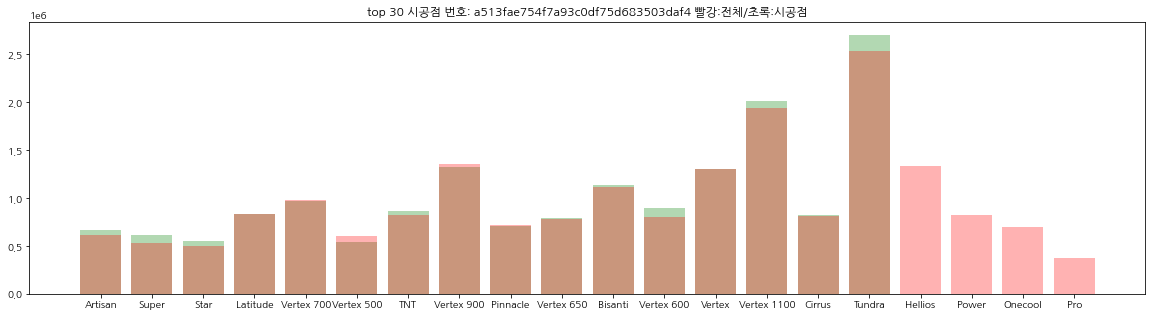

In [ ]:
## 전 시공 아이템에 따른 가격차이가 나는지 확인 (인기품목대로 정렬)
item_price = total_df_item_store.groupby(['product_1_name','com_type'])['price'].mean().reset_index()
item_price_p1_t1 = item_price[item_price['com_type'] == '1. 측2 후 전 '].sort_values(by = 'price', ascending=False)
plt.figure(figsize = (20,5))
plt.bar(item_price_p1_t1.product_1_name,item_price_p1_t1.price)
plt.show()

for i in top_stores:
  item_price2 = total_df_item_store[total_df_item_store.store == i].groupby(['product_1_name','com_type'])['price'].mean().reset_index()
  item_price2_p1_t1 = item_price2[item_price2['com_type'] == '1. 측2 후 전 '].sort_values(by = 'price', ascending=False)
  item_price2_p1_t1['item_order'] = pd.Categorical(
    item_price2_p1_t1['product_1_name'], 
    categories=popular_order, 
    ordered=True
  )
  item_price2_p1_t1=item_price2_p1_t1.sort_values('item_order')
  
  plt.figure(figsize = (20,5))
  plt.title(f'top {top_stores.index(i)+1} 측면2 후면 전면 가격 시공점 번호: '+i+' 빨강:전체/초록:시공점')
  plt.bar(item_price2_p1_t1.product_1_name,item_price2_p1_t1.price, color='green', alpha=.3)
  plt.bar(item_price_p1_t1.product_1_name,item_price_p1_t1.price, color='red', alpha=.3)
  plt.show()


## 시공점 top11 모델

model
그랜저      0.104585
싼타페      0.067837
제네시스     0.056885
쏘렌토      0.050683
아반떼      0.044962
쏘나타      0.044742
카니발      0.037369
K5       0.035697
K7       0.034002
팰리세이드    0.032163
Name: regist_dt, dtype: float64


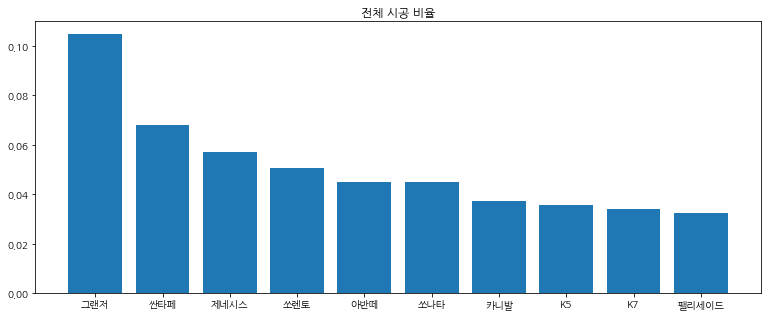

model
그랜저      0.109385
싼타페      0.072356
카니발      0.067674
아반떼      0.065120
쏘나타      0.063631
쏘렌토      0.062141
제네시스     0.051926
K5       0.044690
코나       0.042349
팰리세이드    0.039796
Name: regist_dt, dtype: float64


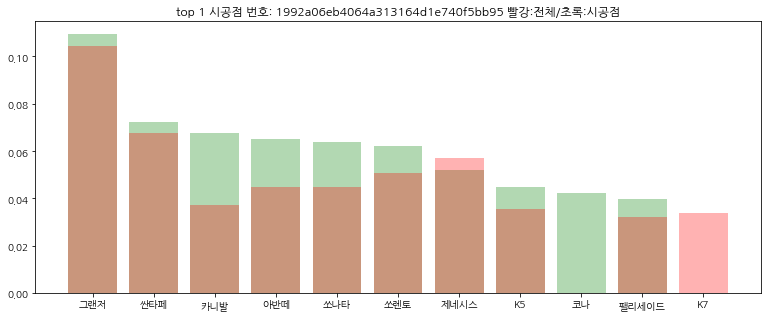

model
그랜저      0.143462
싼타페      0.076712
아반떼      0.068493
제네시스     0.066999
쏘나타      0.064259
쏘렌토      0.057534
팰리세이드    0.045081
K5       0.044085
K7       0.040349
카니발      0.035616
Name: regist_dt, dtype: float64


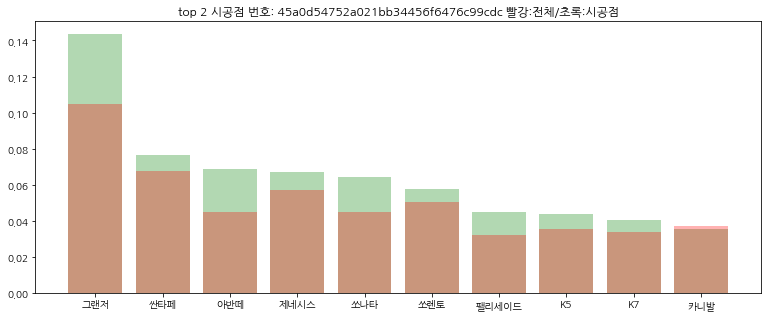

model
그랜저      0.175509
싼타페      0.115756
쏘나타      0.084137
아반떼      0.081726
제네시스     0.069936
팰리세이드    0.051983
코나       0.041265
QM6      0.035906
투싼       0.035638
쏘렌토      0.025188
Name: regist_dt, dtype: float64


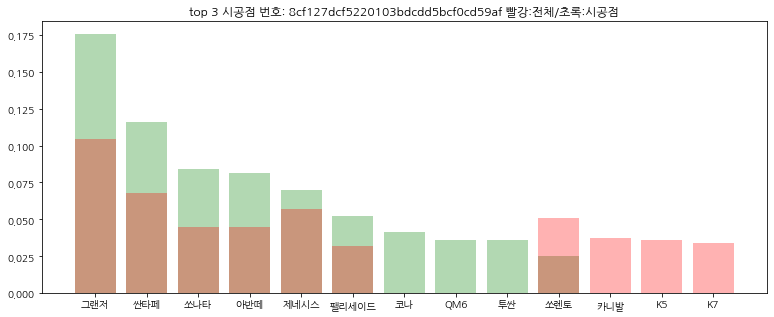

model
그랜저    0.094536
쏘렌토    0.071408
싼타페    0.065337
K5     0.063891
쏘나타    0.054640
아반떼    0.054640
카니발    0.048569
모닝     0.047702
K7     0.045389
K3     0.044232
Name: regist_dt, dtype: float64


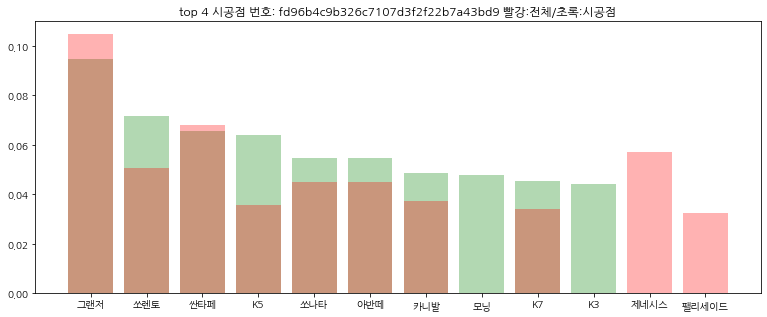

model
그랜저     0.101769
쏘렌토     0.097114
K7      0.078188
K5      0.062675
싼타페     0.053677
카니발     0.052746
셀토스     0.049023
쏘나타     0.043438
제네시스    0.040335
K3      0.036922
Name: regist_dt, dtype: float64


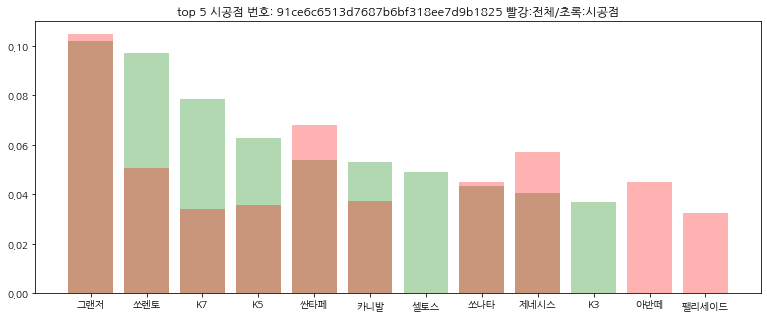

model
그랜저     0.099399
쏘렌토     0.087369
싼타페     0.071542
카니발     0.060779
K5      0.059829
K7      0.059513
K3      0.055714
제네시스    0.046850
셀토스     0.044634
아반떼     0.043685
Name: regist_dt, dtype: float64


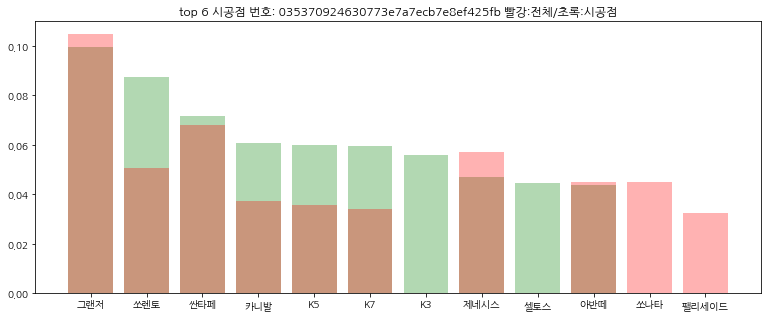

model
그랜저     0.094563
쏘렌토     0.059638
싼타페     0.056672
제네시스    0.051071
쏘나타     0.048435
카니발     0.046787
K5      0.042175
티볼리     0.039209
아반떼     0.033608
K7      0.033278
Name: regist_dt, dtype: float64


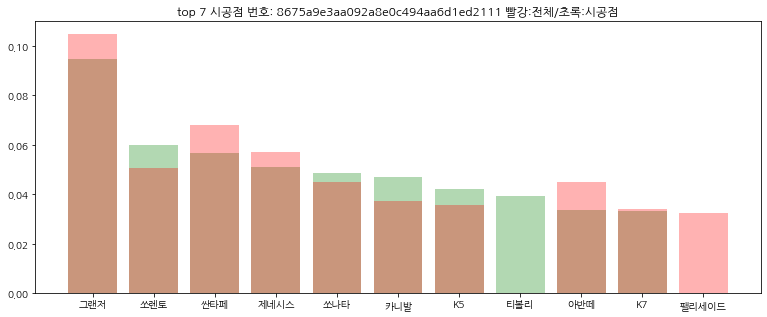

model
그랜저      0.099901
싼타페      0.077407
제네시스     0.061528
아반떼      0.052266
쏘나타      0.042342
E-클래스    0.039696
팰리세이드    0.031426
코나       0.030764
투싼       0.029110
쏘렌토      0.028779
Name: regist_dt, dtype: float64


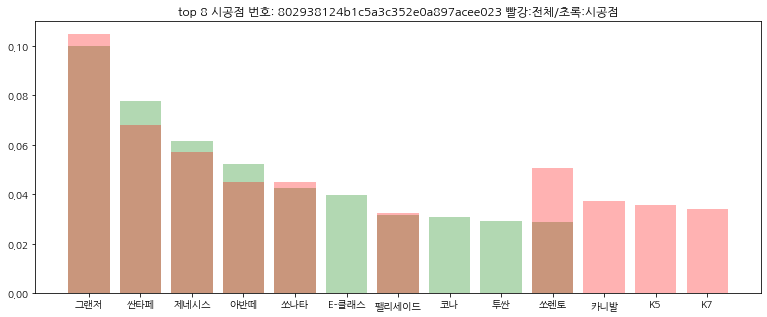

model
그랜저      0.143621
제네시스     0.079116
싼타페      0.070563
아반떼      0.059159
쏘나타      0.045973
카니발      0.036351
팰리세이드    0.035282
K7       0.029936
쏘렌토      0.028867
코나       0.028154
Name: regist_dt, dtype: float64


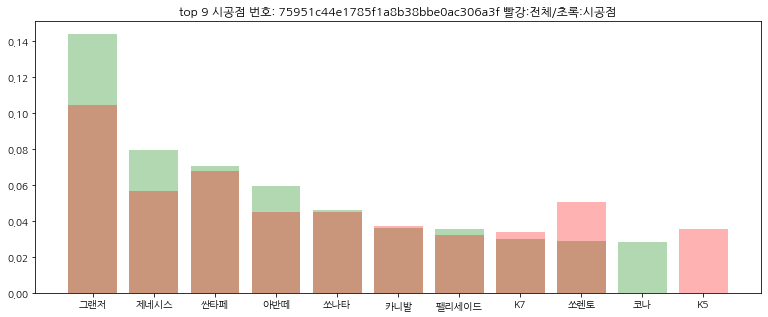

model
그랜저      0.149872
싼타페      0.111763
제네시스     0.081348
쏘나타      0.060095
아반떼      0.058996
쏘렌토      0.054965
코나       0.044339
팰리세이드    0.043606
카니발      0.035178
K7       0.034445
Name: regist_dt, dtype: float64


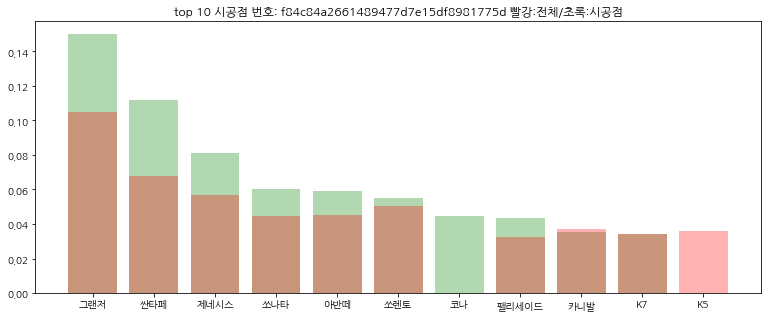

model
그랜저      0.117539
싼타페      0.074060
쏘렌토      0.070376
카니발      0.070007
제네시스     0.060059
K5       0.053058
쏘나타      0.052690
K7       0.044215
아반떼      0.041636
팰리세이드    0.038320
Name: regist_dt, dtype: float64


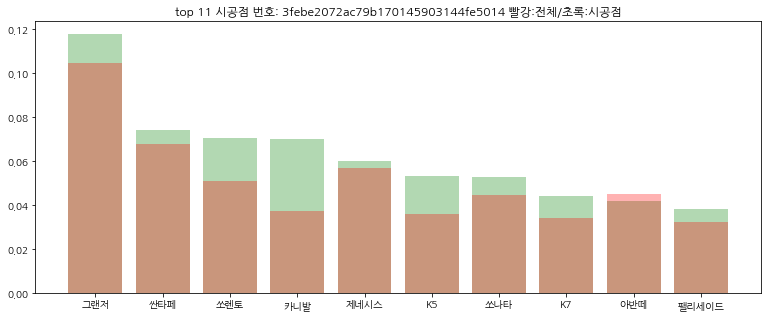

model
쏘렌토     0.102041
그랜저     0.077922
카니발     0.074954
K5      0.070130
K7      0.062338
싼타페     0.056772
제네시스    0.046382
아반떼     0.043414
셀토스     0.042301
K3      0.033395
Name: regist_dt, dtype: float64


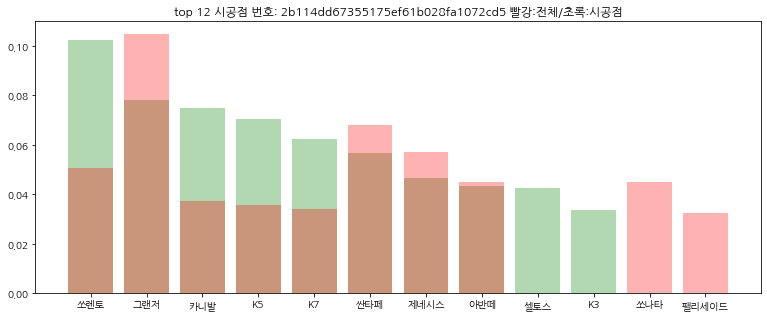

model
그랜저      0.130140
싼타페      0.084874
아반떼      0.079593
제네시스     0.076952
코나       0.070162
쏘나타      0.061109
팰리세이드    0.050924
투싼       0.048284
스파크      0.035836
쏘렌토      0.030555
Name: regist_dt, dtype: float64


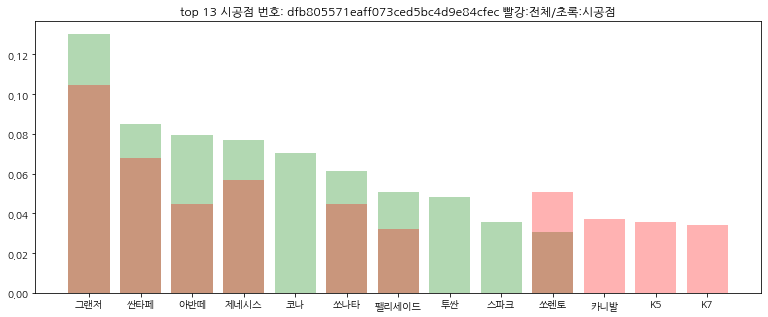

model
그랜저      0.107072
제네시스     0.073884
싼타페      0.067957
카니발      0.055709
쏘렌토      0.055314
K7       0.042276
쏘나타      0.040300
K5       0.036744
티볼리      0.035954
팰리세이드    0.032793
Name: regist_dt, dtype: float64


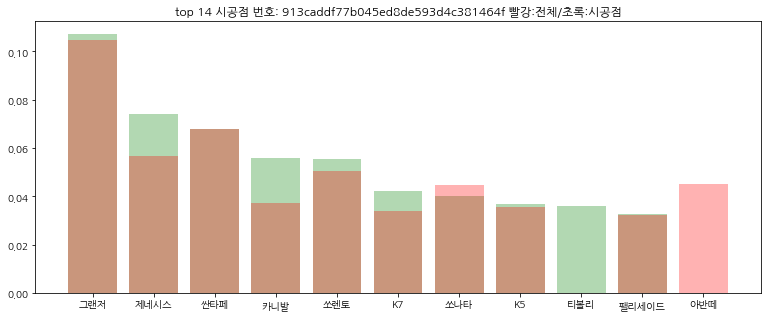

model
쏘렌토      0.098072
그랜저      0.085080
카니발      0.080889
K5       0.079631
싼타페      0.062448
K7       0.062448
셀토스      0.050293
제네시스     0.045683
아반떼      0.040235
팰리세이드    0.038558
Name: regist_dt, dtype: float64


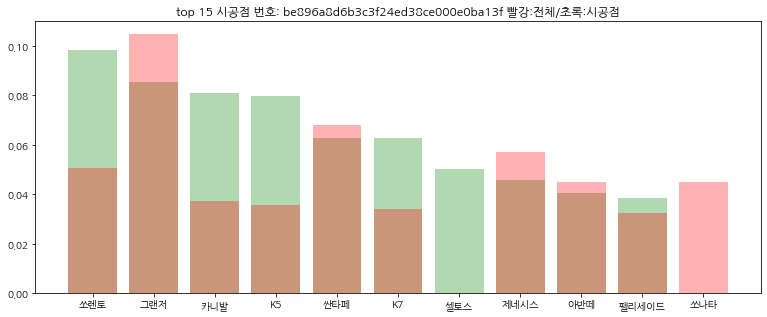

model
그랜저     0.095118
카니발     0.073232
쏘렌토     0.071549
제네시스    0.051347
K7      0.047559
싼타페     0.044192
K5      0.043771
쏘나타     0.043350
아반떼     0.031566
스포티지    0.027357
Name: regist_dt, dtype: float64


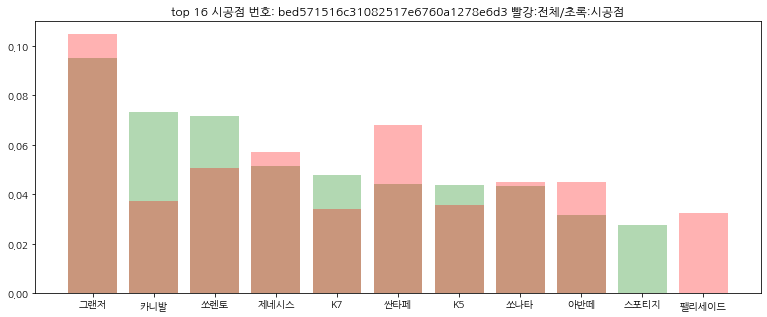

model
그랜저     0.111996
싼타페     0.073041
쏘렌토     0.071713
K7      0.052678
K5      0.045595
제네시스    0.043825
아반떼     0.038955
카니발     0.038955
쏘나타     0.038070
K3      0.035414
Name: regist_dt, dtype: float64


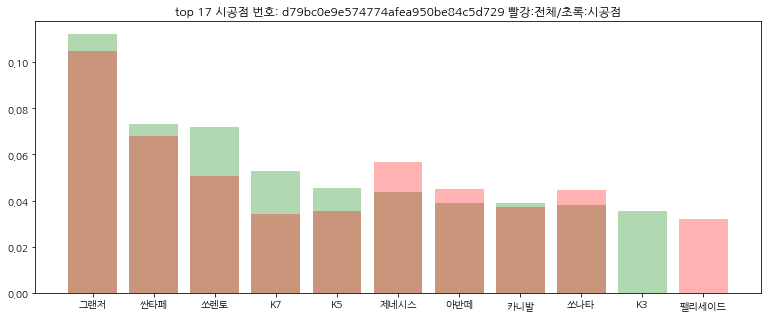

model
그랜저      0.106088
제네시스     0.069382
싼타페      0.064011
아반떼      0.046553
쏘나타      0.045658
쏘렌토      0.042972
K7       0.041182
카니발      0.036258
코나       0.035363
팰리세이드    0.032677
Name: regist_dt, dtype: float64


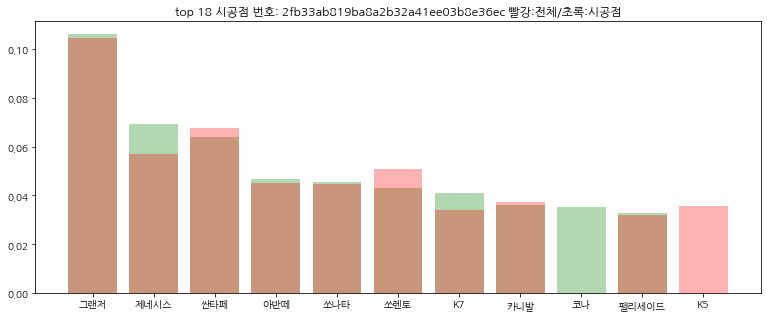

model
그랜저        0.115507
쏘렌토        0.061392
아반떼        0.059573
싼타페        0.059118
스파크        0.052296
K7         0.047294
쏘나타        0.045475
제네시스       0.044111
렉스턴 스포츠    0.038199
K5         0.035016
Name: regist_dt, dtype: float64


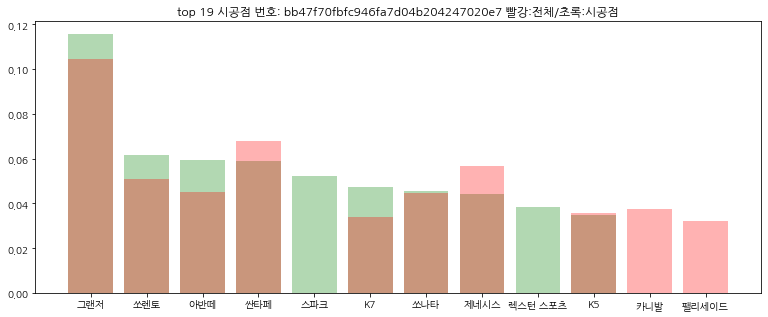

model
그랜저      0.135763
싼타페      0.096128
제네시스     0.090661
카니발      0.056492
팰리세이드    0.049203
쏘나타      0.044191
아반떼      0.041458
투싼       0.036902
쏘렌토      0.036446
K5       0.029613
Name: regist_dt, dtype: float64


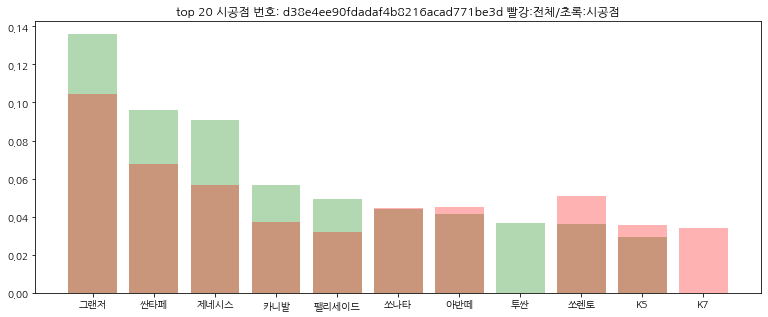

In [ ]:
#메이커별 시공비율
total_counts = total_df_item_store.groupby(['model'])['regist_dt'].count()/len(total_df_item_store)
print(total_counts.sort_values(ascending=False)[0:10])
plt.figure(figsize = (13,5))
plt.title('전체 시공 비율')
plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10])
plt.show()

for i in top_stores[0:20]:
  counts = total_df_item_store[total_df_item_store['store'] == i].groupby(['model'])['regist_dt'].count().sort_values(ascending=False)[0:10]/len(total_df_item_store[total_df_item_store['store'] == i])
  print(counts)
  plt.figure(figsize = (13,5))
  plt.title(f'top {top_stores.index(i)+1} 시공점 번호: '+i+' 빨강:전체/초록:시공점')
  plt.bar(x = counts.index, height = counts, color='green', alpha=.3)
  plt.bar(x = total_counts.sort_values(ascending=False)[0:10].index, height = total_counts.sort_values(ascending=False)[0:10], color='red', alpha=.3)
  plt.show()

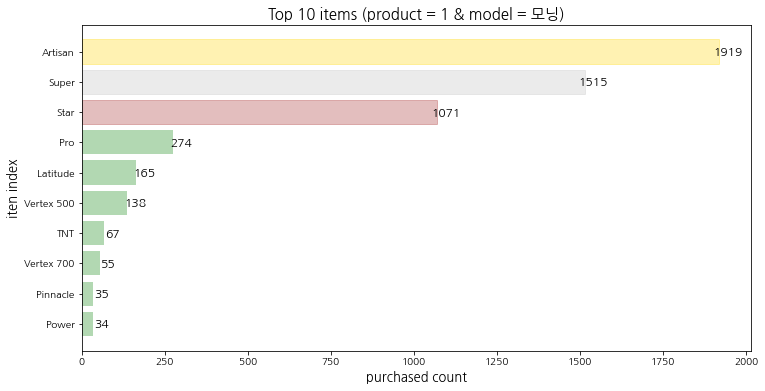

In [ ]:
# EDA 예시 : 아이템 위치와 차량 모델명을 input으로 넣으면 top 10 시공이 많이된 아이템을 뽑는 예시

def EDA_item_model(location, model_name): # 다른 조건을 추가하고 싶다면 파라미터를 추가하면 됨

  # top 10 뽑는 과정 (조건 변경 가능) # product_%d_name 대신 product_%d 도 사용 가능 (int -> string 처리를 해주어야 함에 주의)
  item_rank = total_df_item.loc[total_df_item.model == model_name, 'product_%d_name' %location].value_counts().iloc[:10].iloc[::-1]

  # 시각화 코드
  plt.figure(figsize = (12, 6))
  bar = plt.barh(item_rank.index, item_rank, color='green', alpha = 0.3)

  # 그래프 옆에 숫자 표시
  for rect in bar:
      width = rect.get_width()
      plt.text(width + 25, rect.get_y() + rect.get_height()/4.0, '%d' %width, ha='center', va='bottom', size = 12)

  # 금은동 색칠
  bar[-1].set_color(c = 'gold')
  bar[-2].set_color(c = 'silver')
  bar[-3].set_color(c = 'brown')

  # 제목, 축 이름
  plt.title('Top 10 items (product = %d & model = %s)' % (location, model_name), size = 15)
  plt.xlabel('purchased count', size = 13)
  plt.ylabel('iten index', size = 13)
  plt.show()

EDA_item_model(1, '모닝')

count       195.000000
mean     516826.210256
std       74913.214075
min       50000.000000
25%      520000.000000
50%      520000.000000
75%      520000.000000
max      810000.000000
Name: price, dtype: float64


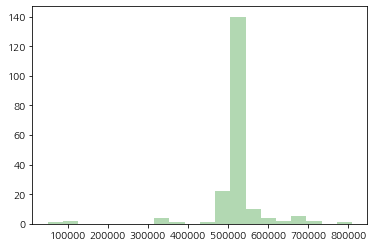

In [ ]:
# EDA 예시 : 조건 설정시 가격 분포 추출 (사용법 : Notion 내 Brainstorming 문서 참조)

def Price_Dist(df, model, store, dealer, product):
  condition_1 = True; condition_2 = True; condition_3 = True; condition_4 = True
  if model: condition_1 = df['model'] == model
  if store: condition_2 = df['store'] == store
  if (dealer == 0) | (dealer == 1): condition_3 = df['by_dealer'] == dealer
  if product:
    for i in range(6):
      if product[i]:
        col = 'product_%d' % (i + 1) # 이 부분 'product_%d_name'으로 바꾸면 item name을 기준으로 검색 가능
        condition_4 = (condition_4) & (df[col] == product[i])
  prices = df.loc[(condition_1) & (condition_2) & (condition_3) & (condition_4), 'price']
  # prices = prices.loc[prices < prices.quantile(0.95)] # 상위 5% 이상치 제거 가능 (숫자 변경 가능)
  print(prices.describe())
  plt.hist(prices, bins = 20, color = 'green', alpha = 0.3)
  plt.show()

Price_Dist(total_df_item, '말리부', None, 0, [284, None, None, None, None, None])

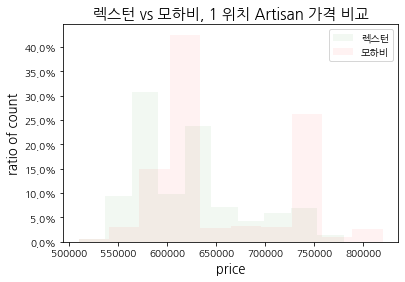

In [ ]:
# EDA 예시 : 두 차종의 특정 위치, 특정 상품의 가격분포 비교 (ex : 렉스턴 vs 모하비, 1번 위치에 Artisan이 시공된 경우에 대해서 보고 싶을 때)
# 다만, 다른 위치의 상품은 따로 고려해두지는 않았음

from matplotlib.ticker import PercentFormatter

def Compare_Price(df, car1, car2, location, item_name):
  car1_price = df.loc[(df['model'] == car1) & (df['product_%d_name' % location] == item_name), 'price'] # product_%d 로 item number 대신 사용 가능
  car2_price = df.loc[(df['model'] == car2) & (df['product_%d_name' % location] == item_name), 'price']
  car1_price = car1_price.loc[(car1_price < car1_price.quantile(0.95)) & (car1_price > car1_price.quantile(0.05))] # 상, 하위 5%는 제거
  car2_price = car2_price.loc[(car2_price < car2_price.quantile(0.95)) & (car2_price > car2_price.quantile(0.05))] # (숫자 변경 가능)
  plt.hist(car1_price, bins = 10, color = 'green', alpha = 0.05, label = '%s' % car1,\
          weights=np.ones(len(car1_price)) / len(car1_price)) # 전체 수 대비 차지하는 비율로 바꿔줌
  plt.hist(car2_price, bins = 10, color = 'red', alpha = 0.05, label = '%s' % car2,\
        weights=np.ones(len(car2_price)) / len(car2_price))
  plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
  plt.title('%s vs %s, %d 위치 %s 가격 비교' % (car1, car2, location, item_name), size = 15)
  plt.xlabel('price', size = 13)
  plt.ylabel('ratio of count', size = 13)
  plt.legend()
  plt.show()
Compare_Price(total_df_item, '렉스턴', '모하비', 1, 'Artisan')

In [ ]:
!pip install haversine

In [ ]:
#위경도 거리 구하기

from haversine import haversine

# 위경도 입력
Seoul = total_df_item_store.latlng[10]  #Latitude, Longitude
Toronto = total_df_item_store.latlng[10000]

# 거리 계산
haversine(Seoul, Toronto, unit = 'km')

11.451124544824484

In [ ]:
import folium

mapm = folium.Map(location=[36.566345, 127.977893], zoom_start=7)

for i in df.latlng:
        folium.Circle(i, radius=5000).add_to(mapm)
return mapm

In [ ]:
import ast
def str_to_tuple(latlng):
  return float(ast.literal_eval(latlng)[0]),float(ast.literal_eval(latlng)[1])
total_df_item_store.latlng = total_df_item_store.latlng.map(lambda x: str_to_tuple(x))

In [ ]:
total_df_item_store.latlng[10]

(126.922874651726, 37.5070772373459)

In [ ]:
def distance(latlng1, latlng2, rad):
  if haversine(latlng1, latlng2, unit = 'km')<=rad:
    return True
  else:
    return False
Seoul = total_df_item_store.latlng[10]  #Latitude, Longitude
Toronto = total_df_item_store.latlng[10000]
distance(Seoul,Toronto,12)

True

count    5.519100e+04
mean     6.758190e+05
std      3.924505e+05
min      0.000000e+00
25%      3.800000e+05
50%      6.000000e+05
75%      8.400000e+05
max      1.640000e+07
Name: price, dtype: float64


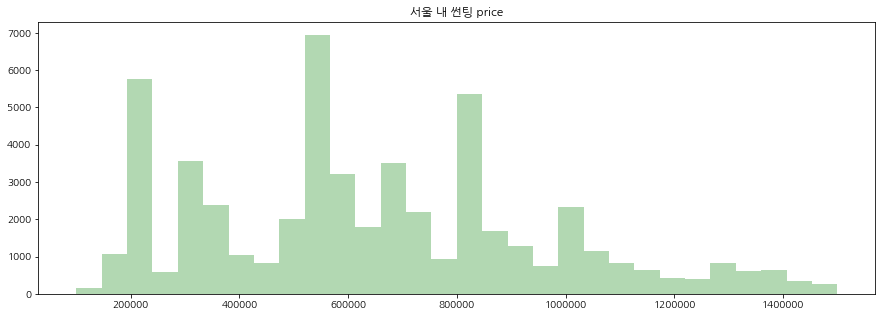

count    2.279200e+04
mean     6.874959e+05
std      3.594293e+05
min      0.000000e+00
25%      5.100000e+05
50%      6.000000e+05
75%      8.000000e+05
max      7.500000e+06
Name: price, dtype: float64


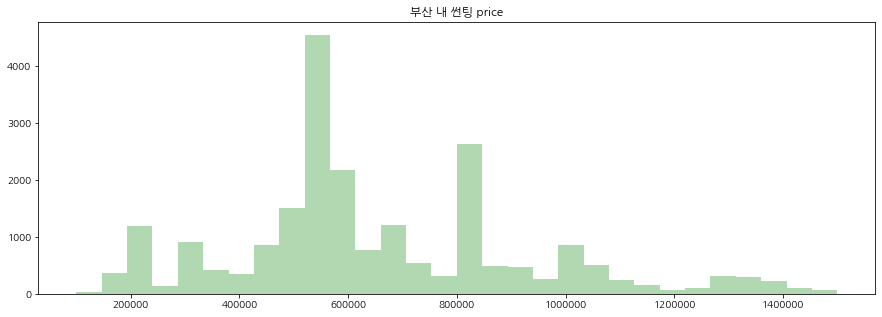

count    2.200700e+04
mean     5.488773e+05
std      2.856799e+05
min      0.000000e+00
25%      3.500000e+05
50%      5.500000e+05
75%      6.500000e+05
max      8.000000e+06
Name: price, dtype: float64


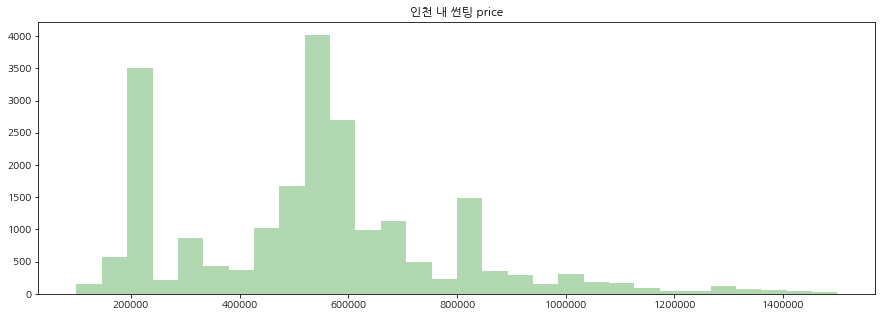

count    2.721200e+04
mean     6.496374e+05
std      3.169338e+05
min      0.000000e+00
25%      5.000000e+05
50%      5.800000e+05
75%      7.800000e+05
max      1.300000e+07
Name: price, dtype: float64


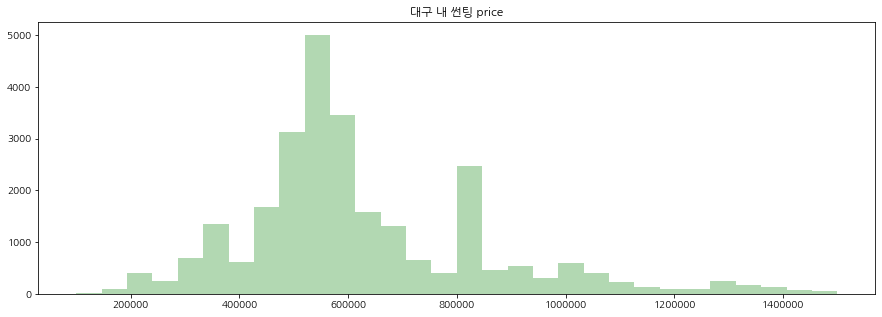

count    1.369000e+04
mean     6.461811e+05
std      2.979630e+05
min      0.000000e+00
25%      5.000000e+05
50%      5.800000e+05
75%      8.000000e+05
max      9.500000e+06
Name: price, dtype: float64


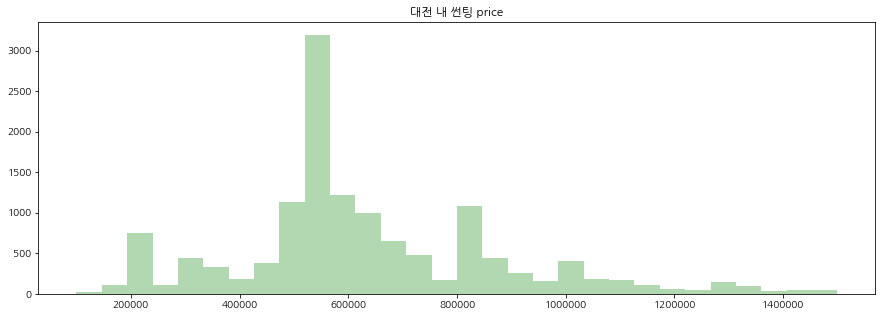

count    1.065000e+03
mean     4.705258e+05
std      3.145780e+05
min      0.000000e+00
25%      2.100000e+05
50%      4.700000e+05
75%      5.800000e+05
max      2.850000e+06
Name: price, dtype: float64


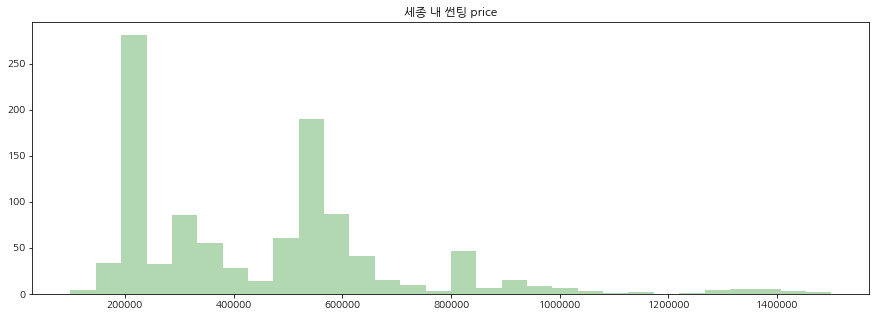

count    6.160000e+03
mean     6.944085e+05
std      3.716792e+05
min      9.900000e+02
25%      5.000000e+05
50%      6.000000e+05
75%      8.700000e+05
max      2.900000e+06
Name: price, dtype: float64


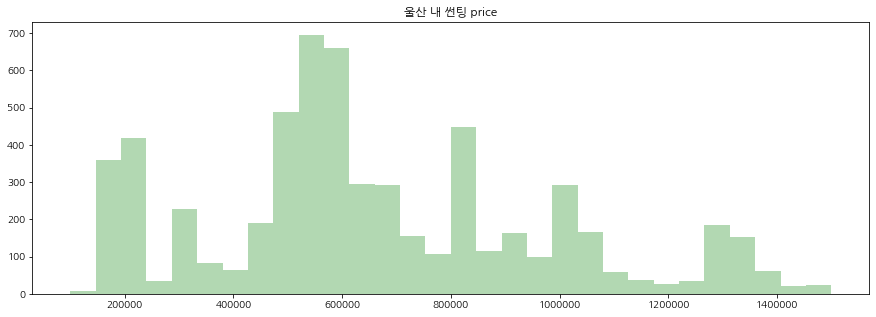

count    1.505500e+04
mean     6.481421e+05
std      3.265868e+05
min      0.000000e+00
25%      5.000000e+05
50%      5.800000e+05
75%      8.000000e+05
max      5.500000e+06
Name: price, dtype: float64


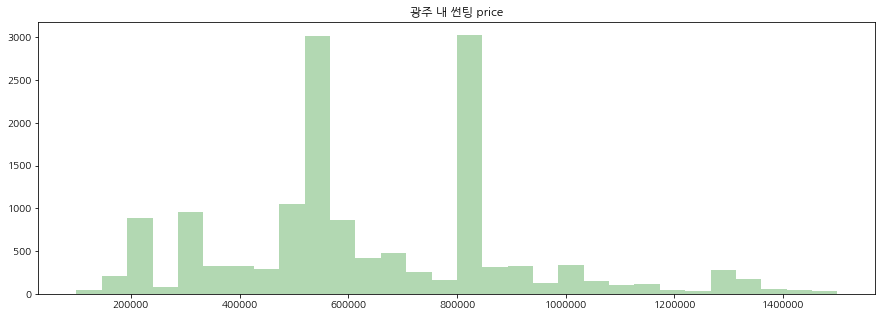

count    9.313900e+04
mean     6.513960e+05
std      7.043282e+06
min      0.000000e+00
25%      4.500000e+05
50%      5.800000e+05
75%      8.000000e+05
max      2.147484e+09
Name: price, dtype: float64


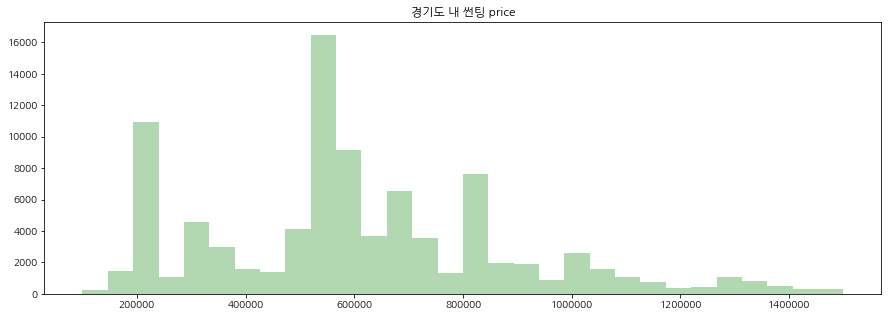

count    6.105000e+03
mean     5.222885e+05
std      3.508424e+05
min      0.000000e+00
25%      2.100000e+05
50%      4.500000e+05
75%      7.000000e+05
max      6.000000e+06
Name: price, dtype: float64


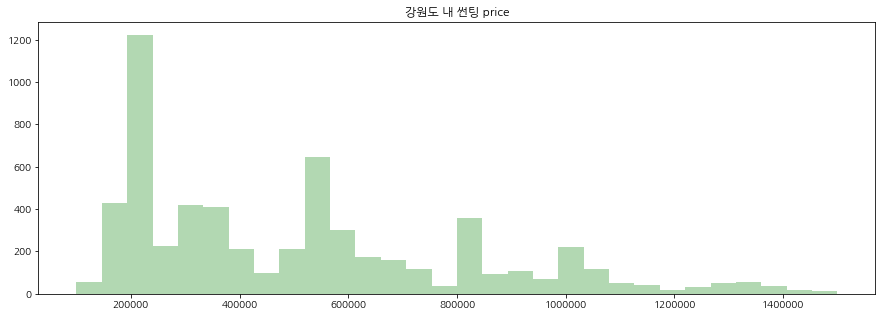

count    6.210000e+03
mean     5.875443e+05
std      3.646342e+05
min      0.000000e+00
25%      3.300000e+05
50%      5.200000e+05
75%      8.000000e+05
max      4.000000e+06
Name: price, dtype: float64


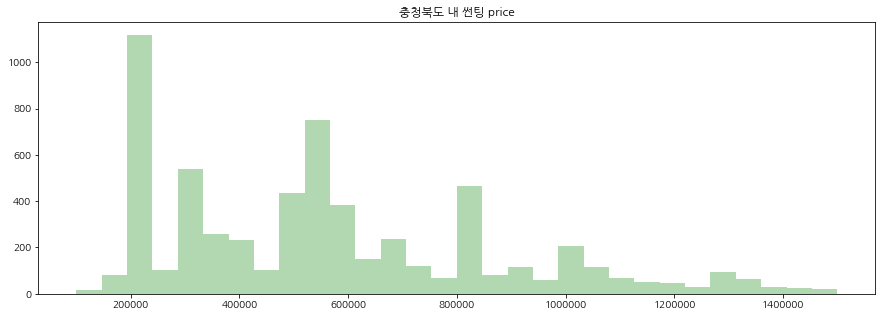

count    6.590000e+03
mean     7.443613e+05
std      4.830937e+05
min      0.000000e+00
25%      4.500000e+05
50%      6.650000e+05
75%      1.000000e+06
max      1.115000e+07
Name: price, dtype: float64


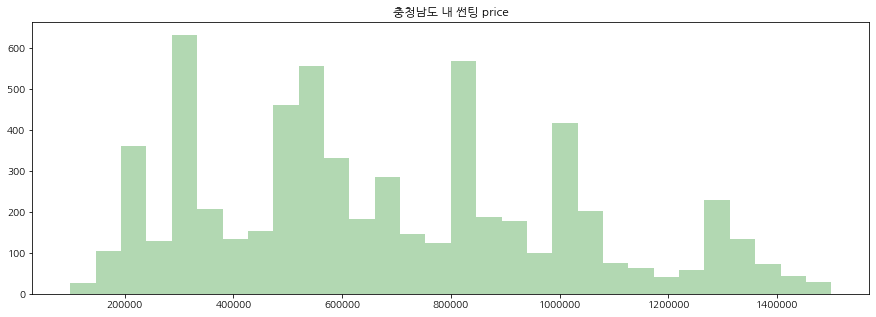

count    1.121100e+04
mean     5.825350e+05
std      3.055101e+05
min      0.000000e+00
25%      4.500000e+05
50%      5.200000e+05
75%      6.500000e+05
max      8.000000e+06
Name: price, dtype: float64


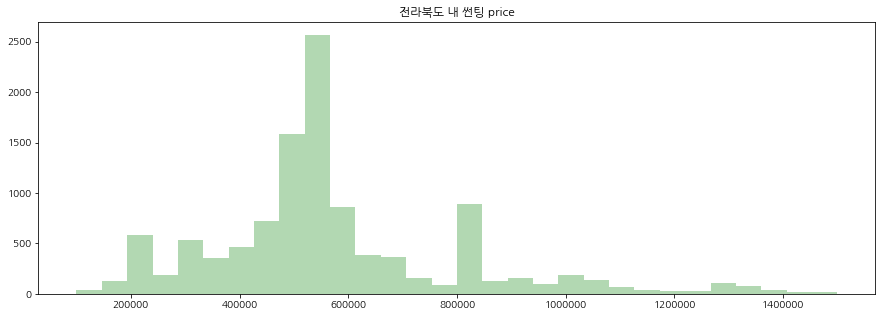

count    4.858000e+03
mean     6.790698e+05
std      3.062298e+05
min      0.000000e+00
25%      5.000000e+05
50%      6.000000e+05
75%      8.175000e+05
max      6.700000e+06
Name: price, dtype: float64


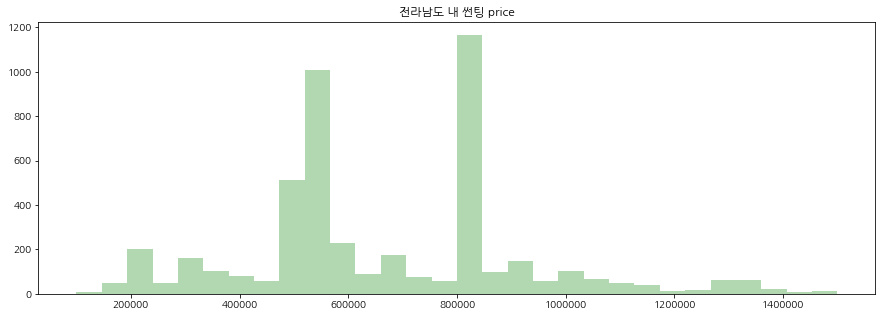

count    1.827100e+04
mean     6.349011e+05
std      3.416005e+05
min      0.000000e+00
25%      4.800000e+05
50%      5.500000e+05
75%      8.000000e+05
max      7.800000e+06
Name: price, dtype: float64


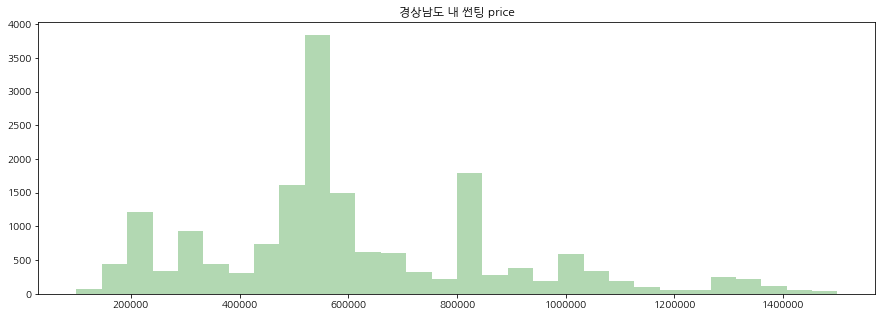

count    1.463600e+04
mean     6.326948e+05
std      3.258762e+05
min      0.000000e+00
25%      5.000000e+05
50%      5.500000e+05
75%      7.100000e+05
max      1.000000e+07
Name: price, dtype: float64


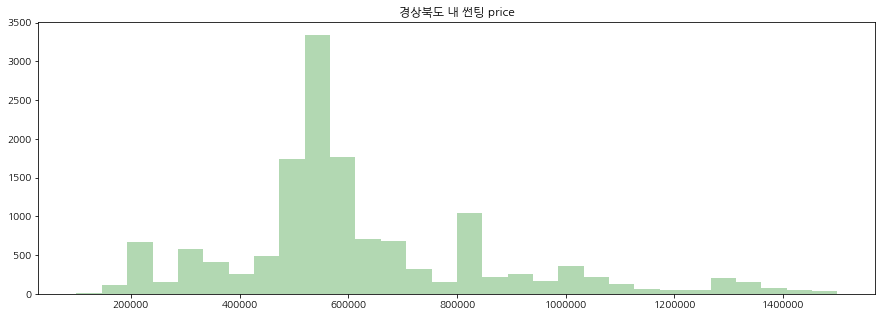

In [ ]:
def Price_Dist_city(df, model, store, dealer, city, product):
  condition_1 = True; condition_2 = True; condition_3 = True; condition_4 = True
  if model: condition_1 = df['model'] == model
  if store: condition_2 = df['store'] == store
  if city: condition_5 = df['city'] == city
  if (dealer == 0) | (dealer == 1): condition_3 = df['by_dealer'] == dealer
  if product:
    for i in range(6):
      if product[i]:
        col = 'product_%d' % (i + 1) # 이 부분 'product_%d_name'으로 바꾸면 item name을 기준으로 검색 가능
        condition_4 = (condition_4) & (df[col] == product[i])
  prices = df.loc[(condition_1) & (condition_2) & (condition_3) & (condition_4) & (condition_5), 'price']
  # prices = prices.loc[prices < prices.quantile(0.95)] # 상위 5% 이상치 제거 가능 (숫자 변경 가능)
  print(prices.describe())
  plt.figure(figsize = (15,5))
  plt.hist(prices, bins = 30, color = 'green', alpha = 0.3, range = (100000,1500000))
  plt.title(city + ' 내 썬팅 price')
  ax = plt.gca()
  ax.get_xaxis().get_major_formatter().set_scientific(False)
  plt.show()
for i in pd.Series(city_dict.values()).unique():
  Price_Dist_city(total_df_item_store, None, None, 0, i, [None, None, None, None, None, None])

In [ ]:
pd.Series(city_dict.values()).unique()

array(['서울', '부산', '인천', '대구', '대전', '세종', '울산', '광주', '경기도', '강원도',
       '충청북도', '충청남도', '전라북도', '전라남도', '경상남도', '경상북도'], dtype=object)

In [ ]:
"""'서울광역시': '서울','서울' : '서울','서울시' : '서울',""".replace('서울','광주')

"'광주광역시': '광주','광주' : '광주','광주시' : '광주',"

In [ ]:
city_dict = {
    '서울특별시': '서울',
    '서울' : '서울',
    '서울시' : '서울',
    '부산광역시': '부산','부산' : '부산','부산시' : '부산',
    '인천광역시': '인천','인천' : '인천','인천시' : '인천',
    '대구광역시': '대구','대구' : '대구','대구시' : '대구',
    '대전광역시': '대전','대전' : '대전','대전시' : '대전',
    '세종특별시': '세종','세종' : '세종','세종시' : '세종',
    '울산광역시': '울산','울산' : '울산','울산시' : '울산',
    '광주광역시': '광주','광주' : '광주','광주시' : '광주',
    '경기도':'경기도', '경기':'경기도',
    '강원도':'강원도','강원' :'강원도',
    '충북':'충청북도','충청북도':'충청북도',
    '충남':'충청남도','충청남도':'충청남도',
    '전라북도':'전라북도','전북':'전라북도',
    '전라남도':'전라남도','전남':'전라남도',
    '경상남도':'경상남도','경남':'경상남도',
    '경상북도':'경상북도','경북':'경상북도'
}

In [ ]:
total_df_item_store['city'] = total_df_item_store.store_addr.map(lambda x: city_dict[x.split(' ')[0]] if str(x).split(' ')[0] in city_dict.keys() else None)

In [ ]:
total_df_item_store['city']

0           서울
1           서울
2           서울
3           서울
4           서울
          ... 
395884      대구
395885      대구
395886      대구
395887      대구
395888    전라남도
Name: city, Length: 395889, dtype: object

In [ ]:
'서울' in city_dict.keys()

True

<BarContainer object of 16 artists>

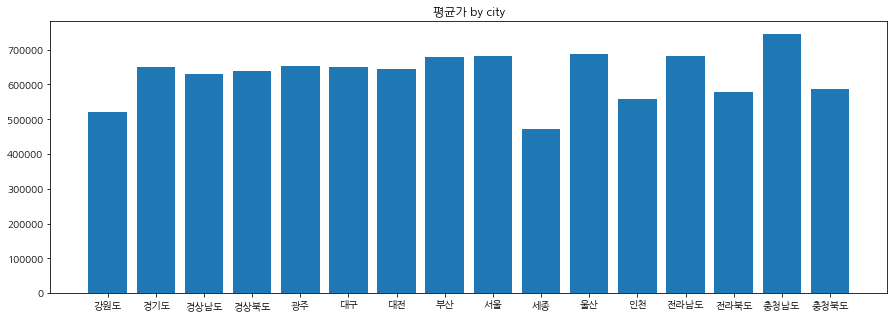

In [ ]:
plt.figure(figsize = (15,5))
plt.title('평균가 by city')
plt.bar(total_df_item_store.groupby('city').price.mean().index,total_df_item_store.groupby('city').price.mean())

In [ ]:
total_df_item_store.groupby('city').price.mean()

city
강원도     521317.707522
경기도     649430.349702
경상남도    629993.703399
경상북도    638053.741564
광주      654143.319701
대구      651661.996094
대전      644993.563665
부산      680117.239788
서울      682218.601350
세종      470525.821596
울산      688276.978232
인천      559193.104247
전라남도    681036.814547
전라북도    578599.968102
충청남도    744684.927892
충청북도    586843.050847
Name: price, dtype: float64

In [ ]:
total_df_item_store[total_df_item_store['city'].isnull()]

Unnamed: 0       regist_dt  ... predicted_name  city
279              1  20201231164930  ...     3M썬팅 대전중리점  None
280             74  20201228141809  ...     3M썬팅 대전중리점  None
281            143  20201223125224  ...     3M썬팅 대전중리점  None
282            190  20201221115251  ...     3M썬팅 대전중리점  None
283            373  20201211101307  ...     3M썬팅 대전중리점  None
...            ...             ...  ...            ...   ...
394966      382022  20180329082349  ...        Unknown  None
394967      382023  20180329082113  ...        Unknown  None
394968      385132  20180315103149  ...        Unknown  None
394969      388144  20180226155250  ...        Unknown  None
394970      392327  20180126153128  ...        Unknown  None

[4227 rows x 26 columns]

In [ ]:
None == None

True